# ASSET COST MANAGEMENT CASE STUDY

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import datetime
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns


# Load Data

In [2]:
# Disabling the max rows/columns shown in the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Project root = parent of the notebooks/ folder
PROJECT_ROOT = Path("..").resolve()

# Raw data folder
DATA_RAW = PROJECT_ROOT / "data-raw"

# Main synthetic dataset
data_path = DATA_RAW / "asset_lifecycle_public_synthetic_read.xlsx"

print("Looking for:", data_path)

df_assets = pd.read_excel(data_path)
print("Loaded shape:", df_assets.shape)


Looking for: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-raw\asset_lifecycle_public_synthetic_read.xlsx
Loaded shape: (33886, 27)


In [4]:
# Quick check
df_assets.head(10)


Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   
5    FAC_0002  SITE_0002                    Town A                   Sanitary   
6    FAC_0002  SITE_0002                    Town A                       Fire   
7    FAC_0003  SITE_0003                    Town A                  Transport   
8    FAC_0003  SITE_0003                    Town A                 Electrical   
9    FAC_0003  SITE_0003                    Town A                       Fire   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   
5   WC Toilet Disabled / All Types   
6                   Fire Detection   
7                            Lifts   
8              Specialist Lighting   
9                    Fire Fighting   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   
5  Sanitary | WC Toilet Disabled / All Types | Vi...   
6         Fire | Fire Detection | Fire Heat Detector   
7                   Transport | Lifts | Scissor Lift   
8  Electrical | Specialist Lighting | Internal | ...   
9    Fire | Fire Fighting | Fire Extinguishers | CO2   

                          Asset type       Asset description  \
0             Pull Cord/Alarm Switch  Emergency Toilet Alarm   
1       Personal Attack Alarm System                     NaN   
2  Fire Call Point / Break Glass BGU                     NaN   
3       Vitreous china/fireclay/uPVC                     NaN   
4       Vitreous china/fireclay/uPVC                     NaN   
5       Vitreous china/fireclay/uPVC                     NaN   
6                 Fire Heat Detector                     NaN   
7                       Scissor Lift          Vehicle Ramp 6   
8      Illuminated Fire Exit Signage                     NaN   
9                                CO2                     NaN   

                     Category Asset ID/Barcode Asset existing ID  \
0  Communications and Control    ASSET_0000001       LEG_0000001   
1                    Security    ASSET_0000002       LEG_0000002   
2                        Fire    ASSET_0000003       LEG_0000003   
3                    Sanitary    ASSET_0000004       LEG_0000004   
4                    Sanitary    ASSET_0000005       LEG_0000005   
5                    Sanitary    ASSET_0000006       LEG_0000006   
6                        Fire    ASSET_0000007       LEG_0000007   
7                       Lifts    ASSET_0000008       LEG_0000008   
8                  Electrical    ASSET_0000009       LEG_0000009   
9                        Fire    ASSET_0000010       LEG_0000010   

  Criticality description Condition Priority  Quantity Replacement Cost  \
0                  Urgent         B       P4       1.0              £75   
1                  Urgent         B       P4       2.0           £3,000   
2                  Urgent         B       P4       2.0             £392   
3                     Low         B       P4       1.0             £350   
4                  Medium         B       P4       2.0             £600   
5                  Medium         B       P4       1.0             £300   
6                  Urgent         B       P4      11.0           £3,850   
7                  M

# Clean Data

In [5]:
# Assume this cell is in notebooks/ and PROJECT_ROOT is already defined:
# PROJECT_ROOT = Path("..").resolve()
# If not, uncomment the next line:
# PROJECT_ROOT = Path("..").resolve()

DATA_RAW = PROJECT_ROOT / "data-raw"

# 1) Load mapping workbook (relative path from project root)
crit_path = DATA_RAW / "Asset Criticality.xlsx"
print("Loading criticality mapping from:", crit_path)

crit_map_df = pd.read_excel(crit_path)

# 2) Normalise keys on BOTH sides to avoid whitespace/case mismatches
def norm(s):
    return (
        s.astype("string")
         .str.strip()
         .str.replace(r"\s+", " ", regex=True)
         .str.upper()
    )

crit_map_df["_KEY"] = norm(crit_map_df["System Full Path"])
df_assets["_KEY"]    = norm(df_assets["System full path"])

# 3) Remove duplicates in mapping
dupes = crit_map_df["_KEY"].duplicated(keep=False)
if dupes.any():
    print("Duplicate System Full Path values in mapping; keeping first occurrence.")
crit_map_unique = crit_map_df.drop_duplicates(subset="_KEY", keep="first")

# 4) Apply mapping
df_assets = df_assets.merge(
    crit_map_unique[["_KEY", "Criticality"]],
    on="_KEY",
    how="left",
    suffixes=("", "_mapped"),
)

# 5) Update Criticality description
df_assets["Criticality description"] = (
    df_assets["Criticality"]                         # from mapping
      .fillna(df_assets.get("Criticality description"))  # keep existing if present
      .fillna("Unknown")
)

# 6) Drop cleanup cols
df_assets = df_assets.drop(columns=["_KEY", "Criticality"], errors="ignore")

# 7) Quick QA
unmapped_count = (df_assets["Criticality description"] == "Unknown").sum()
print(f"Unmapped after join: {unmapped_count}")

if unmapped_count:
    sample_unmapped = (
        df_assets.loc[df_assets["Criticality description"] == "Unknown", "System full path"]
        .drop_duplicates()
        .head(20)
    )
    print("Example unmapped system paths:")
    print(sample_unmapped.to_string(index=False))

Loading criticality mapping from: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-raw\Asset Criticality.xlsx
Unmapped after join: 0


In [6]:
# Data type inspection
df_assets.dtypes

Facility ID                   object
Facility                      object
Facility General Location     object
System                        object
Type                          object
System full path              object
Asset type                    object
Asset description             object
Category                      object
Asset ID/Barcode              object
Asset existing ID             object
Criticality description       object
Condition                     object
Priority                      object
Quantity                     float64
Replacement Cost              object
Life Cycle                     int64
Revised Life                   int64
Expected remaining life        int64
CIBSE Life Expectancy          int64
Revised Exp Year               int64
Match                           bool
10 Year Total                 object
Our Category 1                object
Our Category 2                object
25+ Years                      int64
15+ Years                      int64
d

In [7]:
# Quick check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type       Asset description  \
0             Pull Cord/Alarm Switch  Emergency Toilet Alarm   
1       Personal Attack Alarm System                     NaN   
2  Fire Call Point / Break Glass BGU                     NaN   
3       Vitreous china/fireclay/uPVC                     NaN   
4       Vitreous china/fireclay/uPVC                     NaN   

                     Category Asset ID/Barcode Asset existing ID  \
0  Communications and Control    ASSET_0000001       LEG_0000001   
1                    Security    ASSET_0000002       LEG_0000002   
2                        Fire    ASSET_0000003       LEG_0000003   
3                    Sanitary    ASSET_0000004       LEG_0000004   
4                    Sanitary    ASSET_0000005       LEG_0000005   

  Criticality description Condition Priority  Quantity Replacement Cost  \
0                  Urgent         B       P4       1.0              £75   
1                  Urgent         B       P4       2.0           £3,000   
2                  Urgent         B       P4       2.0             £392   
3                     Low         B       P4       1.0             £350   
4                  Medium         B       P4       2.0             £600   

   Life Cycle  Revised Life  Expected remaining life  CIBSE Life Expectancy  \
0          10             3                        3                     10   
1          15             8                        8                     15   
2          15             8                        8                     15   
3          20            13                       13                     20   
4          20             6                        6                     20   

   Revised Exp Year  Match 10 Year Total              Our Category 1  \
0              2027   True           £75  Communications and Control   
1              2032   True        £3,000                    Security   
2              2032   True          £392                        Fire   
3              2037   True            £0                    Sanitary   
4              2030   True          £600                    Sanitary   

   Our Category 2  25+ Years  15+ Years  
0   Comms Systems          0          0  
1         Systems          0          0  
2  Fire Detection          0          0  
3        Sanitary          0          0  
4        Sanitary          0          1

In [8]:
# Inspecting percentage of missing data per column
empty_percentage = df_assets.isnull().mean()*100
print(empty_percentage)
empty_percentage.to_csv('empty_percentage.csv', header=['Missing %'])


Facility ID                   2.785811
Facility                      0.000000
Facility General Location     0.000000
System                        0.000000
Type                          0.000000
System full path              0.000000
Asset type                    2.785811
Asset description            38.390486
Category                      0.000000
Asset ID/Barcode              0.000000
Asset existing ID             0.000000
Criticality description       0.000000
Condition                     0.000000
Priority                      2.785811
Quantity                      0.011804
Replacement Cost              0.000000
Life Cycle                    0.000000
Revised Life                  0.000000
Expected remaining life       0.000000
CIBSE Life Expectancy         0.000000
Revised Exp Year              0.000000
Match                         0.000000
10 Year Total                 0.000000
Our Category 1                0.000000
Our Category 2                0.000000
25+ Years                

# Drop unwanted columns


In [9]:
# 1) List of columns to drop
cols_to_drop = [
    "Asset description", "Asset existing ID", "Priority"
]

# 2) Check which exist
existing_cols = [c for c in cols_to_drop if c in df_assets.columns]

print(f"Found {len(existing_cols)} columns to drop out of {len(cols_to_drop)} listed.")

# 3) Drop them
df_assets = df_assets.drop(columns=existing_cols)

print("Dropped columns:")
for col in existing_cols:
    print("  -", col)

print("\nRemaining columns:")
print(df_assets.columns.tolist())


Found 3 columns to drop out of 3 listed.
Dropped columns:
  - Asset description
  - Asset existing ID
  - Priority

Remaining columns:
['Facility ID', 'Facility', 'Facility General Location', 'System', 'Type', 'System full path', 'Asset type', 'Category', 'Asset ID/Barcode', 'Criticality description', 'Condition', 'Quantity', 'Replacement Cost', 'Life Cycle', 'Revised Life', 'Expected remaining life', 'CIBSE Life Expectancy', 'Revised Exp Year', 'Match', '10 Year Total', 'Our Category 1', 'Our Category 2', '25+ Years', '15+ Years']


In [10]:
# Quick check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B       1.0   
1    ASSET_0000002                  Urgent         B       2.0   
2    ASSET_0000003                  Urgent         B       2.0   
3    ASSET_0000004                     Low         B       1.0   
4    ASSET_0000005                  Medium         B       2.0   

  Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0              £75          10             3                        3   
1           £3,000          15             8                        8   
2             £392          15             8                        8   
3             £350          20            13                       13   
4             £600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match 10 Year Total  \
0                     10              2027   True           £75   
1                     15              2032   True        £3,000   
2                     15              2032   True          £392   
3                     20              2037   True            £0   
4                     20              2030   True          £600   

               Our Category 1  Our Category 2  25+ Years  15+ Years  
0  Communications and Control   Comms Systems          0          0  
1                    Security         Systems          0          0  
2                        Fire  Fire Detection          0          0  
3                    Sanitary        Sanitary          0          0  
4                    Sanitary        Sanitary          0          1

In [11]:
# Checking for NaN data
empty_percentage = df_assets.isnull().mean()*100
print(empty_percentage)
empty_percentage.to_csv('empty_percentage.csv', header=['Missing %'])

Facility ID                  2.785811
Facility                     0.000000
Facility General Location    0.000000
System                       0.000000
Type                         0.000000
System full path             0.000000
Asset type                   2.785811
Category                     0.000000
Asset ID/Barcode             0.000000
Criticality description      0.000000
Condition                    0.000000
Quantity                     0.011804
Replacement Cost             0.000000
Life Cycle                   0.000000
Revised Life                 0.000000
Expected remaining life      0.000000
CIBSE Life Expectancy        0.000000
Revised Exp Year             0.000000
Match                        0.000000
10 Year Total                0.000000
Our Category 1               0.000000
Our Category 2               0.000000
25+ Years                    0.000000
15+ Years                    0.000000
dtype: float64


## Replace NaN data

In [12]:
# Filling missing values for categorical columns
# NB: Not all columns filled in, some left NaN 

# 1) Standardize placeholder values to real NA
placeholders = ['Unknown','unknown','TBC','tbc','NaN','nan','Na','na','',' ']
df_assets["Facility ID"] = df_assets["Facility ID"].replace(placeholders, pd.NA)

# 2) Fill missing values with "Unknown"
df_assets["Facility ID"] = df_assets["Facility ID"].fillna("Unknown")

# Quick check
print(df_assets["Facility ID"].isna().sum())   # should be 0


0


In [13]:
# Fill in NaN values for 'Asset Type' column
df_assets["Asset type"] = df_assets["Asset type"].fillna("Roof Fabric")
df_assets['Asset type'].isnull().sum()

np.int64(0)

In [14]:
# Filling in missing values for numerical data
# Helper: clean numeric-looking strings (currency, commas, spaces, accounting negatives)
def to_numeric_clean(s: pd.Series) -> pd.Series:
    s = (
        s.astype(str)
         .str.strip()
         .str.replace(r'[\$,£,€]', '', regex=True)   # currency symbols
         .str.replace(',', '', regex=True)           # thousands separators
         .str.replace(r'\((.*)\)', r'-\1', regex=True)  # (123) -> -123
    )
    s = s.replace({'': pd.NA, 'nan': pd.NA, 'NaN': pd.NA, 'NA': pd.NA, 'TBC': pd.NA, 'tbc': pd.NA})
    return pd.to_numeric(s, errors='coerce')

# Define target columns by dtype
int_cols = [
    "Replacement Cost",  
    "Quantity",                      
]

float_cols = [
    "Revised Backlog",
    "Revised 2024", "Revised 2025", "Revised 2026", "Revised 2027", "Revised 2028",
    "Revised 2029", "Revised 2030", "Revised 2031", "Revised 2032", "Revised 2033", "Revised 2034",
    "10 Year Total"
]

# Clean + coerce
for col in int_cols + float_cols:
    if col in df_assets.columns:
        df_assets[col] = to_numeric_clean(df_assets[col])

# Quantity rule (missing -> 1), cast to integer
if "Quantity" in df_assets.columns:
    df_assets["Quantity"] = (
        df_assets["Quantity"]
        .fillna(1)
        .round()
        .astype("Int64")
    )

# Impute & cast other integer columns (median, rounded)
for col in [c for c in int_cols if c != "Quantity" and c in df_assets.columns]:
    med = df_assets[col].median(skipna=True)
    df_assets[col] = (
        df_assets[col]
        .fillna(med)
        .round()
        .astype("Int64")   # nullable integer
    )

# Impute & cast float columns (median)
for col in [c for c in float_cols if c in df_assets.columns]:
    med = df_assets[col].median(skipna=True)
    df_assets[col] = df_assets[col].fillna(med).astype("float")

# Quick QA
check_cols = [c for c in int_cols + float_cols if c in df_assets.columns]
print("Dtypes:\n", df_assets[check_cols].dtypes, "\n")
print("Remaining NA:\n", df_assets[check_cols].isna().sum().sort_values(ascending=False).head(50))



Dtypes:
 Replacement Cost      Int64
Quantity              Int64
10 Year Total       float64
dtype: object 

Remaining NA:
 Replacement Cost    0
Quantity            0
10 Year Total       0
dtype: int64


# Fix data types

In [15]:
# Convert Datetime columns to type datetime
lifecycle_cols = [
    "CIBSE Life Expectancy",
    "Expected remaining life",
    "Life Cycle",
    "Revised Life"
]

# Convert "year-only" column into integer years
df_assets["Revised Exp Year"] = pd.to_numeric(df_assets["Revised Exp Year"], errors="coerce").astype("Int64")

# Convert "lifecycle-only" columns into integer years
for col in lifecycle_cols:
    df_assets[col] = pd.to_numeric(df_assets[col], errors="coerce").astype("Int64")

# Quick check
print(df_assets["Revised Exp Year"].dtypes)   # should be Int64
print(df_assets[lifecycle_cols].dtypes)   # should be Int64




Int64
CIBSE Life Expectancy      Int64
Expected remaining life    Int64
Life Cycle                 Int64
Revised Life               Int64
dtype: object


In [16]:
# Change dtype for following columns to boolean
bool_cols = [
    "Match",
    "25+ Years",
    "15+ Years"   
]

for col in bool_cols:
    df_assets[col] = (
        df_assets[col]
        .astype(str).str.strip().str.upper()   # normalize everything to string
        .map({
            "1": True, "0": False,             # numeric-like as strings
            "TRUE": True, "FALSE": False,      # textual booleans
            "YES": True, "NO": False,          # optional extra mapping
            "Y": True, "N": False              # optional extra mapping
        })
        .astype("boolean")                     # convert to pandas nullable boolean
    )

In [17]:
# Quick check
df_assets.dtypes

Facility ID                   object
Facility                      object
Facility General Location     object
System                        object
Type                          object
System full path              object
Asset type                    object
Category                      object
Asset ID/Barcode              object
Criticality description       object
Condition                     object
Quantity                       Int64
Replacement Cost               Int64
Life Cycle                     Int64
Revised Life                   Int64
Expected remaining life        Int64
CIBSE Life Expectancy          Int64
Revised Exp Year               Int64
Match                        boolean
10 Year Total                float64
Our Category 1                object
Our Category 2                object
25+ Years                    boolean
15+ Years                    boolean
dtype: object

In [18]:
# Final check of Null data
df_assets.isnull().mean()*100

Facility ID                  0.0
Facility                     0.0
Facility General Location    0.0
System                       0.0
Type                         0.0
System full path             0.0
Asset type                   0.0
Category                     0.0
Asset ID/Barcode             0.0
Criticality description      0.0
Condition                    0.0
Quantity                     0.0
Replacement Cost             0.0
Life Cycle                   0.0
Revised Life                 0.0
Expected remaining life      0.0
CIBSE Life Expectancy        0.0
Revised Exp Year             0.0
Match                        0.0
10 Year Total                0.0
Our Category 1               0.0
Our Category 2               0.0
25+ Years                    0.0
15+ Years                    0.0
dtype: float64

# Fix issue with 'Revised Life' column 

In [19]:
# NOTE - Some assets had an initial expiry date preceeding 2025,
# prior to a revised expiry date granted by a surveying engineering on-site.

# Therefore, the revised life column for these rows was showing a negative integer and thus need to be re-adjusted 

In [20]:
# Fix the 'Revised Life' column values for assets with an end of life cycle in 2025
df_assets["Revised Life"] = df_assets["Revised Life"].clip(lower=1).astype("Int64")

# Quick check
print(df_assets["Revised Life"].describe())
print("Any ≤ 0 left?:", (df_assets["Revised Life"] <= 0).any())


count     33886.0
mean     7.394322
std      6.865742
min           1.0
25%           1.0
50%           6.0
75%          11.0
max          38.0
Name: Revised Life, dtype: Float64
Any ≤ 0 left?: False


In [21]:
# Quick Check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B         1   
1    ASSET_0000002                  Urgent         B         2   
2    ASSET_0000003                  Urgent         B         2   
3    ASSET_0000004                     Low         B         1   
4    ASSET_0000005                  Medium         B         2   

   Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0                75          10             3                        3   
1              3000          15             8                        8   
2               392          15             8                        8   
3               350          20            13                       13   
4               600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
0                     10              2027   True           75.0   
1                     15              2032   True         3000.0   
2                     15              2032   True          392.0   
3                     20              2037   True            0.0   
4                     20              2030   True          600.0   

               Our Category 1  Our Category 2  25+ Years  15+ Years  
0  Communications and Control   Comms Systems      False      False  
1                    Security         Systems      False      False  
2                        Fire  Fire Detection      False      False  
3                    Sanitary        Sanitary      False      False  
4                    Sanitary        Sanitary      False       True

In [22]:
# Check for Duplicates
print("Duplicate rows:", df_assets.duplicated().sum())
print("Duplicate Asset IDs:", df_assets["Asset ID/Barcode"].duplicated().sum())


Duplicate rows: 0
Duplicate Asset IDs: 0


# Initial Visualisation

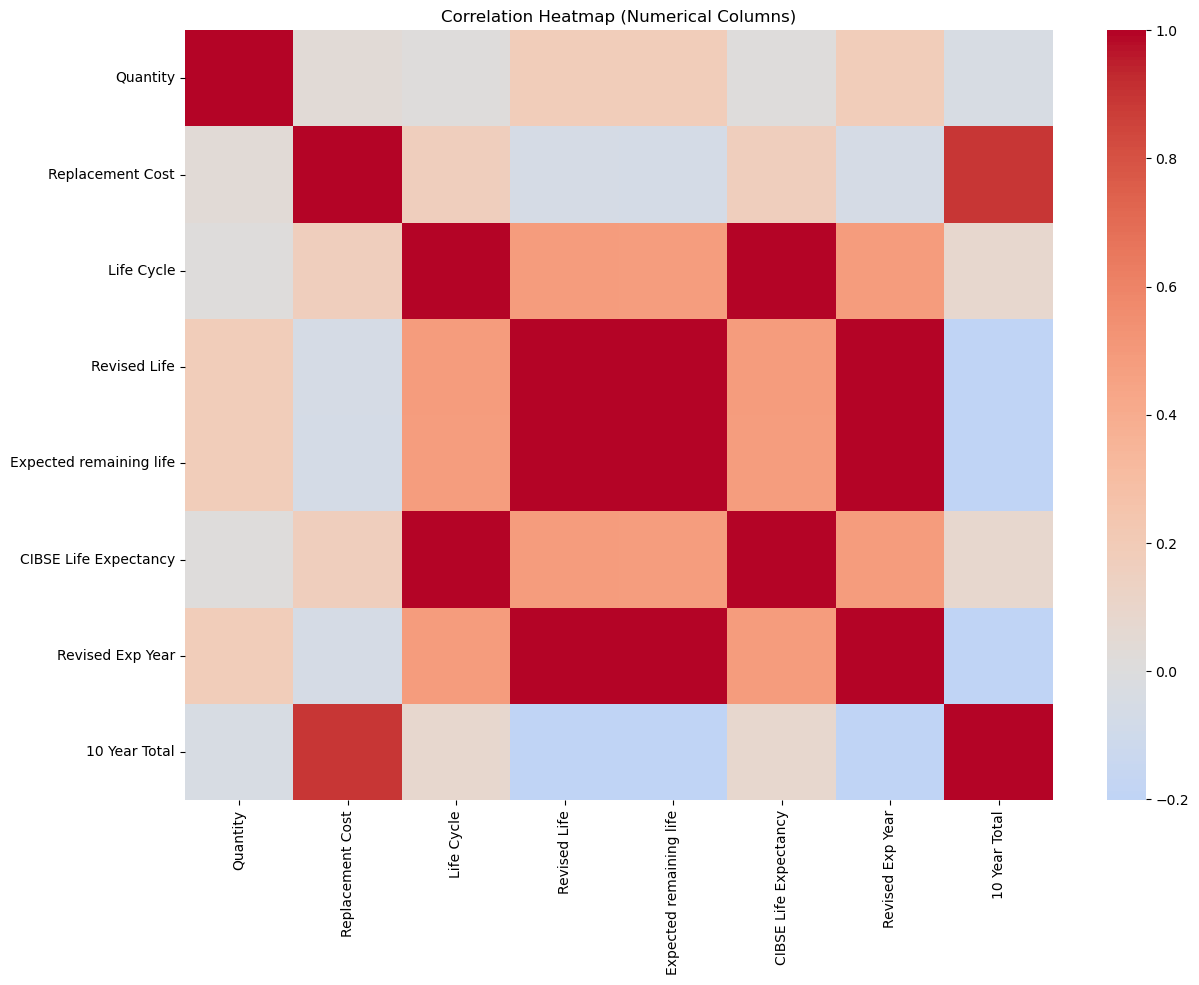

In [23]:
# Heatmap for initial inspection of relationships
plt.figure(figsize=(14,10))
corr = df_assets.select_dtypes(include=["float", "int"]).corr()

sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numerical Columns)")
plt.show()


In [24]:
# Compute correlation matrix (numeric cols only)
corr = df_assets.select_dtypes(include=["float", "int"]).corr()

# Unstack into pairs and sort
corr_pairs = (
    corr.unstack()
    .sort_values(ascending=False)
    .drop_duplicates()   # drop mirror duplicates + self correlations
)

# Filter for strong correlations
strong_corr = corr_pairs[(corr_pairs > 0.9) & (corr_pairs < 1.0)]

print("Strongly correlated pairs (corr > 0.9):")
print(strong_corr.head(20))

Strongly correlated pairs (corr > 0.9):
Revised Exp Year         Revised Life               1.000000
Revised Life             Expected remaining life    0.998566
Expected remaining life  Revised Exp Year           0.998566
dtype: float64


# Feature Engineering - Introduce Criticality Score and Descripton

In [25]:
# Quick Check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B         1   
1    ASSET_0000002                  Urgent         B         2   
2    ASSET_0000003                  Urgent         B         2   
3    ASSET_0000004                     Low         B         1   
4    ASSET_0000005                  Medium         B         2   

   Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0                75          10             3                        3   
1              3000          15             8                        8   
2               392          15             8                        8   
3               350          20            13                       13   
4               600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
0                     10              2027   True           75.0   
1                     15              2032   True         3000.0   
2                     15              2032   True          392.0   
3                     20              2037   True            0.0   
4                     20              2030   True          600.0   

               Our Category 1  Our Category 2  25+ Years  15+ Years  
0  Communications and Control   Comms Systems      False      False  
1                    Security         Systems      False      False  
2                        Fire  Fire Detection      False      False  
3                    Sanitary        Sanitary      False      False  
4                    Sanitary        Sanitary      False       True

# Feature Engineering - Continue creating scoring systems

In [26]:
# Inspecting Unique Asset Types
df_assets['Type'].unique()

array(['Emergency Communication Systems', 'Security Systems',
       'Fire Detection', 'Cleaners Sinks',
       'WC Toilet Standard / All Types', 'WC Toilet Disabled / All Types',
       'Lifts', 'Specialist Lighting', 'Fire Fighting', 'LV Distribution',
       'Ductwork', 'Heat Emitters - Local', 'Local Hot Water', 'System',
       'Fan', 'Lighting', 'Superstructure', 'Barriers and Guardrails',
       'Equipment', 'Hand Dryers', 'Central Air Conditioning',
       'Central Heating (Internally Sourced)', 'Local Air Conditioning',
       'Multi-System Controls', 'Communication Systems', 'Access',
       'Heat Emitters - Central', 'Local and Special Ventilation',
       'Building Management System (BMS)', 'Ventilation',
       'Central Hot Water Distribution', 'Hot Water Distribution', 'Pump',
       'External Drainage', 'Foul Drainage', 'Power Generation',
       'Smoke Extract', 'Distribution Systems',
       'Fire suppression systems', 'Sinks / basins', 'Shower',
       'Commercial San

In [27]:
# Condition mapping
# Updated Condition mapping (DX most urgent)
condition_map = {
    "DX": 1,   # D + beyond repair
    "CX": 2,   # C + beyond repair
    "D": 3,    # Very Poor
    "C": 4,    # Poor
    "B": 5,    # Average
    "A": 6,    # Good
    "X": 1     # standalone 'X' -> treat as most urgent
}

# Criticality Description mapping stays the same
critdesc_map = {
    "URGENT": 1,
    "HIGH":   2,
    "MEDIUM": 3,
    "LOW":    4,
    "V LOW":  4
}

In [28]:
# Condition Score 
cond_clean = df_assets["Condition"].astype(str).str.strip().str.upper()
df_assets["Condition Score"] = cond_clean.map(condition_map).astype("Int64")

unmapped_condition = cond_clean[df_assets["Condition Score"].isna()].unique()
if len(unmapped_condition) > 0:
    print("Unmapped Condition values:", unmapped_condition)


# Criticality Description Score
critdesc_clean = df_assets["Criticality description"].astype(str).str.strip().str.upper()
df_assets["Criticality Description Score"] = critdesc_clean.map(critdesc_map).astype("Int64")

unmapped_critdesc = critdesc_clean[df_assets["Criticality Description Score"].isna()].unique()
if len(unmapped_critdesc) > 0:
    print("Unmapped Criticality Description values:", unmapped_critdesc)


In [29]:
# Quick Check
print(df_assets[["Condition", "Condition Score"]].drop_duplicates())
print(df_assets[["Criticality description", "Criticality Description Score"]].drop_duplicates())


    Condition  Condition Score
0           B                5
35          D                3
38         CX                2
67          C                4
74         DX                1
132         A                6
   Criticality description  Criticality Description Score
0                   Urgent                              1
3                      Low                              4
4                   Medium                              3
10                    High                              2
26                   V Low                              4


In [30]:
# Quick Check
df_assets.tail()

Facility ID   Facility Facility General Location System  Type  \
33881     Unknown  SITE_1770                  Town AGD   Roof  Roof   
33882     Unknown  SITE_1771                   Town PT   Roof  Roof   
33883     Unknown  SITE_1175                   Town XE   Roof  Roof   
33884     Unknown  SITE_1772                  Town AGE   Roof  Roof   
33885     Unknown  SITE_1773                   Town II   Roof  Roof   

         System full path   Asset type Category Asset ID/Barcode  \
33881  Roof | Roof | Roof  Roof Fabric     Roof    ASSET_0033882   
33882  Roof | Roof | Roof  Roof Fabric     Roof    ASSET_0033883   
33883  Roof | Roof | Roof  Roof Fabric     Roof    ASSET_0033884   
33884  Roof | Roof | Roof  Roof Fabric     Roof    ASSET_0033885   
33885  Roof | Roof | Roof  Roof Fabric     Roof    ASSET_0033886   

      Criticality description Condition  Quantity  Replacement Cost  \
33881                     Low         B         1             57384   
33882                  Medium         C         1             25300   
33883                  Urgent        DX         1            132000   
33884                     Low         B         1             57384   
33885                     Low         B         1             57384   

       Life Cycle  Revised Life  Expected remaining life  \
33881          25            11                       10   
33882          25             6                        5   
33883          25             1                        0   
33884          25            11                       10   
33885          25            11                       10   

       CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
33881                     25              2035   True            0.0   
33882                     25              2030   True        25300.0   
33883                     25              2025   True       132000.0   
33884                     25              2035   True            0.0   
33885                     25              2035   True            0.0   

      Our Category 1 Our Category 2  25+ Years  15+ Years  Condition Score  \
33881           Roof           Roof      False       True                5   
33882           Roof           Roof      False       True                4   
33883           Roof           Roof       True      False                1   
33884           Roof           Roof      False       True                5   
33885           Roof           Roof      False       True                5   

       Criticality Description Score  
33881                              4  
33882                              3  
33883                              1  
33884                              4  
33885                              4

In [31]:
# Quick Check
df_assets['Condition Score'].isnull().sum()

np.int64(0)

In [32]:
# Quick Check
df_assets['Criticality Description Score'].isnull().sum()

np.int64(0)

In [33]:
# Equal-weight ranking using rescaled Condition Score 

# 1) Check the required columns exist
score_cols = ["Condition Score", "Criticality Description Score"]
_missing = [c for c in score_cols if c not in df_assets.columns]
if _missing:
    raise KeyError(f"Missing required scoring columns: {_missing}")

# 2) Rescale Condition Score from 1..6  →  1..4
# (keeps ordering DX < CX < D < C < B < A)
cond_scaled = 1 + (df_assets["Condition Score"].astype(float) - 1) * (3/5)

# 3) Combined score with true 50/50 weight
df_assets["Combined Score (Equal)"] = (
    0.5 * cond_scaled +
    0.5 * df_assets["Criticality Description Score"].astype(float)
)

# 4) Global ranking: lower score = higher replacement priority
df_assets["Replacement Rank"] = (
    df_assets["Combined Score (Equal)"]
      .rank(method="first", ascending=True)    # 1 = most urgent
      .astype(int)
)

# 5) Quick preview of the top 10 highest-priority assets
preview_cols = [
    "Replacement Rank",
    "Asset ID/Barcode",
    "Type",
    "Condition Score",
    "Criticality Description Score",
    "Combined Score (Equal)"
]
print(
    df_assets[preview_cols]
      .sort_values("Replacement Rank")
      .head(10)
)


       Replacement Rank Asset ID/Barcode  \
2907                  1    ASSET_0002908   
3117                  2    ASSET_0003118   
3655                  3    ASSET_0003656   
6237                  4    ASSET_0006238   
6242                  5    ASSET_0006243   
8017                  6    ASSET_0008018   
8084                  7    ASSET_0008085   
8619                  8    ASSET_0008620   
9020                  9    ASSET_0009021   
13452                10    ASSET_0013453   

                                       Type  Condition Score  \
2907                         Fire Detection                1   
3117                         Fire Detection                1   
3655                         Superstructure                1   
6237   Central Heating (Internally Sourced)                1   
6242                         Fire Detection                1   
8017                               Ductwork                1   
8084                               Ductwork                1   
861

In [34]:
# Quick Check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B         1   
1    ASSET_0000002                  Urgent         B         2   
2    ASSET_0000003                  Urgent         B         2   
3    ASSET_0000004                     Low         B         1   
4    ASSET_0000005                  Medium         B         2   

   Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0                75          10             3                        3   
1              3000          15             8                        8   
2               392          15             8                        8   
3               350          20            13                       13   
4               600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
0                     10              2027   True           75.0   
1                     15              2032   True         3000.0   
2                     15              2032   True          392.0   
3                     20              2037   True            0.0   
4                     20              2030   True          600.0   

               Our Category 1  Our Category 2  25+ Years  15+ Years  \
0  Communications and Control   Comms Systems      False      False   
1                    Security         Systems      False      False   
2                        Fire  Fire Detection      False      False   
3                    Sanitary        Sanitary      False      False   
4                    Sanitary        Sanitary      False       True   

   Condition Score  Criticality Description Score  Combined Score (Equal)  \
0                5                              1                     2.2   
1                5                              1                     2.2   
2                5                              1                     2.2   
3                5                              4                     3.7   
4                5                              3                     3.2   

   Replacement Rank  
0              1373  
1              1374  
2              1375  
3             32634  
4             19658

In [35]:
# Quick Check
df_assets["Criticality description"].value_counts(dropna=False)


Criticality description
Medium    14972
Urgent     9482
High       8120
Low         794
V Low       518
Name: count, dtype: int64

In [36]:
# Normalise to the same form used in the join
unmapped = df_assets.loc[df_assets["Criticality description"] == "Unknown", "System full path"].unique()

print(f"{len(unmapped)} system paths not mapped:")
print(unmapped[:20])   # show first 20 for inspection


0 system paths not mapped:
[]


In [37]:
# Quick Check
df_assets.query("`System full path` == 'Fire | Detection | Smoke Detector'")[["System full path", "Criticality description"]]


Empty DataFrame
Columns: [System full path, Criticality description]
Index: []

In [38]:
# Get unique System full path + Criticality description combinations
# 1) Build the unique mapping

PROJECT_ROOT = Path.cwd().resolve().parents[0]   # from earlier cell
DATA_PROCESSED = PROJECT_ROOT / "data-processed"

unique_mapping = (
    df_assets[["System full path", "Criticality description"]]
    .drop_duplicates()
    .sort_values("System full path")
    .reset_index(drop=True)
)

# 2) Save into data-processed (relative to project root)
output_path = DATA_PROCESSED / "system_full_path_mapping.xlsx"

unique_mapping.to_excel(output_path, index=False)

print(f"Exported {len(unique_mapping)} unique mappings to {output_path}")


✅ Exported 258 unique mappings to C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-processed\system_full_path_mapping.xlsx


In [39]:
# Quick Check
df_assets[["System full path", "Criticality description"]].sample(10, random_state=1)


System full path  \
9499   Fabric | Superstructure | Windows and External...   
18700  Fabric | Superstructure | Windows and External...   
12908   Fire | Fire Fighting | Fire Extinguishers | Foam   
30241         Electrical | Lighting | Internal | General   
12321  Fabric | Superstructure | Windows and External...   
33671                                 Roof | Roof | Roof   
2046   HVAC | Central Heating (Internally Sourced) | ...   
30885  Electrical | LV Distribution | Distribution Bo...   
28883  HVAC | Fan | Local and Special Ventilation | A...   
18900  HVAC | Fan | Local and Special Ventilation | E...   

      Criticality description  
9499                     High  
18700                  Urgent  
12908                  Urgent  
30241                  Medium  
12321                    High  
33671                  Medium  
2046                     High  
30885                    High  
28883                  Medium  
18900                  Medium

In [40]:
# Add column 'Exp Year Ranking' to provide ranking by year of expiry 

# 0) Choose the existing overall rank column 
base_rank_col = "Replacement Rank"  # or "Rank (Equal)" if that's what you have
if base_rank_col not in df_assets.columns:
    raise KeyError(f"Base rank column '{base_rank_col}' not found.")

# 1) Build a numeric year key (NaNs go last)
year_key = pd.to_numeric(df_assets["Revised Exp Year"], errors="coerce")

# 2) Determine the order: earliest year first, then current rank
order_index = (
    df_assets
    .assign(_year_key=year_key)
    .sort_values(by=["_year_key", base_rank_col],
                 ascending=[True, True],
                 na_position="last")
    .index
)

# 3) Create the Exp Year Ranking without reordering the DataFrame
exp_rank_series = pd.Series(range(1, len(df_assets) + 1), index=order_index)
df_assets["Exp Year Ranking"] = exp_rank_series.reindex(df_assets.index).astype("Int64")

# 4) (Optional) quick peek of the top 10 by Exp Year Ranking
cols = ["Exp Year Ranking", "Revised Exp Year", base_rank_col, "Asset ID/Barcode", "Type"]
print(df_assets[cols].sort_values("Exp Year Ranking").head(10))


       Exp Year Ranking  Revised Exp Year  Replacement Rank Asset ID/Barcode  \
2907                  1              2025                 1    ASSET_0002908   
3655                  2              2025                 3    ASSET_0003656   
6242                  3              2025                 5    ASSET_0006243   
8017                  4              2025                 6    ASSET_0008018   
8084                  5              2025                 7    ASSET_0008085   
8619                  6              2025                 8    ASSET_0008620   
15548                 7              2025                12    ASSET_0015549   
25005                 8              2025                15    ASSET_0025006   
26314                 9              2025                16    ASSET_0026315   
31438                10              2025                18    ASSET_0031439   

                      Type  
2907        Fire Detection  
3655        Superstructure  
6242        Fire Detection  
801

In [41]:
# Desired export columns
export_cols = [
    "System full path",
    "Quantity",
    "Criticality description",
    "Condition",
    "Revised Life",
    "Revised Exp Year",
    "Condition Score",
    "Criticality Description Score",
    "Combined Score (Equal)",
    "Replacement Rank",
    "Exp Year Ranking",
]

# Check which columns exist
present = [c for c in export_cols if c in df_assets.columns]
missing = [c for c in export_cols if c not in df_assets.columns]

if missing:
    print("Skipping missing columns:", missing)

# Export path in the project structure (best practice for GitHub)
output_path = DATA_PROCESSED / "df_assets_cleaned.xlsx"

# Save
df_assets.to_excel(output_path, index=False, columns=present)

print(f"✅ File written to: {output_path.resolve()}")






✅ File written to: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-processed\df_assets_cleaned.xlsx


# FEATURE ENGINEERING FOR ASSET DESCRIPTION

In [42]:
# In excel, the system full path column was cleaned 
# and the 'Revised Asset Description' & 'Revised Asset Detail' columns were created.
# This excel file was then brought back into the notebook 
# and the new columns were mapped using the system full path column as the unique Identifier

In [43]:
# Bringing excel file back into notebook
# Ensure PROJECT_ROOT is defined once at top of notebook
PROJECT_ROOT = Path("..").resolve()

# Folder where the cleaned mapping lives
DATA_PROCESSED = PROJECT_ROOT / "data-processed"

# File to load
mapping_path = DATA_PROCESSED / "asset_mapping_cleaned.xlsx"

print("Loading:", mapping_path.resolve())

mapping = pd.read_excel(mapping_path)

print("✅ Mapping file loaded:", mapping.shape)


Loading: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-processed\asset_mapping_cleaned.xlsx
✅ Mapping file loaded: (258, 3)


In [44]:
# Mapping New columns using the system full path as UI
df_assets = df_assets.merge(
    mapping[["System full path", "Revised Asset Description", "Revised Asset Detail"]],
    on="System full path",
    how="left"       # keep all rows in df_assets; unmatched get NaN
)


In [45]:
# Quick Check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B         1   
1    ASSET_0000002                  Urgent         B         2   
2    ASSET_0000003                  Urgent         B         2   
3    ASSET_0000004                     Low         B         1   
4    ASSET_0000005                  Medium         B         2   

   Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0                75          10             3                        3   
1              3000          15             8                        8   
2               392          15             8                        8   
3               350          20            13                       13   
4               600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
0                     10              2027   True           75.0   
1                     15              2032   True         3000.0   
2                     15              2032   True          392.0   
3                     20              2037   True            0.0   
4                     20              2030   True          600.0   

               Our Category 1  Our Category 2  25+ Years  15+ Years  \
0  Communications and Control   Comms Systems      False      False   
1                    Security         Systems      False      False   
2                        Fire  Fire Detection      False      False   
3                    Sanitary        Sanitary      False      False   
4                    Sanitary        Sanitary      False       True   

   Condition Score  Criticality Description Score  Combined Score (Equal)  \
0                5                              1                     2.2   
1                5                              1                     2.2   
2                5                              1                     2.2   
3                5                              4                     3.7   
4                5                              3                     3.2   

   Replacement Rank  Exp Year Ranking        Revised Asset Description  \
0              1373             13268  Emergency Communication Systems   
1              1374             20254                 Security Systems   
2              1375             20255              Fire Safety Systems   
3             32634             27310                         Sanitary   
4             19658          

In [46]:
# Exporting the dataframe to an excel file once again
PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data-processed"

# Define output path inside data-processed folder
output_path = DATA_PROCESSED / "df_assets_final.xlsx"

# Save file
df_assets.to_excel(output_path, index=False)

print(f"File written to: {output_path.resolve()}")

✅ File written to: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-processed\df_assets_final.xlsx


In [47]:
# Fix Duplicates after Merge
print(f"Rows now: {len(df_assets):,}")

# A. Exact duplicate rows (all columns identical)
num_full_dups = df_assets.duplicated(keep=False).sum()
print(f"Exact duplicate rows (all columns same): {num_full_dups:,}")

# B. Duplicates by asset identifier (should be unique if present)
if "Asset ID/Barcode" in df_assets.columns:
    id_dups = (
        df_assets["Asset ID/Barcode"]
        .astype("string")
        .str.strip()
        .value_counts()
    )
    num_id_dups = (id_dups > 1).sum()
    print(f"IDs appearing more than once: {num_id_dups:,}")


Rows now: 36,718
Exact duplicate rows (all columns same): 3,776
IDs appearing more than once: 944


In [48]:
# 1) Inspect how many exact-duplicate rows exist (all columns identical)
dup_mask = df_assets.duplicated(keep=False)   # marks all members of duplicate groups
print(f"Exact-duplicate rows (including originals): {dup_mask.sum():,}")

# 2) Drop exact duplicates, keep the first occurrence
before = len(df_assets)
df_assets = df_assets.drop_duplicates(keep="first").reset_index(drop=True)
after = len(df_assets)

print(f"Removed {before - after:,} exact-duplicate rows. New row count: {after:,}")


Exact-duplicate rows (including originals): 3,776
✅ Removed 2,832 exact-duplicate rows. New row count: 33,886


# FEATURE ENGINEERING FOR FACILITY LOCATION

In [49]:
# Check performance by MOST EXPSENSIVE faclity location
location_cost = df_assets.groupby('Facility General Location')['10 Year Total'].sum().sort_values(ascending= False)
location_cost_dict = location_cost.to_dict()

location_cost.head(10)

Facility General Location
Town JC    1160713.0
Town E     1146566.0
Town EK    1096823.0
Town A      989734.0
Town RZ     975340.0
Town AJ     955828.0
Town BI     936640.0
Town AQ     871242.0
Town CA     859700.0
Town HU     831748.0
Name: 10 Year Total, dtype: float64

In [50]:
# Check performance by LEAST EXPSENSIVE faclity location
location_cost.tail(10).sort_values(ascending=True)

Facility General Location
Town AEV    0.0
Town AEU    0.0
Town YH     0.0
Town AEF    0.0
Town YK     0.0
Town AAJ    0.0
Town AAH    0.0
Town YR     0.0
Town AAC    0.0
Town ZZ     0.0
Name: 10 Year Total, dtype: float64

# BACK TO EXPLORATORY DATA ANALYSIS (EDA) FOR NEW AND IMPROVED DATAFRAME

In [51]:
# Investigate the replacement cost per category
# 1) Group by category and sum replacement costs
costs_by_category = (
    df_assets.groupby("Revised Asset Description")["10 Year Total"]
    .sum()
    .sort_values(ascending=False)
)

# 2) Compute the average total replacement cost across categories
average_cost = costs_by_category.mean()

print(f"Average total replacement cost per category: £{average_cost:,.0f}\n")

# 3) Compute absolute deviation and percentage deviation
deviation = (costs_by_category - average_cost).abs()
percent_deviation = ((costs_by_category - average_cost) / average_cost) * 100

# 4) Sort by smallest absolute deviation (closest to average)
closest_to_average = deviation.sort_values().head(5)

# 5) Print results neatly
print("Categories with replacement costs closest to the average:\n")
for category in closest_to_average.index:
    total_cost = costs_by_category[category]
    diff = total_cost - average_cost
    pct_diff = percent_deviation[category]
    sign = "+" if pct_diff > 0 else ""
    print(f" - {category}: £{total_cost:,.0f}  ({sign}{pct_diff:.2f}% from average)")

# Summary
print(f"\nTotal unique categories: {len(costs_by_category)}")


💰 Average total replacement cost per category: £2,600,666

✅ Categories with replacement costs closest to the average:

 - Central Ventilation Systems: £2,615,235  (+0.56% from average)
 - Boiler: £2,499,296  (-3.90% from average)
 - General Lighting: £2,784,600  (+7.07% from average)
 - Burner: £2,147,050  (-17.44% from average)
 - AHU -  Internal: £2,049,000  (-21.21% from average)

Total unique categories: 44


In [52]:
# Inspect statistics for categories
# 1) Aggregate by category (ensure numeric)
cost_col = "10 Year Total"
cat_col  = "Revised Asset Description"

df_assets[cost_col] = pd.to_numeric(df_assets[cost_col], errors="coerce")
costs_by_category = (
    df_assets.groupby(cat_col, dropna=False)[cost_col]
    .sum()
    .sort_values(ascending=False)
)

# 2) Rank by cost (most expensive = rank 1) and compute rank percent 
n = len(costs_by_category)
rank = np.arange(1, n + 1)                      # 1..n in sorted order
rank_pct = rank / n * 100.0                     # 0–100%

# 3) Assign percentage brackets by rank percentile
bins    = [0, 25, 50, 75, 100]
labels  = [
    "Top 1–25% (most expensive)",
    "26–50%",
    "51–75%",
    "76–100% (least expensive)"
]
bracket = pd.cut(rank_pct, bins=bins, labels=labels, include_lowest=True, right=True)

# 4) Assemble results DataFrame
out = pd.DataFrame({
    cat_col: costs_by_category.index,
    "Total_10yr_Cost": costs_by_category.values,
    "Rank": rank,
    "Rank_%": rank_pct,
    "Cost Bracket": bracket
})

# 5) Sanity check: average cost per bracket should decrease by bracket
summary = (out.groupby("Cost Bracket")["Total_10yr_Cost"]
             .agg(Count="count", Sum="sum", Mean="mean", Median="median")
             .reset_index())

# 6) Print results
print("Bracket summary (by category totals):")
print(summary.to_string(index=False))

# Examples of top categories er bracket:
print("\nTop 5 categories in each bracket by cost:")
for b in labels:
    subset = out[out["Cost Bracket"] == b].head(15)
    if not subset.empty:
        print(f"\n— {b} —")
        for _, r in subset.iterrows():
            print(f"  {r[cat_col]}: £{r['Total_10yr_Cost']:,.0f} (rank {int(r['Rank'])})")


Bracket summary (by category totals):
              Cost Bracket  Count         Sum         Mean    Median
Top 1–25% (most expensive)     11 101852653.0 9.259332e+06 5534850.0
                    26–50%     11  11079570.0 1.007234e+06  994950.0
                    51–75%     11   1473307.0 1.339370e+05  133500.0
 76–100% (least expensive)     11     23786.0 2.162364e+03     950.0

Top 5 categories in each bracket by cost:

— Top 1–25% (most expensive) —
  Roof: £41,368,596 (rank 1)
  Roller Shutters: £17,094,000 (rank 2)
  Heat Emitters: £7,918,682 (rank 3)
  LV Distribution: £6,986,179 (rank 4)
  Air Conditioning: £6,596,855 (rank 5)
  Lifts: £5,534,850 (rank 6)
  Fire Safety Systems: £4,982,641 (rank 7)
  Local and Special Ventilation: £3,471,719 (rank 8)
  General Lighting: £2,784,600 (rank 9)
  Central Ventilation Systems: £2,615,235 (rank 10)
  Boiler: £2,499,296 (rank 11)

— 26–50% —
  Burner: £2,147,050 (rank 12)
  AHU -  Internal: £2,049,000 (rank 13)
  Access Control: £1,285,3

C:\Users\RoryO'Brien\AppData\Local\Temp\ipykernel_11116\1941071978.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (out.groupby("Cost Bracket")["Total_10yr_Cost"]


In [53]:
# Inspect statistics for categories
# 1) Group by category and sum replacement costs
costs_by_category = (
    df_assets.groupby("Revised Asset Description")["10 Year Total"]
    .sum()
    .sort_values(ascending=True)  # ascending → lowest first
)

# 2) Compute the average total replacement cost
average_cost = costs_by_category.mean()

print(f"Average total replacement cost per category: £{average_cost:,.0f}\n")

# 3) Compute percentage deviation from the mean
percent_deviation = ((costs_by_category - average_cost) / average_cost) * 100

# 4) Get the lowest 10 categories by total cost
lowest_categories = costs_by_category.head(10)

# 5) Print results
print("Lowest total replacement cost categories:\n")
for category in lowest_categories.index:
    total_cost = costs_by_category[category]
    pct_diff = percent_deviation[category]
    print(f" - {category}: £{total_cost:,.0f}  ({pct_diff:.2f}% from average)")

# Summary
print(f"\nTotal unique categories: {len(costs_by_category)}")


Average total replacement cost per category: £2,600,666

Lowest total replacement cost categories:

 - Roads, Paths and Paving's: £0  (-100.00% from average)
 - Solar Power Generation : £0  (-100.00% from average)
 - Mains Water Supply: £0  (-100.00% from average)
 - Emergency Communication Systems: £150  (-99.99% from average)
 - Specialist Piped Systems: £750  (-99.97% from average)
 - Domestic Kitchen: £950  (-99.96% from average)
 - Fuel Systems: £2,450  (-99.91% from average)
 - Sanitary: £3,300  (-99.87% from average)
 - Foul Drainage: £4,008  (-99.85% from average)
 - External Drainage: £6,000  (-99.77% from average)

Total unique categories: 44


In [54]:
# Inspect statistics for categories
# 1) Group by category: sum replacement cost & count assets
summary = (
    df_assets.groupby("Revised Asset Description")
    .agg({
        "Replacement Cost": "sum",
        "Asset ID/Barcode": "count"  # or use another unique ID column if available
    })
    .rename(columns={"Replacement Cost": "Total Replacement Cost", "Asset ID/Barcode": "Asset Count"})
    .sort_values("Total Replacement Cost", ascending=True)
)

# 2) ompute the average total replacement cost across categories
average_cost = summary["Total Replacement Cost"].mean()

print(f"Average total replacement cost per category: £{average_cost:,.0f}\n")

# 3) Compute % deviation from the average
summary["% Deviation from Avg"] = ((summary["Total Replacement Cost"] - average_cost) / average_cost) * 100

# 4) Get the 10 lowest-cost categories
lowest_categories = summary.head(10)

# 5) Print formatted output
print("Lowest total replacement cost categories:\n")
for category, row in lowest_categories.iterrows():
    total_cost = row["Total Replacement Cost"]
    count = row["Asset Count"]
    pct_diff = row["% Deviation from Avg"]
    print(f" - {category}: £{total_cost:,.0f}  ({pct_diff:.2f}% from average) — {count} assets")

# Optional summary
print(f"\nTotal unique categories: {len(summary)}")


Average total replacement cost per category: £3,668,415

Lowest total replacement cost categories:

 - Emergency Communication Systems: £150  (-100.00% from average) — 2 assets
 - Mains Water Supply: £250  (-99.99% from average) — 1 assets
 - Specialist Piped Systems: £1,500  (-99.96% from average) — 2 assets
 - Roads, Paths and Paving's: £2,000  (-99.95% from average) — 1 assets
 - Solar Power Generation : £3,100  (-99.92% from average) — 8 assets
 - Fuel Systems: £3,400  (-99.91% from average) — 10 assets
 - Domestic Kitchen: £3,500  (-99.90% from average) — 8 assets
 - Foul Drainage: £4,008  (-99.89% from average) — 6 assets
 - Sanitary: £5,450  (-99.85% from average) — 13 assets
 - Cold Water Distribution: £6,178  (-99.83% from average) — 2 assets

Total unique categories: 44


In [55]:
# Inspect statistics for categories
# 1) Count number of assets per category
category_counts = df_assets["Revised Asset Description"].value_counts()

# 2) Compute average (mean) count
average_count = category_counts.mean()

print(f"Average asset count per category: {average_count:.2f}\n")

# 3) Find categories that are around the average (e.g. within ±10%)
tolerance = 0.10  # 10% above/below average
lower_bound = average_count * (1 - tolerance)
upper_bound = average_count * (1 + tolerance)

avg_categories = category_counts[
    (category_counts >= lower_bound) & (category_counts <= upper_bound)
]

# 4️) Display results neatly
print("Categories near the average count (±10%):")
print(avg_categories.sort_values(ascending=False))

# Summary
print(f"\nTotal categories: {len(category_counts)}")
print(f"Categories near average: {len(avg_categories)}")


Average asset count per category: 770.14

Categories near the average count (±10%):
Series([], Name: count, dtype: int64)

Total categories: 44
Categories near average: 0


In [56]:
# Inspect statistics for categories
# 1️) Group by category → sum cost + count assets
summary = (
    df_assets.groupby("Revised Asset Description")
    .agg({
        "Replacement Cost": "sum",
        "Asset ID/Barcode": "count"
    })
    .rename(columns={
        "Replacement Cost": "Total Replacement Cost",
        "Asset ID/Barcode": "Asset Count"
    })
)

# 2️) Calculate the overall average asset count
average_asset_count = summary["Asset Count"].mean()
print(f"Average asset count per category: {average_asset_count:.0f}\n")

# 3️) Filter to only include categories with at least the average number of assets
filtered = summary[summary["Asset Count"] >= average_asset_count]

# 4️) Compute average replacement cost across all categories (for % deviation)
average_cost = summary["Total Replacement Cost"].mean()
summary["% Deviation from Avg Cost"] = ((summary["Total Replacement Cost"] - average_cost) / average_cost) * 100

# 5️) Sort by lowest total cost among the filtered set
lowest_filtered = filtered.sort_values("Total Replacement Cost", ascending=True).head(10)

# 6️) Print formatted output
print("Lowest total replacement cost categories (with ≥ average asset count):\n")
for category, row in lowest_filtered.iterrows():
    total_cost = row["Total Replacement Cost"]
    count = row["Asset Count"]
    pct_diff = ((total_cost - average_cost) / average_cost) * 100
    print(f" - {category}: £{total_cost:,.0f}  ({pct_diff:.2f}% from average) — {count} assets")

# Summary
print(f"\nTotal qualifying categories: {len(filtered)} / {len(summary)}")


Average asset count per category: 770

Lowest total replacement cost categories (with ≥ average asset count):

 - Local Hot Water: £413,250  (-88.73% from average) — 1093 assets
 - External Lighting: £469,200  (-87.21% from average) — 921 assets
 - Emergency Lighting: £2,442,215  (-33.43% from average) — 3484 assets
 - Local and Special Ventilation: £3,729,713  (1.67% from average) — 3283 assets
 - External Doors: £5,368,000  (46.33% from average) — 1405 assets
 - Air Conditioning: £7,545,855  (105.70% from average) — 1409 assets
 - Heat Emitters: £8,618,731  (134.94% from average) — 2449 assets
 - LV Distribution: £8,895,257  (142.48% from average) — 3654 assets
 - Fire Safety Systems: £8,968,179  (144.47% from average) — 5671 assets
 - General Lighting: £9,738,300  (165.46% from average) — 2470 assets

Total qualifying categories: 12 / 44


In [57]:
# Inspect statistics for categories
# 1️) Group by category → total cost, asset count
category_summary = (
    df_assets.groupby("Revised Asset Description")
    .agg({
        "10 Year Total": "sum",
        "Asset ID/Barcode": "count"
    })
    .rename(columns={
        "10 Year Total": "Total Replacement Cost",
        "Asset ID/Barcode": "Asset Count"
    })
)

# 2️) Compute average cost per asset
category_summary["Avg Cost per Asset"] = (
    category_summary["Total Replacement Cost"] / category_summary["Asset Count"]
)

# 3️) Rank each metric (1 = best / lowest)
category_summary["Rank by Total Cost"] = category_summary["Total Replacement Cost"].rank(ascending=False)
category_summary["Rank by Asset Count"] = category_summary["Asset Count"].rank(ascending=False)
category_summary["Rank by Avg Cost"] = category_summary["Avg Cost per Asset"].rank(ascending=False)

# 4️) Combined rank (optional — equal weighting)
category_summary["Combined Rank (Equal Weight)"] = (
    category_summary[["Rank by Total Cost", "Rank by Asset Count", "Rank by Avg Cost"]].mean(axis=1)
)

# 5️) Sort by combined rank (or another metric you want to prioritize)
ranked_summary = category_summary.sort_values("Combined Rank (Equal Weight)")

# 6️) Display the top/bottom few
print("Ranked Categories (by total, count, and average cost):\n")
print(
    ranked_summary[
        [
            "Total Replacement Cost",
            "Asset Count",
            "Avg Cost per Asset",
            "Rank by Total Cost",
            "Rank by Asset Count",
            "Rank by Avg Cost",
            "Combined Rank (Equal Weight)"
        ]
    ].head(10)
)


Ranked Categories (by total, count, and average cost):

                               Total Replacement Cost  Asset Count  \
Revised Asset Description                                            
Roof                                       41368596.0          945   
Roller Shutters                            17094000.0         3069   
Air Conditioning                            6596855.0         1409   
Heat Emitters                               7918682.0         2449   
LV Distribution                             6986179.0         3654   
Lifts                                       5534850.0          179   
Central Ventilation Systems                 2615235.0          524   
Boiler                                      2499296.0          378   
Fire Safety Systems                         4982641.0         5671   
Local and Special Ventilation               3471719.0         3283   

                               Avg Cost per Asset  Rank by Total Cost  \
Revised Asset Description     

In [58]:
# Inspect statistics for expiring assets
# Define your year range
years = range(2025, 2035)

# Group by 'Revised Exp Year' and count total assets
assets_per_year = (
    df_assets[df_assets["Revised Exp Year"].isin(years)]
    .groupby("Revised Exp Year")["System full path"]
    .count()
    .rename("Total Assets")
    .sort_index()
)

# Display results
print("Total Assets per Year (2025–2034):\n")
print(assets_per_year.to_string())


Total Assets per Year (2025–2034):

Revised Exp Year
2025    12432
2026      817
2027      484
2028      534
2029     1420
2030     3425
2031     1115
2032      970
2033      740
2034     1297


In [59]:
# Inspect statistics for replacement costs
# Define the year range
years = range(2025, 2035)

# Group by year → sum the replacement cost
cost_per_year = (
    df_assets[df_assets["Revised Exp Year"].isin(years)]
    .groupby("Revised Exp Year")["Replacement Cost"]
    .sum()
    .rename("Total Replacement Cost (£)")
    .sort_index()
)

# Convert to £ millions for readability
cost_per_year_millions = (cost_per_year / 1_000_000).round(2)

# Display results nicely
print("Total Replacement Cost per Year (2025–2034):\n")
print(cost_per_year_millions.to_string())


Total Replacement Cost per Year (2025–2034):

Revised Exp Year
2025    68.71
2026     1.87
2027     1.39
2028     1.35
2029     5.18
2030    23.57
2031      3.5
2032     2.38
2033     1.89
2034     4.54


In [60]:
# Inspect statistics for total assets
# Define year range
years = range(2025, 2035)

# Count number of assets per year
asset_counts = (
    df_assets[df_assets["Revised Exp Year"].isin(years)]
    .groupby("Revised Exp Year")["Asset ID/Barcode"]
    .count()
    .rename("Asset Count")
    .sort_index()
)

# Calculate percentage of total
asset_percentage = (asset_counts / asset_counts.sum() * 100).round(2)
asset_percentage = asset_percentage.rename("% of Total Assets")

# Combine both count + percentage into a single DataFrame
asset_summary = pd.concat([asset_counts, asset_percentage], axis=1)

# Display neatly
print("Asset Distribution by Year (2025–2034):\n")
print(asset_summary.to_string())


Asset Distribution by Year (2025–2034):

                  Asset Count  % of Total Assets
Revised Exp Year                                
2025                    12432              53.51
2026                      817               3.52
2027                      484               2.08
2028                      534               2.30
2029                     1420               6.11
2030                     3425              14.74
2031                     1115               4.80
2032                      970               4.17
2033                      740               3.18
2034                     1297               5.58


In [61]:
# Inspect statistics for replacement costs
# Define the range of years
years = range(2025, 2035)

# Filter to only those years
df_filtered = df_assets[df_assets["Revised Exp Year"].isin(years)]

# Group by year → sum replacement cost
cost_per_year = (
    df_filtered.groupby("Revised Exp Year")["10 Year Total"]
    .sum()
    .sort_index()
)

# Compute percentage of total
cost_percentage = (cost_per_year / cost_per_year.sum() * 100).round(2)

# Combine both into one DataFrame
cost_summary = pd.DataFrame({
    "Total Replacement Cost (£M)": (cost_per_year / 1_000_000).round(2),
    "% of Total Replacement Cost": cost_percentage
})

# Display nicely
print("Replacement Cost Distribution by Year (2025–2034):\n")
print(cost_summary.to_string())


Replacement Cost Distribution by Year (2025–2034):

                  Total Replacement Cost (£M)  % of Total Replacement Cost
Revised Exp Year                                                          
2025                                    68.75                        60.08
2026                                     1.87                         1.63
2027                                     1.39                         1.22
2028                                     1.35                         1.18
2029                                     5.18                         4.52
2030                                    23.57                        20.60
2031                                     3.50                         3.06
2032                                     2.38                         2.08
2033                                     1.89                         1.65
2034                                     4.54                         3.97


In [62]:
# Inspect statistics for categories
# Define your periods
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# Loop through each period
for label, years in periods.items():
    # Filter for the relevant years
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # Count assets per category
    category_counts = (
        df_period["Revised Asset Description"]
        .value_counts()
        .head(5)
    )

    # Print results
    print(f"\nTop 5 Expiring Categories for {label}:\n")
    print(category_counts.to_string())
    print("-" * 50)



Top 5 Expiring Categories for 2025–2027:

Revised Asset Description
Local and Special Ventilation    2159
LV Distribution                  1849
Heat Emitters                    1704
Roller Shutters                  1482
Fire Safety Systems              1226
--------------------------------------------------

Top 5 Expiring Categories for 2028–2030:

Revised Asset Description
Fire Safety Systems              1798
LV Distribution                   553
Local and Special Ventilation     459
Roof                              424
Heat Emitters                     356
--------------------------------------------------

Top 5 Expiring Categories for 2031–2034:

Revised Asset Description
Fire Safety Systems              1225
Local and Special Ventilation     400
Air Conditioning                  349
LV Distribution                   328
Roller Shutters                   291
--------------------------------------------------


In [63]:
# Inspect statistics for categories
# Define the 3 periods
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# Loop through each period
for label, years in periods.items():
    # Filter to relevant years
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # Count assets per detail
    detail_counts = (
        df_period["Revised Asset Detail"]
        .astype(str)
        .str.strip()
        .value_counts()
        .head(5)
    )

    # Print results
    print(f"\nTop 5 Asset Details Expiring ({label}):\n")
    print(detail_counts.to_string(header="Count of Assets"))
    print("-" * 60)



Top 5 Asset Details Expiring (2025–2027):

Revised Asset Detail
Sub Distribution Board            1204
External Manual Roller Shutter     874
Fan - Extract                      812
Electric Heaters                   780
Fan - Axial                        722
------------------------------------------------------------

Top 5 Asset Details Expiring (2028–2030):

Revised Asset Detail
Fire Extinguishers - Foam              711
Fire Extinguishers - CO2               619
Roof                                   424
Sub Distribution Board                 391
General - LED fittings & Luminaires    244
------------------------------------------------------------

Top 5 Asset Details Expiring (2031–2034):

Revised Asset Detail
Fire Extinguishers - Foam              439
Fire Extinguishers - CO2               413
General - LED fittings & Luminaires    195
Sub Distribution Board                 188
Fan - Window / Wall Mounted            178
----------------------------------------------------------

In [64]:
# Inspect statistics for categories
# Define the periods
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# Loop through periods
for label, years in periods.items():
    # Filter data
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # Count assets per detail
    detail_counts = (
        df_period["Revised Asset Description"]
        .astype(str)
        .str.strip()
        .value_counts()
    )

    # Determine threshold for top 10%
    n_top = max(1, int(len(detail_counts) * 0.10))  # at least 1
    top_10pct = detail_counts.head(n_top)

    # Display results
    print(f"\nTop 10% of Asset Description by Count ({label})")
    print(f"Total unique asset details: {len(detail_counts)} | Top 10% cutoff: {n_top}\n")
    print(top_10pct.to_string(header="Count of Assets"))
    print("-" * 70)



Top 10% of Asset Description by Count (2025–2027)
Total unique asset details: 38 | Top 10% cutoff: 3

Revised Asset Description
Local and Special Ventilation    2159
LV Distribution                  1849
Heat Emitters                    1704
----------------------------------------------------------------------

Top 10% of Asset Description by Count (2028–2030)
Total unique asset details: 35 | Top 10% cutoff: 3

Revised Asset Description
Fire Safety Systems              1798
LV Distribution                   553
Local and Special Ventilation     459
----------------------------------------------------------------------

Top 10% of Asset Description by Count (2031–2034)
Total unique asset details: 34 | Top 10% cutoff: 3

Revised Asset Description
Fire Safety Systems              1225
Local and Special Ventilation     400
Air Conditioning                  349
----------------------------------------------------------------------


In [65]:
# Inspect statistics for categories
# Define the periods
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# Loop through periods
for label, years in periods.items():
    # Filter data
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # Count assets per detail
    detail_counts = (
        df_period["Revised Asset Detail"]
        .astype(str)
        .str.strip()
        .value_counts()
    )

    # Determine threshold for top 10%
    n_top = max(1, int(len(detail_counts) * 0.10))  # at least 1
    top_10pct = detail_counts.head(n_top)

    # Display results
    print(f"\nTop 10% of Asset Details by Count ({label})")
    print(f"Total unique asset details: {len(detail_counts)} | Top 10% cutoff: {n_top}\n")
    print(top_10pct.to_string(header="Count of Assets"))
    print("-" * 70)



Top 10% of Asset Details by Count (2025–2027)
Total unique asset details: 174 | Top 10% cutoff: 17

Revised Asset Detail
Sub Distribution Board                                      1204
External Manual Roller Shutter                               874
Fan - Extract                                                812
Electric Heaters                                             780
Fan - Axial                                                  722
General - LED fittings & Luminaires                          605
Main Distribution Board                                      589
Fan - General Ventilation                                    446
Vehicle Crash Protection Barrier                             424
Fan - Window / Wall Mounted                                  370
Fire Extinguishers - CO2                                     319
General - Non LED                                            301
Roof                                                         297
Unit extract fans                

In [66]:
# Inspect statistics for categories
# Define your periods
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# Loop through each period
for label, years in periods.items():
    # Filter for relevant years
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # Group by category and sum total replacement cost
    category_costs = (
        df_period.groupby("Revised Asset Description")["10 Year Total"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .div(1_000_000)  # convert to £ millions
        .round(2)
    )

    # Print results
    print(f"\nTop 5 Most Expensive Categories for {label}:\n")
    print(category_costs.to_string(header="Total Replacement Cost (£M)"))
    print("-" * 60)



Top 5 Most Expensive Categories for 2025–2027:

Revised Asset Description
Roof               24.23
Roller Shutters    12.77
LV Distribution     5.02
Heat Emitters       5.01
Lifts               3.54
------------------------------------------------------------

Top 5 Most Expensive Categories for 2028–2030:

Revised Asset Description
Roof                17.13
Roller Shutters      1.71
Air Conditioning     1.45
Heat Emitters        1.45
Lifts                1.30
------------------------------------------------------------

Top 5 Most Expensive Categories for 2031–2034:

Revised Asset Description
Roller Shutters        2.61
Air Conditioning       1.91
Heat Emitters          1.46
Fire Safety Systems    1.33
General Lighting       0.86
------------------------------------------------------------


In [67]:
# Inspect statistics for categories
# Define your periods
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# Loop through each period
for label, years in periods.items():
    # Filter for relevant years
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # Group by category and sum total replacement cost
    category_costs = (
        df_period.groupby("Revised Asset Detail")["10 Year Total"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .div(1_000_000)  # convert to £ millions
        .round(2)
    )

    # Print results
    print(f"\nTop 5 Most Expensive Types of Assets for {label}:\n")
    print(category_costs.to_string(header="Total Replacement Cost (£M)"))
    print("-" * 60)



Top 5 Most Expensive Types of Assets for 2025–2027:

Revised Asset Detail
Roof                              24.23
External Manual Roller Shutter     7.87
Fan - General Ventilation          3.12
Gas Fired Unit Heaters             2.56
Sub Distribution Board             2.23
------------------------------------------------------------

Top 5 Most Expensive Types of Assets for 2028–2030:

Revised Asset Detail
Roof                                   17.13
Gas Fired Unit Heaters                  0.88
External Manual Roller Shutter          0.78
Passenger Lift Hydraulic - Electric     0.74
Sub Distribution Board                  0.72
------------------------------------------------------------

Top 5 Most Expensive Types of Assets for 2031–2034:

Revised Asset Detail
Gas Fired Unit Heaters                                                                                  0.92
External Manual Roller Shutter                                                                          0.86
General - 

In [68]:
# Inspect statistics for categories
# 1️) Filter to only the years of interest
years = range(2025, 2034)
df_filtered = df_assets[df_assets["Revised Exp Year"].isin(years)]

# 2️) Group by category and sum replacement cost
category_costs = (
    df_filtered.groupby("Revised Asset Description")["10 Year Total"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# 3️) Convert to £ millions
category_costs["Total Cost (£M)"] = category_costs["10 Year Total"] / 1_000_000
category_costs = category_costs[["Revised Asset Description", "Total Cost (£M)"]]

# 4️) Display nicely
print("Total Replacement Cost by Category (2025–2034):\n")
print(category_costs.to_string(index=False, justify="left"))


Total Replacement Cost by Category (2025–2034):

Revised Asset Description        Total Cost (£M)
                           Roof 41.363596       
                Roller Shutters 16.104000       
                  Heat Emitters  7.620632       
                LV Distribution  6.437493       
               Air Conditioning  6.097855       
                          Lifts  5.184850       
            Fire Safety Systems  4.610375       
  Local and Special Ventilation  3.374293       
    Central Ventilation Systems  2.615235       
                         Boiler  2.427796       
                         Burner  2.139550       
               General Lighting  2.009100       
                AHU -  Internal  1.893000       
                 Access Control  1.150300       
          Multi-System Controls  1.130976       
            Specialist Lighting  1.064000       
                            BMS  0.994950       
                 External Doors  0.795000       
          Barriers &

In [69]:
# Inspect statistics for replacement cost
# Total cost using only Replacement Cost for 2025–2034
cost_year_filtered = df_assets.loc[
    df_assets["Revised Exp Year"].between(2025, 2034),
    "Replacement Cost"
].sum()
print(f"Total cost 2025–2034 (Replacement Cost): £{cost_year_filtered/1_000_000:.2f}M")

# Total cost using all rows (no filter)
cost_all = df_assets["Replacement Cost"].sum()
print(f"Total cost ALL years: £{cost_all/1_000_000:.2f}M")

# Check for duplicates
dupes = df_assets[df_assets.duplicated()]
print(f"Duplicate rows: {len(dupes)}")


Total cost 2025–2034 (Replacement Cost): £114.39M
Total cost ALL years: £161.41M
Duplicate rows: 0


In [70]:
# Inspect statistics for categories
# Filter to assets expiring between 2025–2034 only
df_10yr = df_assets[df_assets["Revised Exp Year"].between(2025, 2034)]

# Group and sum
category_costs = (
    df_10yr.groupby("Revised Asset Description")["Replacement Cost"]
    .sum()
    .sort_values(ascending=False)
)

# Convert to millions for readability
category_costs_m = category_costs / 1_000_000

# Verify total
print(f"Total Replacement Cost (2025–2034): £{category_costs_m.sum():.2f}M")

# Show top 10 categories
print("\nTop 10 Categories by Total Cost (2025–2034):\n")
print(category_costs_m.head(10))


Total Replacement Cost (2025–2034): £114.39M

Top 10 Categories by Total Cost (2025–2034):

Revised Asset Description
Roof                             41.368596
Roller Shutters                     17.094
Heat Emitters                     7.880046
LV Distribution                   6.986179
Air Conditioning                  6.596855
Lifts                              5.53485
Fire Safety Systems               4.981441
Local and Special Ventilation     3.471719
General Lighting                    2.7846
Central Ventilation Systems       2.615235
Name: Replacement Cost, dtype: Float64


In [71]:
# Inspect statistics for categories
# Filter to the target period
df_10yr = df_assets[df_assets["Revised Exp Year"].between(2025, 2034)]

# Group by category and sum Replacement Cost
category_costs = (
    df_10yr.groupby("Revised Asset Description")["Replacement Cost"]
    .sum()
    .sort_values(ascending=False)
)

# Convert to £ million for readability
category_costs_m = category_costs / 1_000_000

# Check totals
print(f"Sum of all categories (2025–2034): £{category_costs_m.sum():.2f}M")

# Preview top 10 categories
print("\nTop 10 categories:\n", category_costs_m.head(44))


Sum of all categories (2025–2034): £114.39M

Top 10 categories:
 Revised Asset Description
Roof                               41.368596
Roller Shutters                       17.094
Heat Emitters                       7.880046
LV Distribution                     6.986179
Air Conditioning                    6.596855
Lifts                                5.53485
Fire Safety Systems                 4.981441
Local and Special Ventilation       3.471719
General Lighting                      2.7846
Central Ventilation Systems         2.615235
Boiler                              2.499296
Burner                               2.14705
AHU -  Internal                        2.049
Access Control                        1.2853
Multi-System Controls               1.161192
Specialist Lighting                    1.078
BMS                                  0.99495
External Doors                         0.873
Barriers & Guardrails                0.50785
Local Hot Water                       0.3425
Central H

In [72]:
# Inspect statistics for categories
# 1️) Filter to target period (2025–2034)
df_10yr = df_assets[df_assets["Revised Exp Year"].between(2025, 2034)]

# 2️) Group by category and sum Replacement Cost
category_costs = (
    df_10yr.groupby("Revised Asset Description")["Replacement Cost"]
    .sum()
    .sort_values(ascending=False)
)

# 3️) Convert to £ millions
category_costs_m = category_costs / 1_000_000

# 4️) Calculate % of total
total_cost = category_costs_m.sum()
category_costs_pct = (category_costs_m / total_cost * 100).round(2)

# 5️) Combine into a single DataFrame
category_summary = pd.DataFrame({
    "Total Cost (£M)": category_costs_m.round(2),
    "% of Total": category_costs_pct
}).reset_index()

# 6️) Display summary
print(f"Total Replacement Cost (2025–2034): £{total_cost:.2f}M\n")
print("Top Categories by Cost (with % of Total):\n")
print(category_summary.to_string(index=False, justify='left'))


Total Replacement Cost (2025–2034): £114.39M

Top Categories by Cost (with % of Total):

Revised Asset Description        Total Cost (£M)  % of Total
                           Roof  41.37            36.16     
                Roller Shutters  17.09            14.94     
                  Heat Emitters   7.88             6.89     
                LV Distribution   6.99             6.11     
               Air Conditioning    6.6             5.77     
                          Lifts   5.53             4.84     
            Fire Safety Systems   4.98             4.35     
  Local and Special Ventilation   3.47             3.04     
               General Lighting   2.78             2.43     
    Central Ventilation Systems   2.62             2.29     
                         Boiler    2.5             2.18     
                         Burner   2.15             1.88     
                AHU -  Internal   2.05             1.79     
                 Access Control   1.29             1.12  

In [73]:
# Inspect statistics for categories
# 1️) Filter to valid years only (optional)
df_filtered = df_assets[df_assets["Revised Exp Year"].notna()]

# 2️) Group by year + category and count assets
category_counts = (
    df_filtered.groupby(["Revised Exp Year", "Revised Asset Description"])
    .size()
    .reset_index(name="Asset Count")
)

# 3️) For each year, find the category with the highest count
top_categories = (
    category_counts.loc[
        category_counts.groupby("Revised Exp Year")["Asset Count"].idxmax()
    ]
    .sort_values("Revised Exp Year")
    .reset_index(drop=True)
)

# 4️) Display results
print("Top Category by Asset Count per Year (2025–2034):")
print("----------------------------------------------------")
print(top_categories.to_string(index=False))


Top Category by Asset Count per Year (2025–2034):
----------------------------------------------------
 Revised Exp Year     Revised Asset Description  Asset Count
             2025 Local and Special Ventilation         2055
             2026           Fire Safety Systems          376
             2027                 Heat Emitters          109
             2028           Fire Safety Systems          101
             2029 Local and Special Ventilation          319
             2030           Fire Safety Systems         1478
             2031           Fire Safety Systems          359
             2032           Fire Safety Systems          378
             2033           Fire Safety Systems          318
             2034               LV Distribution          206
             2035           Fire Safety Systems          529
             2036              General Lighting          285
             2037               Roller Shutters           69
             2038               LV Distribu

In [74]:
# Quick check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B         1   
1    ASSET_0000002                  Urgent         B         2   
2    ASSET_0000003                  Urgent         B         2   
3    ASSET_0000004                     Low         B         1   
4    ASSET_0000005                  Medium         B         2   

   Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0                75          10             3                        3   
1              3000          15             8                        8   
2               392          15             8                        8   
3               350          20            13                       13   
4               600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
0                     10              2027   True           75.0   
1                     15              2032   True         3000.0   
2                     15              2032   True          392.0   
3                     20              2037   True            0.0   
4                     20              2030   True          600.0   

               Our Category 1  Our Category 2  25+ Years  15+ Years  \
0  Communications and Control   Comms Systems      False      False   
1                    Security         Systems      False      False   
2                        Fire  Fire Detection      False      False   
3                    Sanitary        Sanitary      False      False   
4                    Sanitary        Sanitary      False       True   

   Condition Score  Criticality Description Score  Combined Score (Equal)  \
0                5                              1                     2.2   
1                5                              1                     2.2   
2                5                              1                     2.2   
3                5                              4                     3.7   
4                5                              3                     3.2   

   Replacement Rank  Exp Year Ranking        Revised Asset Description  \
0              1373             13268  Emergency Communication Systems   
1              1374             20254                 Security Systems   
2              1375             20255              Fire Safety Systems   
3             32634             27310                         Sanitary   
4             19658          

In [75]:
# Discrepancy Inspection 
df = df_assets.copy()

# Ensure numeric cost and a clean year column
df["10 Year Total"] = pd.to_numeric(df["10 Year Total"], errors="coerce")
year = pd.to_numeric(df["Revised Exp Year"], errors="coerce").astype("Int64")
df["Revised Exp Year"] = year

# Buckets for clarity
def year_bucket(y):
    if pd.isna(y):
        return "Missing year"
    return "2025–2034" if 2025 <= y <= 2034 else "Other years"

df["Year Bucket"] = df["Revised Exp Year"].map(year_bucket)

# 1) All-years totals per category
all_years = (df
    .groupby("Revised Asset Description", dropna=False)["10 Year Total"]
    .sum()
    .rename("Total_AllYears")
    .reset_index()
)

# 2) 2025–2034 totals per category
in_window = df["Year Bucket"].eq("2025–2034")
by_2025_2034 = (df.loc[in_window]
    .groupby("Revised Asset Description", dropna=False)["10 Year Total"]
    .sum()
    .rename("Total_2025_2034")
    .reset_index()
)

# 3) Merge and compute differences
cmp = (all_years
       .merge(by_2025_2034, on="Revised Asset Description", how="left")
       .fillna({"Total_2025_2034": 0.0}))

cmp["Diff"] = cmp["Total_AllYears"] - cmp["Total_2025_2034"]
cmp["Diff_%_of_All"] = np.where(
    cmp["Total_AllYears"] != 0,
    100 * cmp["Diff"] / cmp["Total_AllYears"],
    0.0
)

# Show categories where totals differ
diff_rows = cmp[cmp["Diff"].abs() > 0.01].sort_values("Diff", ascending=False)
print("Categories with costs outside 2025–2034 (or missing year):\n")
print(diff_rows.to_string(index=False))

# Optional: see how much per bucket for each category
bucket_breakdown = (df
    .groupby(["Revised Asset Description", "Year Bucket"], dropna=False)["10 Year Total"]
    .sum()
    .reset_index()
    .pivot(index="Revised Asset Description", columns="Year Bucket", values="10 Year Total")
    .fillna(0.0)
    .sort_values("Other years", ascending=False)  # or "Missing year"
)

print("\nPer-category bucket breakdown (2025–2034 vs Other years vs Missing year):\n")
print(bucket_breakdown.to_string())


Categories with costs outside 2025–2034 (or missing year):

Empty DataFrame
Columns: [Revised Asset Description, Total_AllYears, Total_2025_2034, Diff, Diff_%_of_All]
Index: []

Per-category bucket breakdown (2025–2034 vs Other years vs Missing year):

Year Bucket                       2025–2034  Other years
Revised Asset Description                               
AHU -  External                    260000.0          0.0
AHU -  Internal                   2049000.0          0.0
Access Control                    1285300.0          0.0
Air Conditioning                  6596855.0          0.0
BMS                                994950.0          0.0
Barriers & Guardrails              507850.0          0.0
Boiler                            2499296.0          0.0
Burner                            2147050.0          0.0
CCTV                                14807.0          0.0
Central Cooling                    166915.0          0.0
Central Heating                    198787.0          0.0
Centra

In [76]:
# Inspect statistics overview
# 1️) Filter dataset for years 2025–2034
df_period = df_assets[df_assets["Revised Exp Year"].between(2025, 2034)]

# 2️) Group by year and calculate totals
yearly_summary = (
    df_period.groupby("Revised Exp Year")
    .agg(
        Assets_Expiring=("Revised Asset Description", "count"),
        Total_Cost=("Replacement Cost", "sum")
    )
    .sort_index()
    .reset_index()
)

# 3️) Compute totals across all years
total_assets = yearly_summary["Assets_Expiring"].sum()
total_cost = yearly_summary["Total_Cost"].sum()

# 4️) Compute percentages
yearly_summary["% of Total Assets"] = (
    yearly_summary["Assets_Expiring"] / total_assets * 100
).round(2)

yearly_summary["Total Cost (£M)"] = (yearly_summary["Total_Cost"] / 1_000_000).round(2)
yearly_summary["% of Total Cost"] = (
    yearly_summary["Total_Cost"] / total_cost * 100
).round(2)

# 5️) Clean up final display
final_summary = yearly_summary[
    ["Revised Exp Year", "Assets_Expiring", "% of Total Assets",
     "Total Cost (£M)", "% of Total Cost"]
]

# 6️) Print results
print("Asset & Cost Summary (2025–2034):")
print(final_summary.to_string(index=False))

# Optional: Print totals for verification
print(f"\nTotal Assets: {total_assets:,}")
print(f"Total Replacement Cost (2025–2034): £{total_cost/1_000_000:,.2f}M")


Asset & Cost Summary (2025–2034):
 Revised Exp Year  Assets_Expiring  % of Total Assets  Total Cost (£M)  % of Total Cost
             2025            12432              53.51            68.71            60.07
             2026              817               3.52             1.87             1.63
             2027              484               2.08             1.39             1.22
             2028              534               2.30             1.35             1.18
             2029             1420               6.11             5.18             4.53
             2030             3425              14.74            23.57            20.61
             2031             1115               4.80              3.5             3.06
             2032              970               4.17             2.38             2.08
             2033              740               3.18             1.89             1.65
             2034             1297               5.58             4.54             3.9

In [77]:
# Inspect statistics overview
# 1️) Filter dataset for years 2025–2034
df_period = df_assets[df_assets["Revised Exp Year"].between(2025, 2034)]

# 2️) Define the time periods
bins = [2024, 2027, 2030, 2034]
labels = ["Short Term (2025–2027)", "Medium Term (2028–2030)", "Long Term (2031–2034)"]
df_period["Period"] = pd.cut(df_period["Revised Exp Year"], bins=bins, labels=labels, include_lowest=True)

# 3️) Group by period and calculate totals
period_summary = (
    df_period.groupby("Period")
    .agg(
        Assets_Expiring=("Revised Asset Description", "count"),
        Total_Cost=("Replacement Cost", "sum")
    )
    .reset_index()
)

# 4️) Compute totals across all periods
total_assets = period_summary["Assets_Expiring"].sum()
total_cost = period_summary["Total_Cost"].sum()

# 5️) Compute percentages
period_summary["% of Total Assets"] = (
    period_summary["Assets_Expiring"] / total_assets * 100
).round(2)

period_summary["Total Cost (£M)"] = (period_summary["Total_Cost"] / 1_000_000).round(2)
period_summary["% of Total Cost"] = (
    period_summary["Total_Cost"] / total_cost * 100
).round(2)

# 6️) Clean up final display
final_summary = period_summary[
    ["Period", "Assets_Expiring", "% of Total Assets",
     "Total Cost (£M)", "% of Total Cost"]
]

# 7️) Print results
print("Asset & Cost Summary by Period (2025–2034):")
print(final_summary.to_string(index=False))

# Optional totals for verification
print(f"\nTotal Assets: {total_assets:,}")
print(f"Total Replacement Cost (2025–2034): £{total_cost/1_000_000:,.2f}M")


Asset & Cost Summary by Period (2025–2034):
                 Period  Assets_Expiring  % of Total Assets  Total Cost (£M)  % of Total Cost
 Short Term (2025–2027)            13733              59.11            71.97            62.92
Medium Term (2028–2030)             5379              23.15             30.1            26.32
  Long Term (2031–2034)             4122              17.74            12.31            10.76

Total Assets: 23,234
Total Replacement Cost (2025–2034): £114.39M


C:\Users\RoryO'Brien\AppData\Local\Temp\ipykernel_11116\3569662203.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_period["Period"] = pd.cut(df_period["Revised Exp Year"], bins=bins, labels=labels, include_lowest=True)
C:\Users\RoryO'Brien\AppData\Local\Temp\ipykernel_11116\3569662203.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_period.groupby("Period")


In [78]:
# Inspect Statistics for Facility Cost
# 1️) Filter to only the years of interest
years = [2025, 2026, 2027, 2028, 2029, 2030,2031,2032,2033,2034]
df_filtered = df_assets[df_assets["Revised Exp Year"].isin(years)]

# 2️) Group by year + region, sum replacement cost (convert to millions)
region_costs = (
    df_filtered.groupby(["Revised Exp Year", "Facility General Location"])["10 Year Total"]
    .sum()
    .div(1_000_000)  # convert to millions (£M)
    .reset_index()
)

# 3️) Loop through years and print top 10 results
for year in years:
    subset = (
        region_costs[region_costs["Revised Exp Year"] == year]
        .sort_values("10 Year Total", ascending=False)
        .head(10)
    )

    print(f"\nTop 10 Facility Locations by Replacement Cost — {year}")
    print("-" * 70)
    print(subset.to_string(index=False, header=["Revised Exp Year", "Facility / Region", "Replacement Cost (£M)"]))
    print("-" * 70)



Top 10 Facility Locations by Replacement Cost — 2025
----------------------------------------------------------------------
Revised Exp Year Facility / Region Replacement Cost (£M)
            2025           Town EK              0.886918
            2025           Town CA              0.818041
            2025           Town JC              0.784437
            2025           Town HU              0.717516
            2025            Town A              0.665320
            2025            Town E              0.655634
            2025           Town AJ              0.646424
            2025           Town AQ              0.612575
            2025           Town GS              0.582069
            2025           Town AP              0.566301
----------------------------------------------------------------------

Top 10 Facility Locations by Replacement Cost — 2026
----------------------------------------------------------------------
Revised Exp Year Facility / Region Replacement Cost 

# Visualisation 

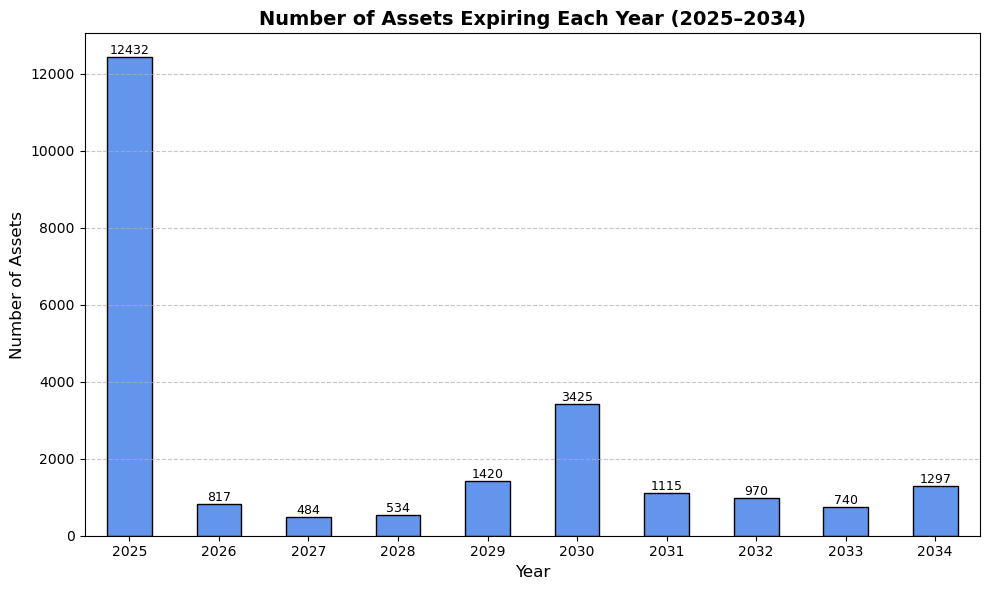

In [79]:
# Graph Asset Expiration
# 1️) Filter dataset for years 2025–2034
df_years = df_assets[df_assets["Revised Exp Year"].between(2025, 2034)]

# 2️) Count assets per year
assets_per_year = (
    df_years["Revised Exp Year"]
    .value_counts()
    .sort_index()
)

# 3️) Plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))
assets_per_year.plot(kind="bar", ax=ax, color="cornflowerblue", edgecolor="black")

# 4️) Titles and labels
ax.set_title("Number of Assets Expiring Each Year (2025–2034)", fontsize=14, weight="bold")
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Assets", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels to 0 degrees (horizontal)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# 5️) Annotate bars with counts
for i, v in enumerate(assets_per_year.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


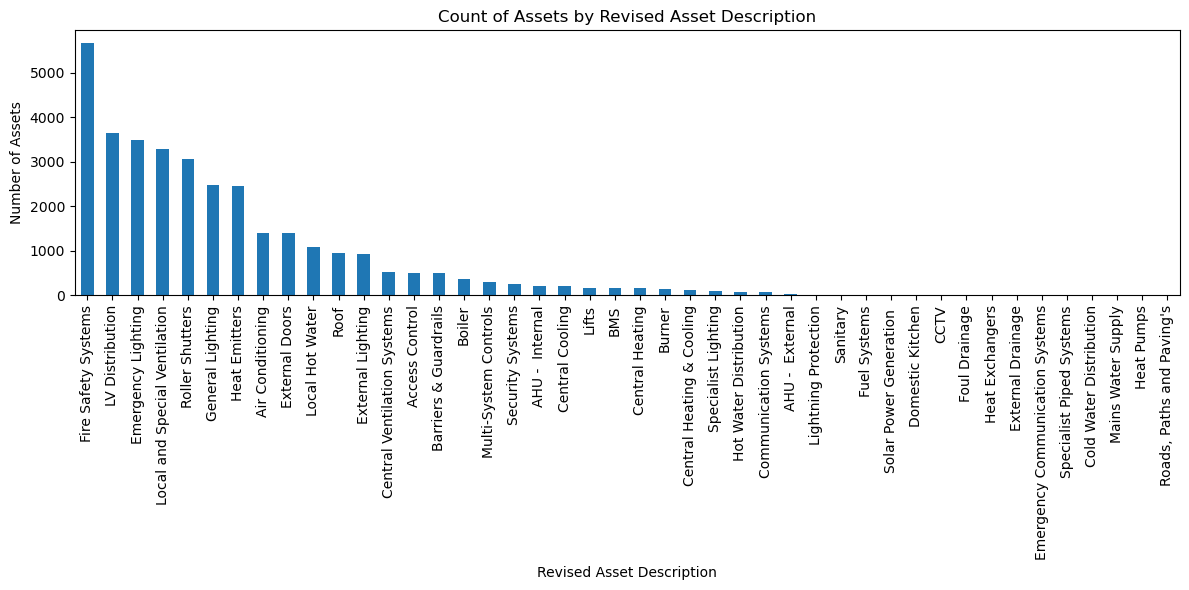

In [80]:
# Graph Asset Count
plt.figure(figsize=(12,6))
(
    df_assets['Revised Asset Description']
    .value_counts()
    .plot(kind='bar')
)
plt.title("Count of Assets by Revised Asset Description")
plt.xlabel("Revised Asset Description")
plt.ylabel("Number of Assets")
plt.xticks(rotation=90)        # rotate x-labels for readability
plt.tight_layout()
plt.show()


C:\Users\RoryO'Brien\AppData\Local\Temp\ipykernel_11116\263299266.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(costs_by_category.index, rotation=90)


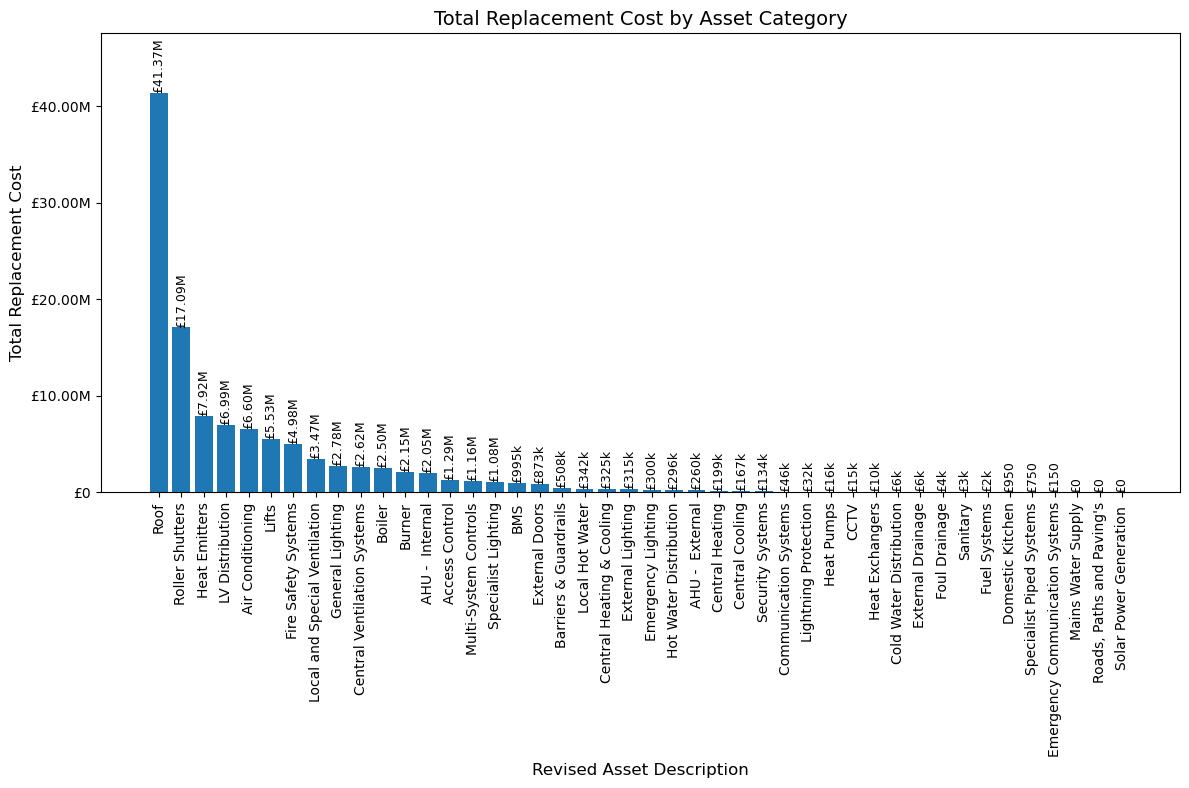

In [81]:
# Graph Replacement Cost by Category
# 1) Group and sum replacement cost by category 
costs_by_category = (
    df_assets
    .groupby("Revised Asset Description")["10 Year Total"]
    .sum()
    .sort_values(ascending=False)
)

# 2) Custom formatter: 1,234,567 → £1.23M / £850k
def pound_formatter(x, pos):
    if x >= 1_000_000:
        return f"£{x/1_000_000:.2f}M"
    elif x >= 1_000:
        return f"£{x/1_000:.0f}k"
    else:
        return f"£{x:.0f}"

# 3) Plot
fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(costs_by_category.index, costs_by_category.values)

ax.set_title("Total Replacement Cost by Asset Category", fontsize=14)
ax.set_xlabel("Revised Asset Description", fontsize=12)
ax.set_ylabel("Total Replacement Cost", fontsize=12)

# Rotate x-axis tick labels so categories fit
ax.set_xticklabels(costs_by_category.index, rotation=90)

# Format y-axis ticks in £k/£M
ax.yaxis.set_major_formatter(FuncFormatter(pound_formatter))

# Annotate each bar with its value (also formatted) rotated 90°
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        pound_formatter(height, None),  # reuse the same formatter
        ha='center', va='bottom',
        rotation=90,
        fontsize=9
    )

plt.tight_layout()
ax.margins(y=0.15)
plt.show()


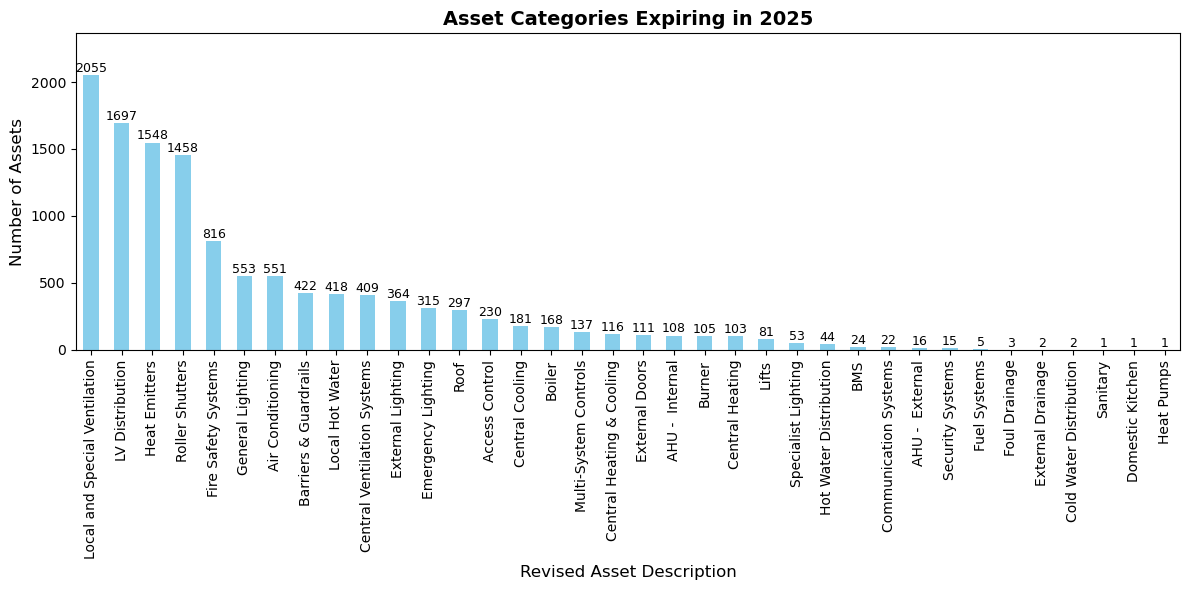

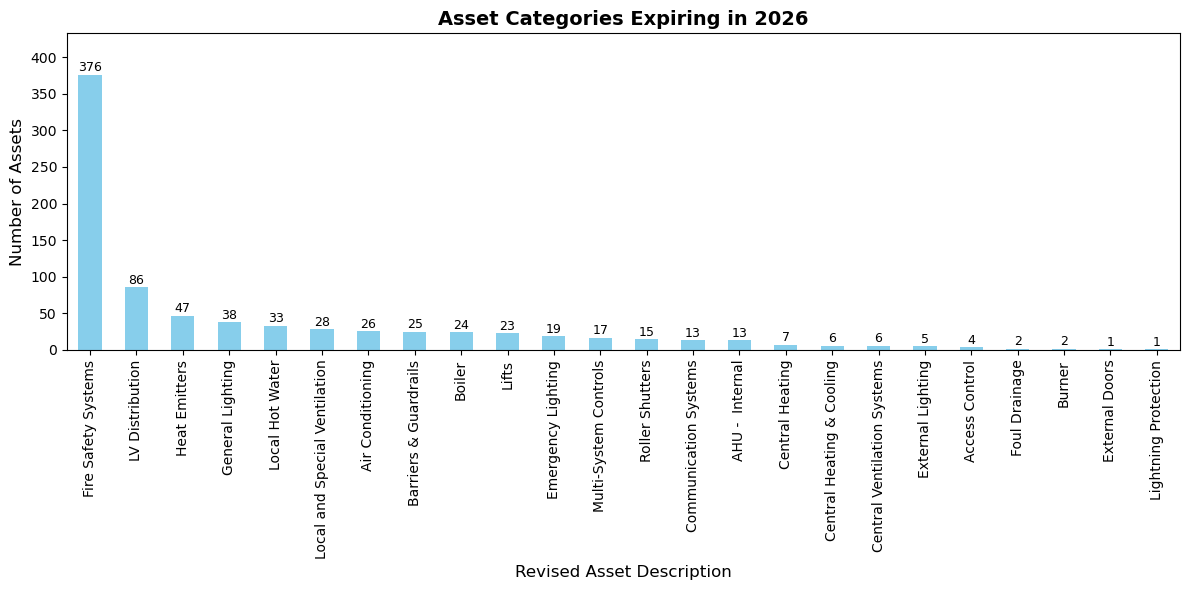

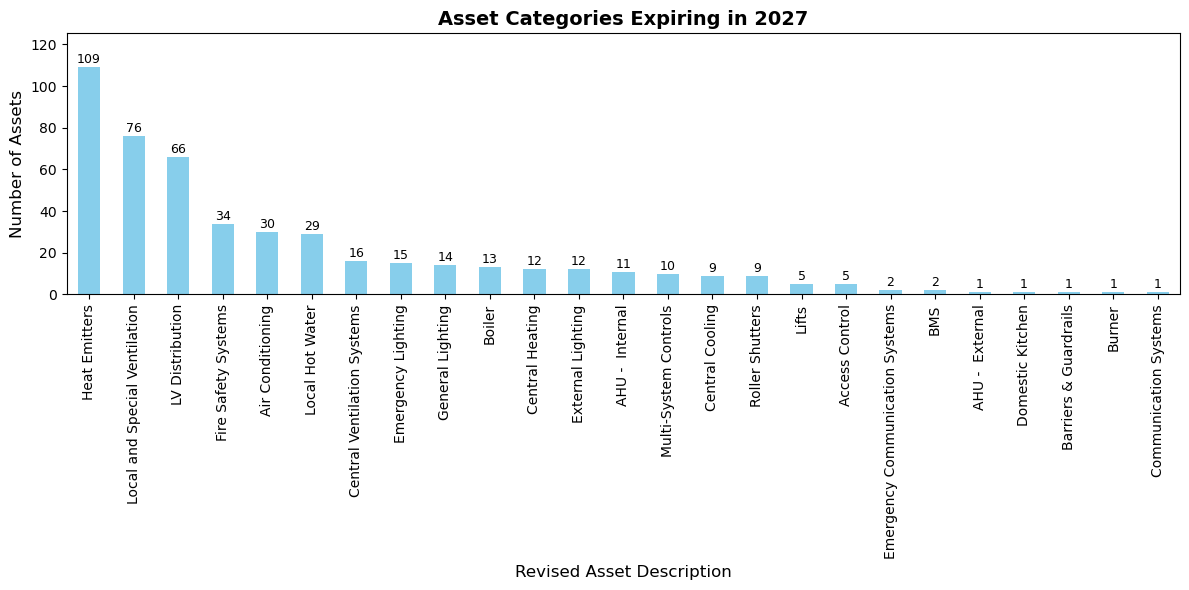

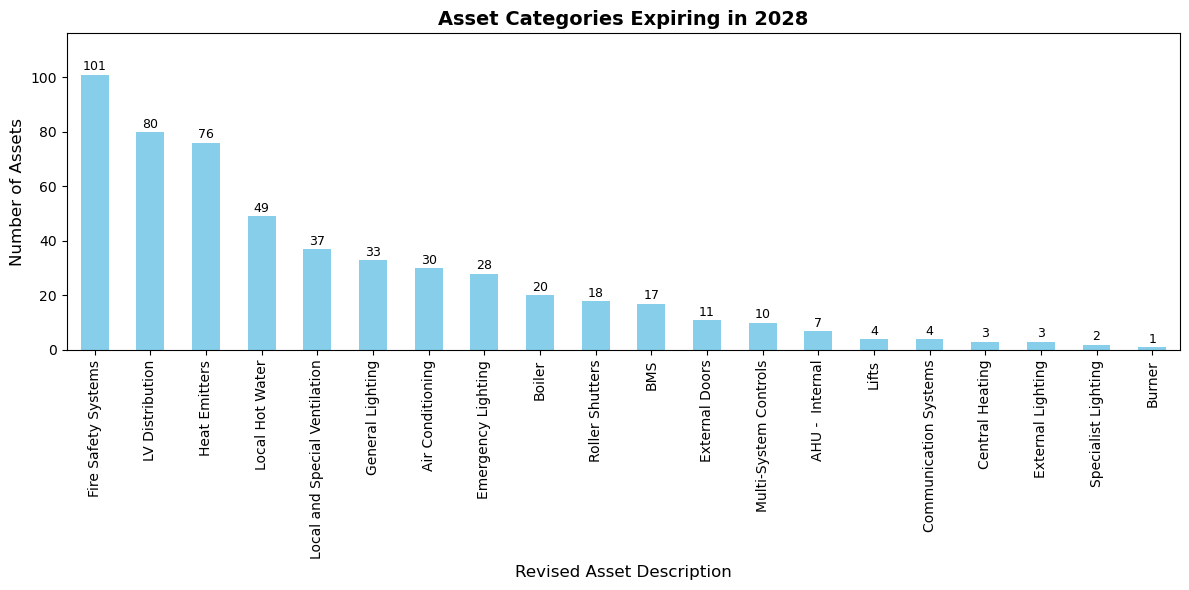

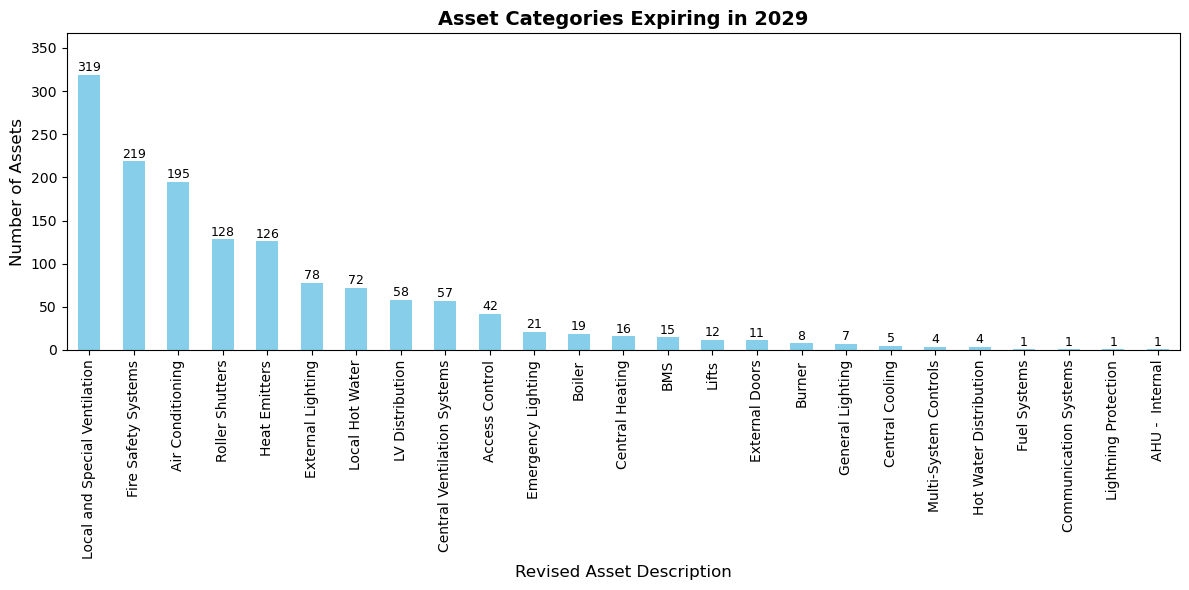

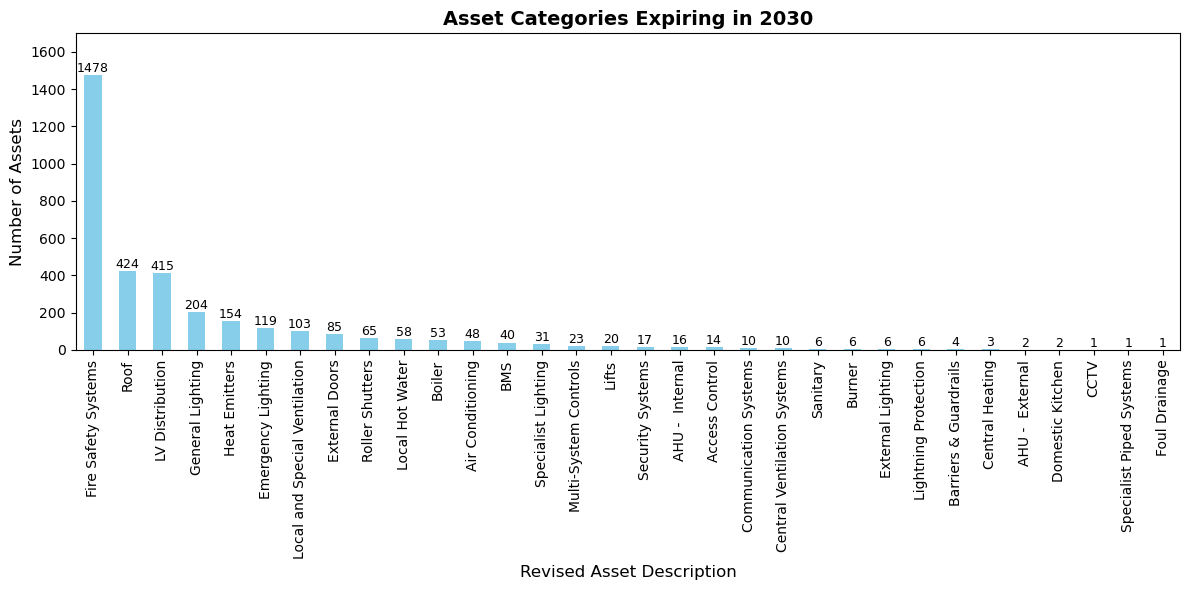

In [82]:
#Graph Expiration Count
# Define range of years you want to analyze
years = range(2025, 2031)   # 2025 → 2030 inclusive

for year in years:
    # 1) Filter dataset for given year
    df_year = df_assets[df_assets["Revised Exp Year"] == year]

    # 2️) Count assets by category
    category_counts = df_year["Revised Asset Description"].value_counts().sort_values(ascending=False)

    # Skip empty years (no data)
    if category_counts.empty:
        print(f"No assets expiring in {year}")
        continue

    # 3️) Bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    category_counts.plot(kind="bar", ax=ax, color="skyblue")

    ax.set_title(f"Asset Categories Expiring in {year}", fontsize=14, weight="bold")
    ax.set_xlabel("Revised Asset Description", fontsize=12)
    ax.set_ylabel("Number of Assets", fontsize=12)
    ax.tick_params(axis='x', rotation=90)

    # Add counts above bars
    for i, v in enumerate(category_counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9, rotation=0)

    plt.tight_layout()
    ax.margins(y=0.15)

    plt.show()


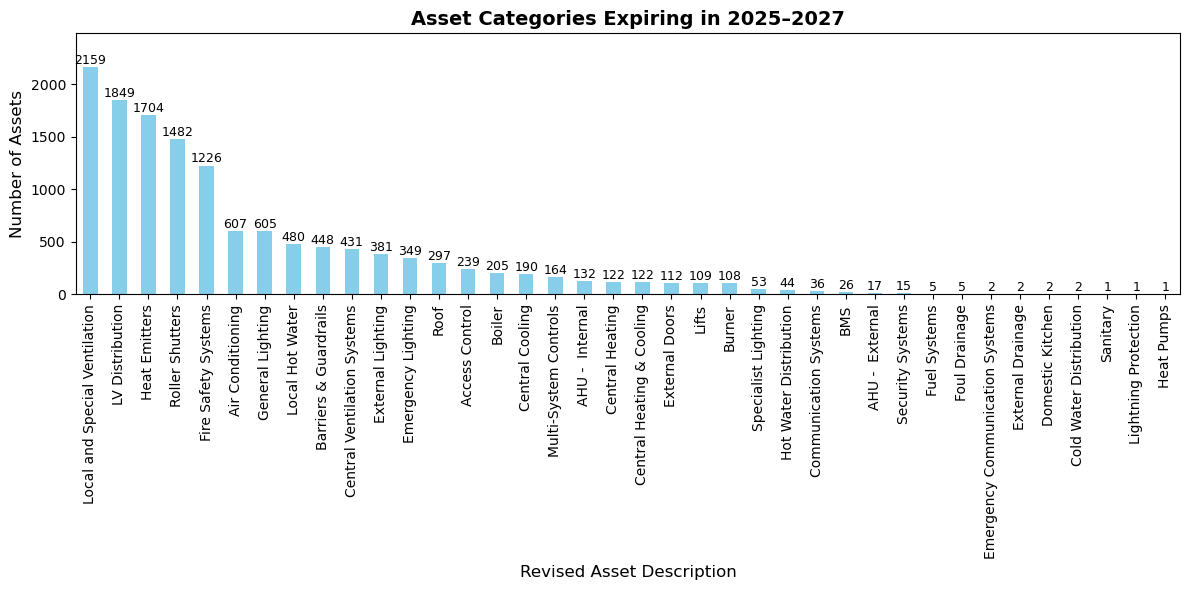

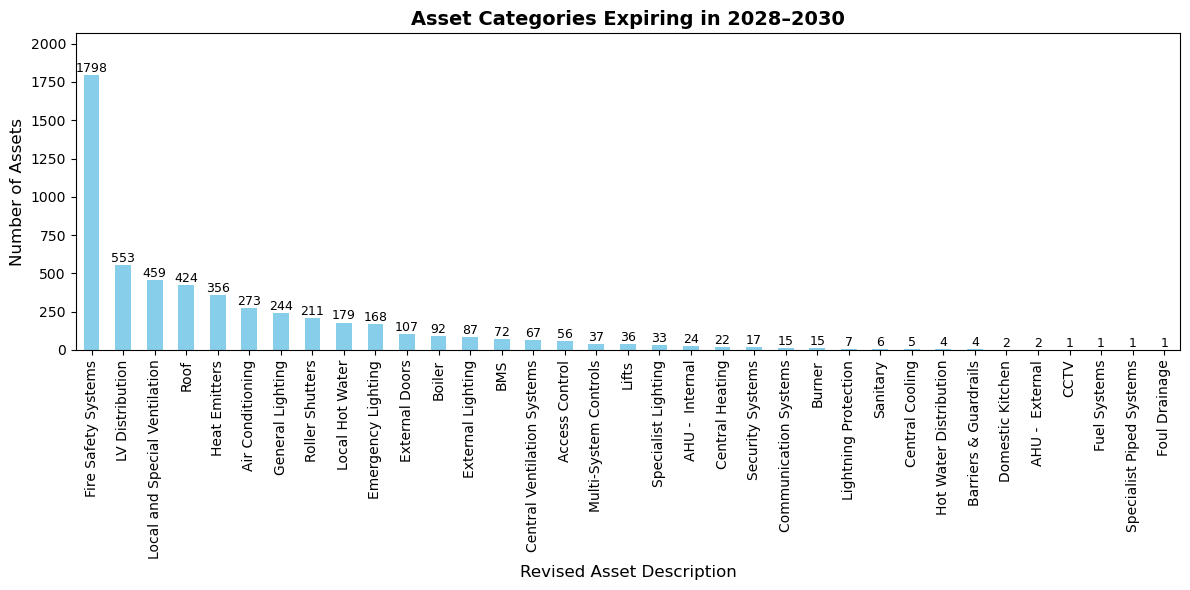

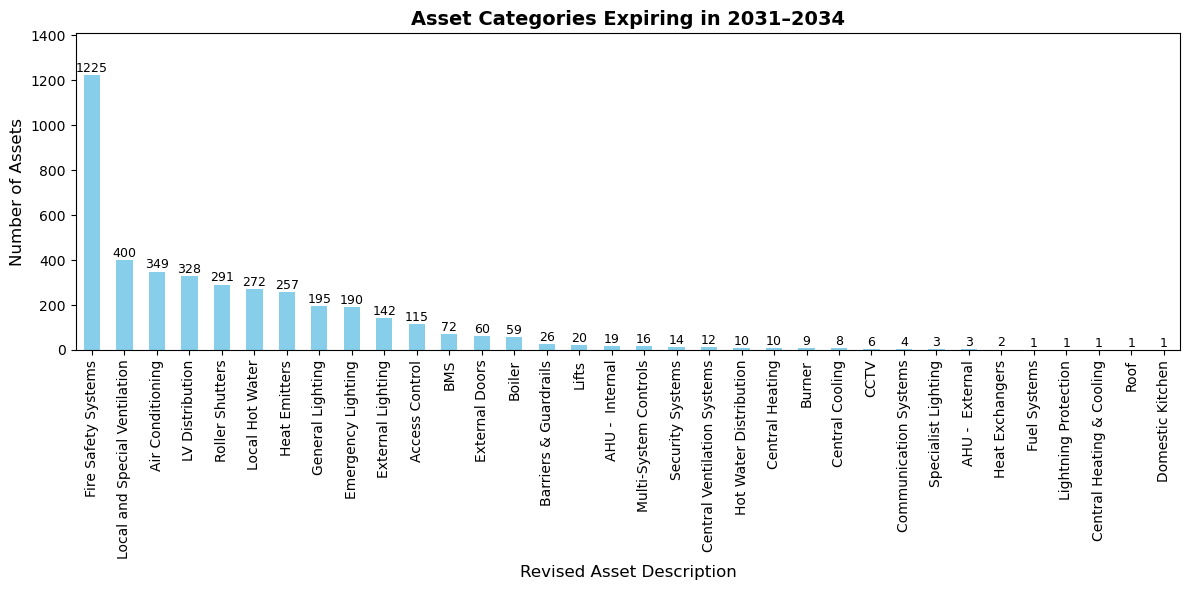

In [83]:
# Graph Expiration Count
# Define year ranges
year_ranges = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

for label, years in year_ranges.items():
    # 1️) Filter dataset for given year range
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]

    # 2️) Count assets by category
    category_counts = (
        df_period["Revised Asset Description"]
        .value_counts()
        .sort_values(ascending=False)
    )

    # Skip empty ranges
    if category_counts.empty:
        print(f"No assets expiring in {label}")
        continue

    # 3️) Bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    category_counts.plot(kind="bar", ax=ax, color="skyblue")

    ax.set_title(f"Asset Categories Expiring in {label}", fontsize=14, weight="bold")
    ax.set_xlabel("Revised Asset Description", fontsize=12)
    ax.set_ylabel("Number of Assets", fontsize=12)
    ax.tick_params(axis='x', rotation=90)

    # 4️) Add counts above bars (horizontal text)
    for i, v in enumerate(category_counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9, rotation=0)

    plt.tight_layout()
    ax.margins(y=0.15)
    plt.show()


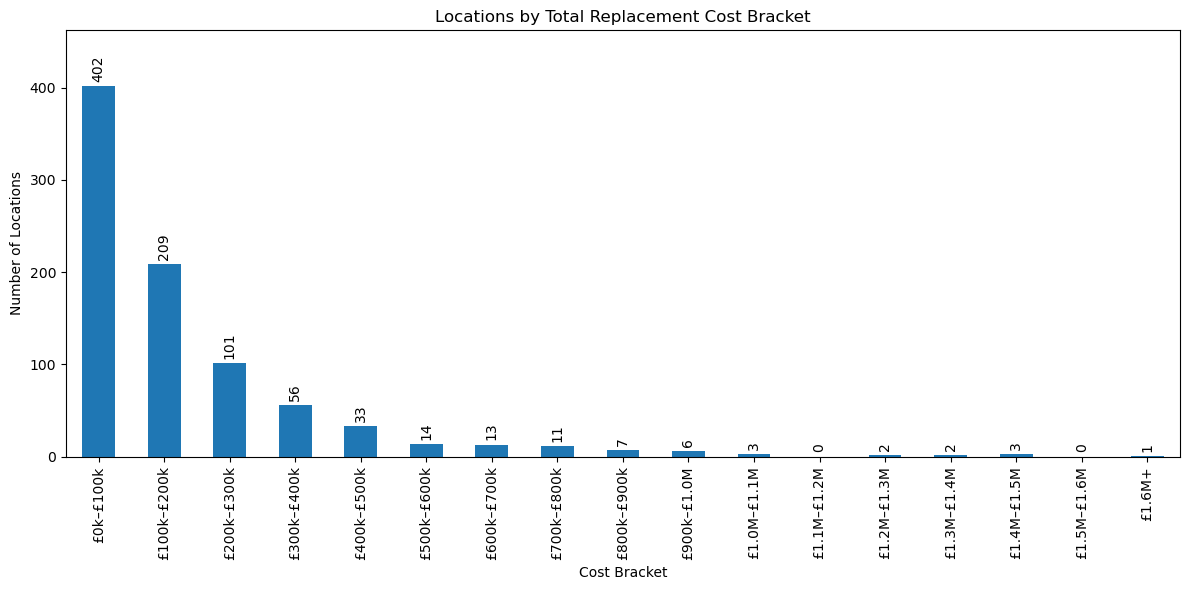

In [84]:
# Graph Location Data
# 1) Aggregate per-location cost
loc_cost = (
    df_assets.groupby("Facility General Location")["Replacement Cost"]
             .sum(min_count=1)
             .dropna()
    .clip(lower=0)
)

# 2) Define bins (edit as you like)
bins = [
    0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, 900_000,
    1_000_000, 1_100_000, 1_200_000, 1_300_000, 1_400_000, 1_500_000, 1_600_000,
    float("inf")
]

def fmt(v):
    return f"£{v/1_000_000:.1f}M" if np.isfinite(v) and v >= 1_000_000 else f"£{int(v/1_000)}k"

# 3) Build matching labels automatically
labels = [f"{fmt(bins[i])}–{fmt(bins[i+1])}" for i in range(len(bins)-2)] + [f"{fmt(bins[-2])}+"]

# 4) Bin and count
bracketed = pd.cut(loc_cost, bins=bins, labels=labels, right=False, include_lowest=True)
counts = bracketed.value_counts().reindex(labels, fill_value=0)

# 5) Plot
fig, ax = plt.subplots(figsize=(12,6))
counts.plot(kind="bar", ax=ax)
ax.set_title("Locations by Total Replacement Cost Bracket")
ax.set_xlabel("Cost Bracket")
ax.set_ylabel("Number of Locations")
ax.bar_label(ax.containers[0], padding=3, rotation=90)
ax.margins(y=0.15)
plt.tight_layout()
plt.show()


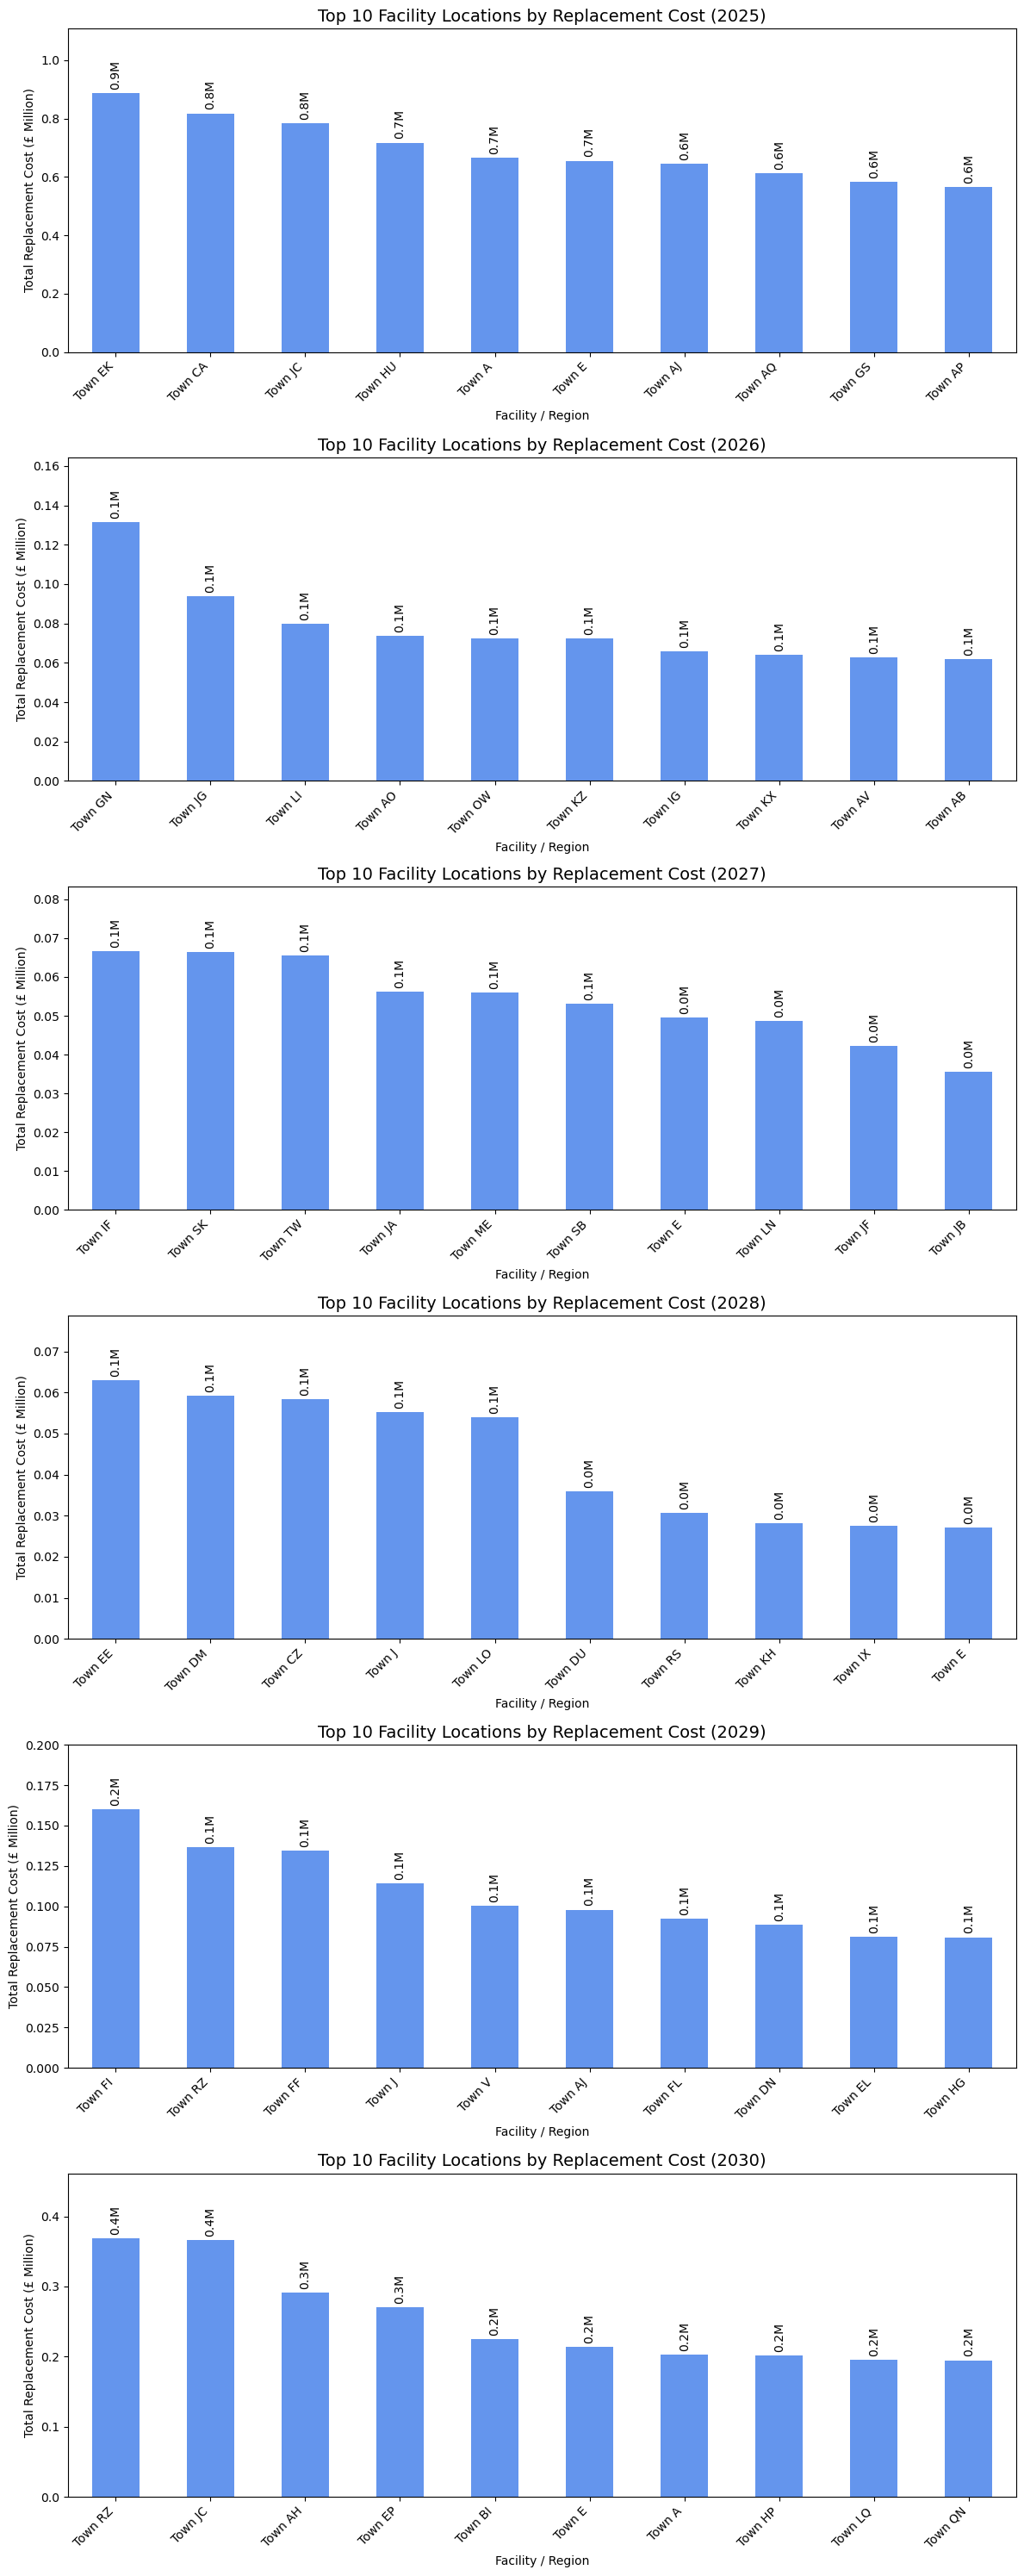

In [85]:
# Graph Facility Location Data
# 1️) Filter to only the years of interest
years = [2025, 2026, 2027, 2028, 2029, 2030]
df_filtered = df_assets[df_assets["Revised Exp Year"].isin(years)]

# 2️) Group by year + region, sum replacement cost (convert to millions)
region_costs = (
    df_filtered.groupby(["Revised Exp Year", "Facility General Location"])["Replacement Cost"]
    .sum()
    .div(1_000_000)  # convert to millions (£M)
    .reset_index()
)

# 3️) Plot one chart per year (top 10 locations only)
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(12, 5 * len(years)))

for i, year in enumerate(years):
    ax = axes[i]
    
    # Filter for the year and take top 10 by cost
    subset = (
        region_costs[region_costs["Revised Exp Year"] == year]
        .sort_values("Replacement Cost", ascending=False)
        .head(10)
    )

    subset.plot(
        kind="bar",
        x="Facility General Location",
        y="Replacement Cost",
        ax=ax,
        color="cornflowerblue",
        legend=False
    )

    # Titles and labels
    ax.set_title(f"Top 10 Facility Locations by Replacement Cost ({year})", fontsize=14)
    ax.set_xlabel("Facility / Region")
    ax.set_ylabel("Total Replacement Cost (£ Million)")

    # Add labels above bars in £M with one decimal
    ax.bar_label(
        ax.containers[0],
        labels=[f"{v:.1f}M" for v in subset["Replacement Cost"]],
        padding=3,
        rotation=90
    )

    # Rotate x-axis labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax.margins(y=0.25)

plt.tight_layout()
plt.show()



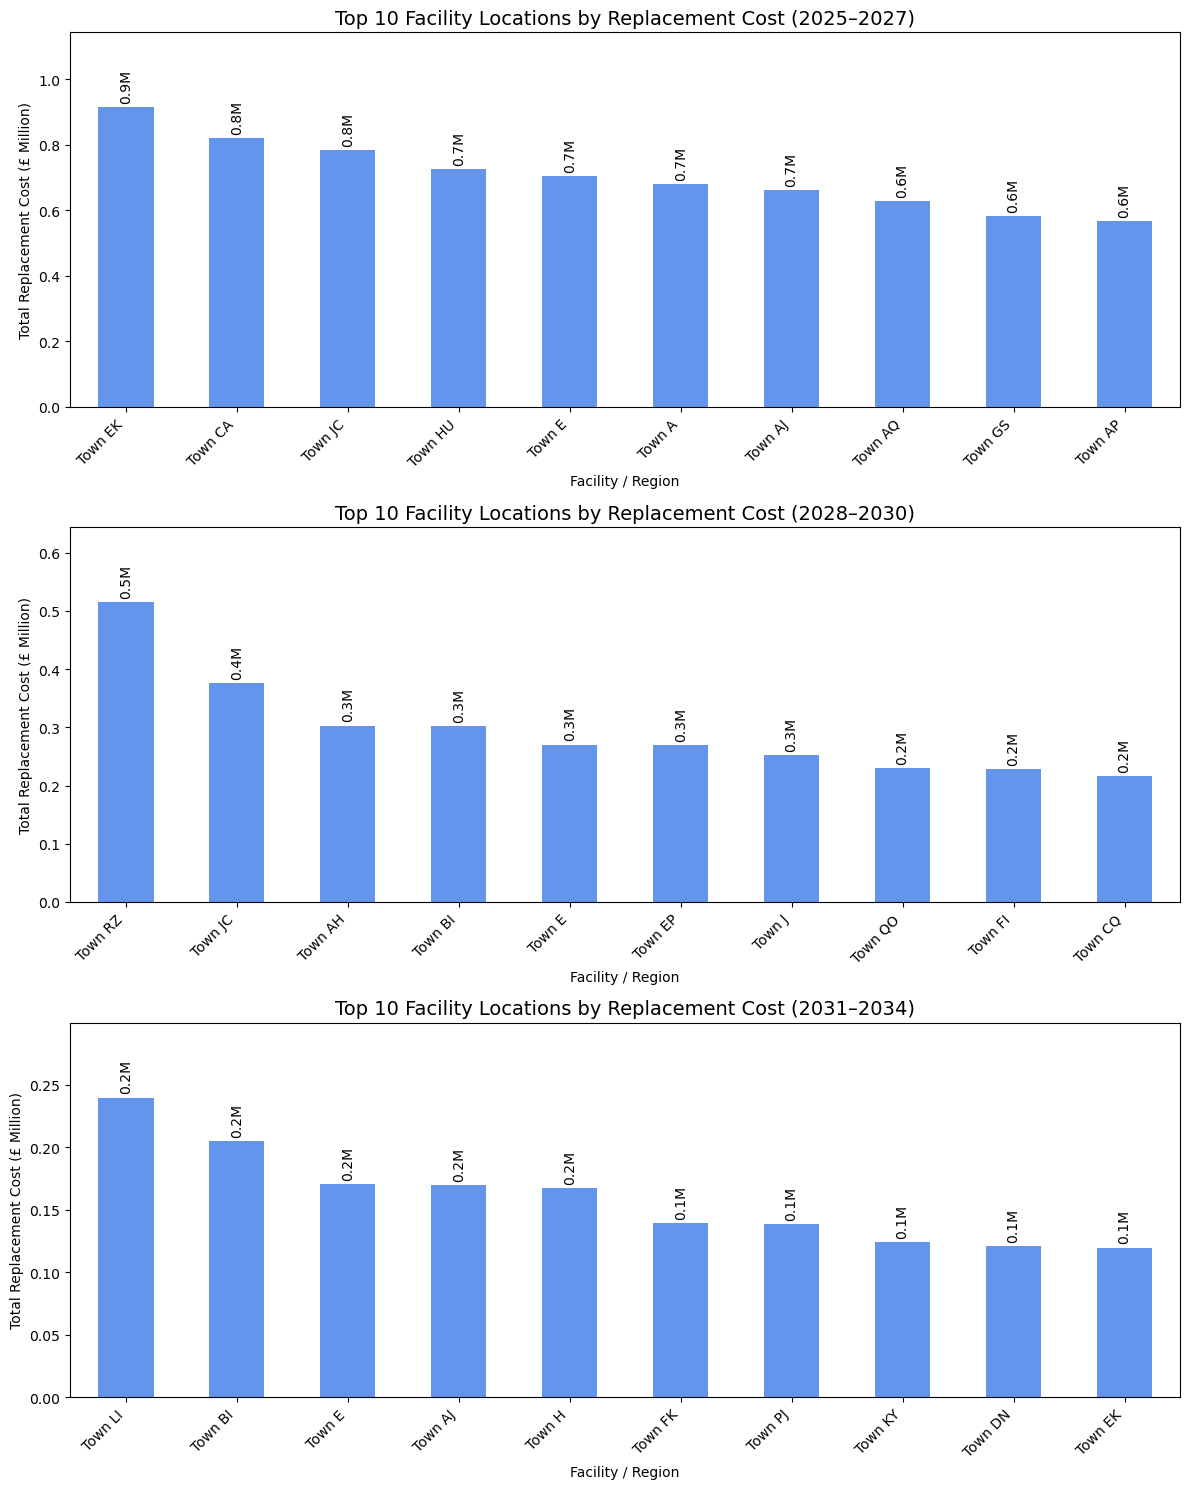

In [86]:
# Graph Facility Location Data
# Define your year ranges
periods = {
    "2025–2027": range(2025, 2028),
    "2028–2030": range(2028, 2031),
    "2031–2034": range(2031, 2035)
}

# 1) Prepare figure with 3 subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# 2) Loop through each period
for i, (label, years) in enumerate(periods.items()):
    ax = axes[i]
    
    # 3) Filter and aggregate data
    df_period = df_assets[df_assets["Revised Exp Year"].isin(years)]
    region_costs = (
        df_period.groupby("Facility General Location")["Replacement Cost"]
        .sum()
        .div(1_000_000)  # convert to £M
        .sort_values(ascending=False)
        .head(10)  # top 10
    )

    # 4) Plot
    region_costs.plot(kind="bar", ax=ax, color="cornflowerblue", legend=False)
    ax.set_title(f"Top 10 Facility Locations by Replacement Cost ({label})", fontsize=14)
    ax.set_xlabel("Facility / Region")
    ax.set_ylabel("Total Replacement Cost (£ Million)")

    # Label bars
    ax.bar_label(
        ax.containers[0],
        labels=[f"{v:.1f}M" for v in region_costs],
        padding=3,
        rotation=90
    )

    # Clean up axes
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.margins(y=0.25)

plt.tight_layout()
plt.show()


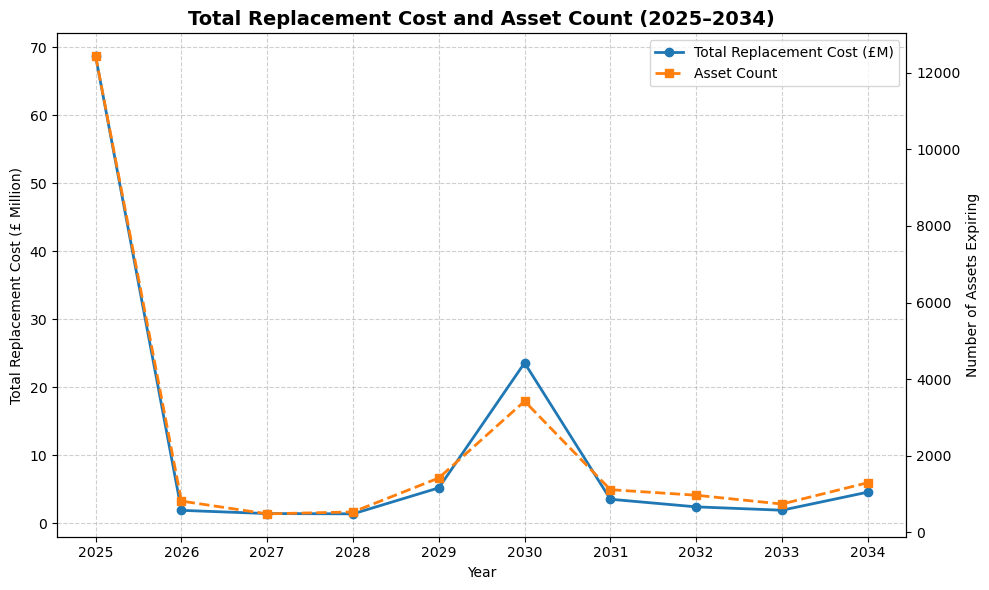

In [87]:
# Graph replacement cost & asset count
# 1️) Define the period
years = list(range(2025, 2035))

# 2️) Aggregate totals by year
yearly_stats = (
    df_assets[df_assets["Revised Exp Year"].isin(years)]
    .groupby("Revised Exp Year")
    .agg(
        Total_Cost=("Replacement Cost", "sum"),
        Asset_Count=("Revised Asset Description", "count")
    )
    .reindex(years)  # ensures missing years still appear
    .fillna(0)
    .reset_index()
    .rename(columns={"Revised Exp Year": "Year"})
)

# Convert cost to £ millions
yearly_stats["Total_Cost_Million"] = yearly_stats["Total_Cost"] / 1_000_000

# 3️) Create line chart with twin axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: Total replacement cost
ax1.set_xlabel("Year", color="black")
ax1.set_ylabel("Total Replacement Cost (£ Million)", color="black")
ax1.plot(
    yearly_stats["Year"], 
    yearly_stats["Total_Cost_Million"], 
    marker="o", color="tab:blue", linewidth=2, label="Total Replacement Cost (£M)"
)
ax1.tick_params(axis='y', colors="black")
ax1.tick_params(axis='x', colors="black")
ax1.set_xticks(years)  # show every year explicitly

# Right y-axis: Total asset count
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Assets Expiring", color="black")
ax2.plot(
    yearly_stats["Year"], 
    yearly_stats["Asset_Count"], 
    marker="s", linestyle="--", color="tab:orange", linewidth=2, label="Asset Count"
)
ax2.tick_params(axis='y', colors="black")

# 4️) Formatting
plt.title("Total Replacement Cost and Asset Count (2025–2034)", fontsize=14, weight="bold", color="black")
ax1.grid(True, linestyle="--", alpha=0.6)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

fig.tight_layout()
plt.show()


Now plotting group: Life Safety Systems


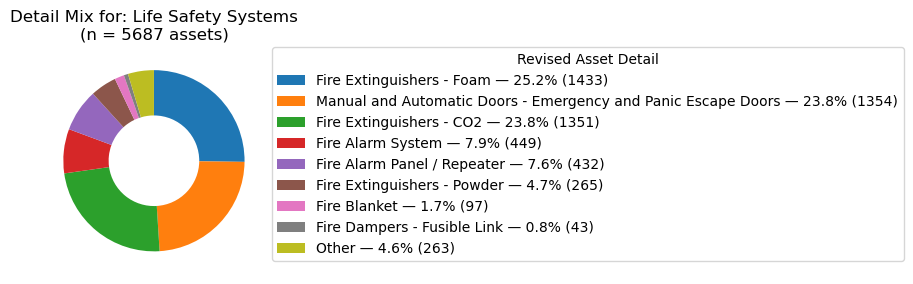

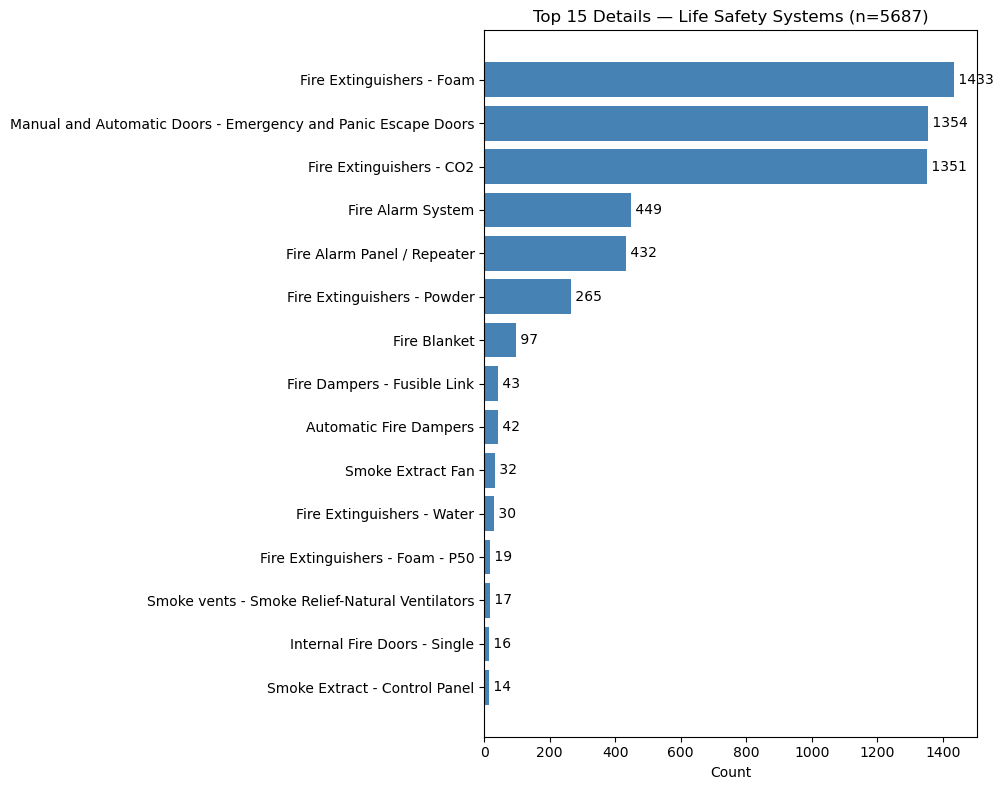

Now plotting group: Security & Access Control


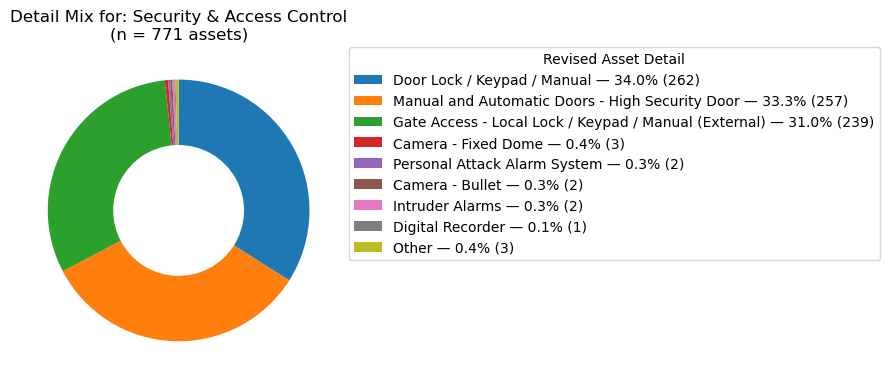

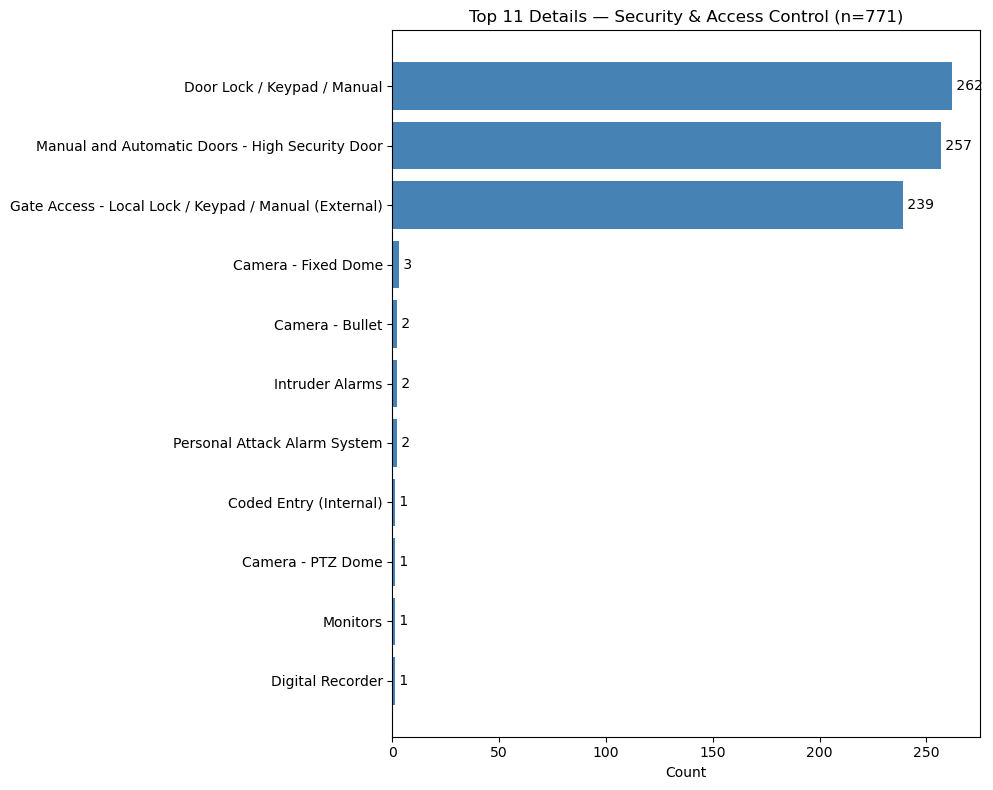

Now plotting group: Staff Facilities


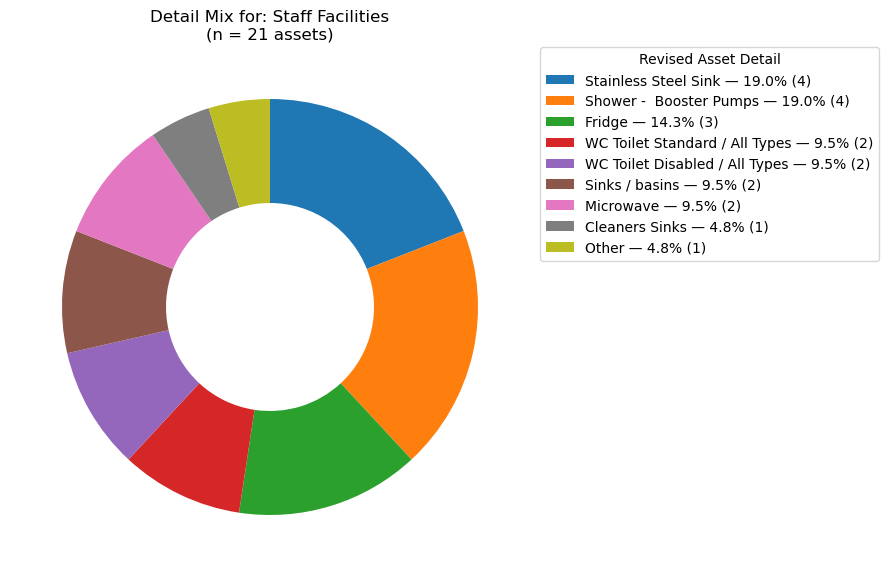

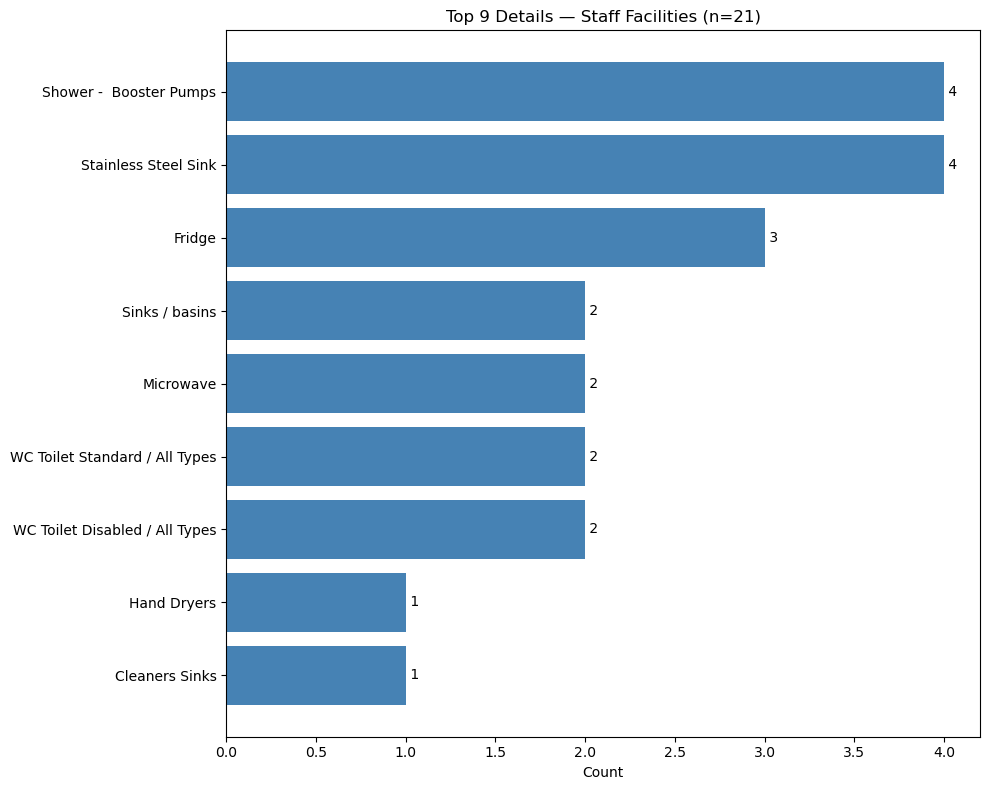

Now plotting group: Lifts


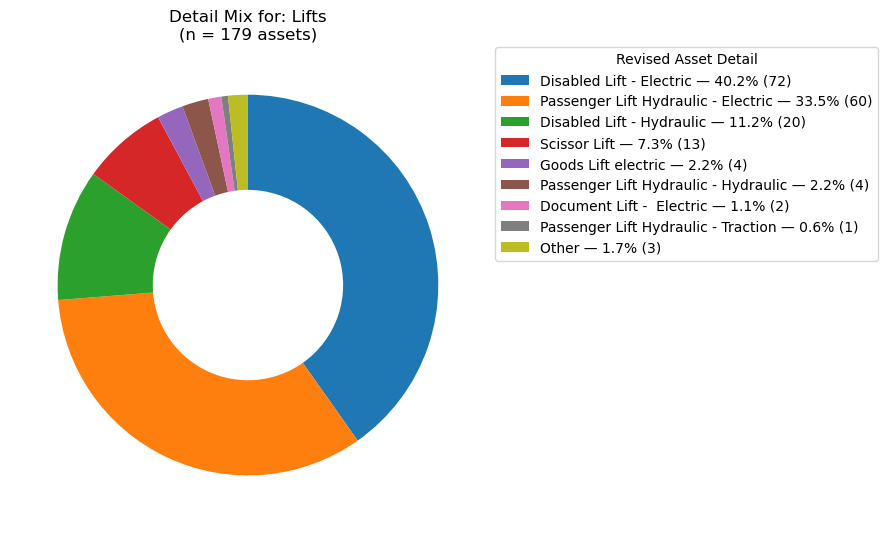

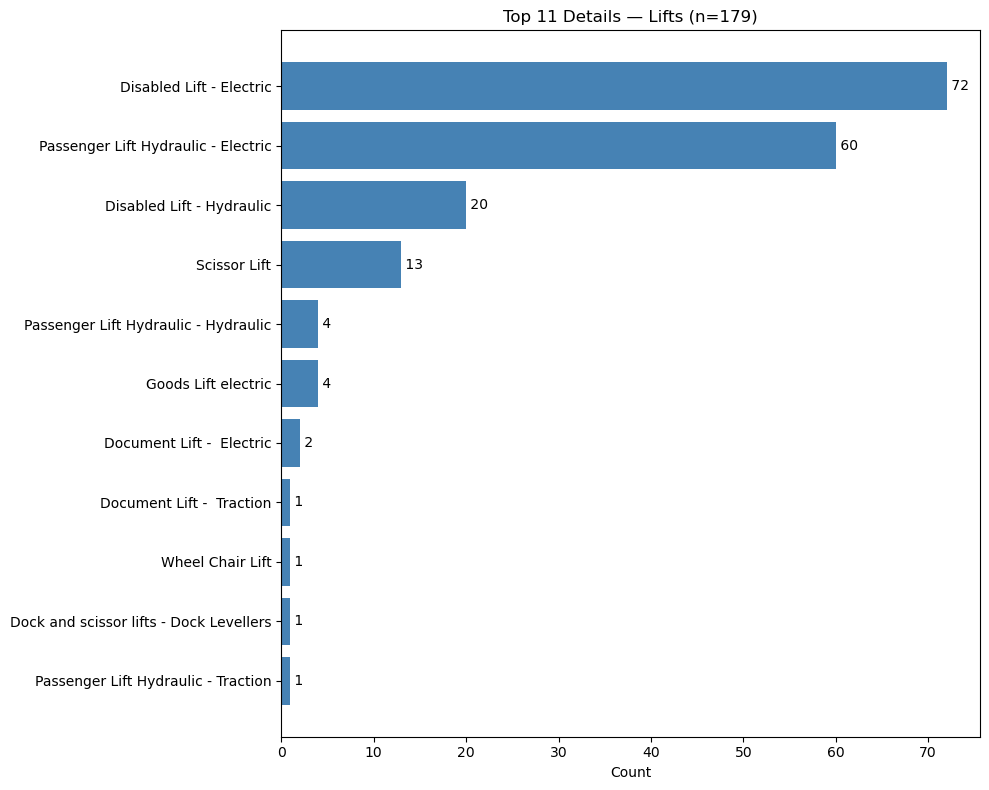

Now plotting group: Lighting


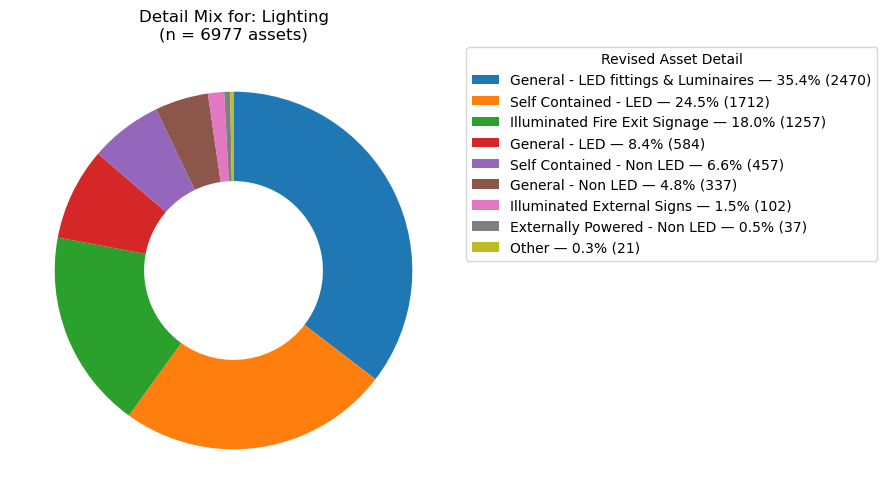

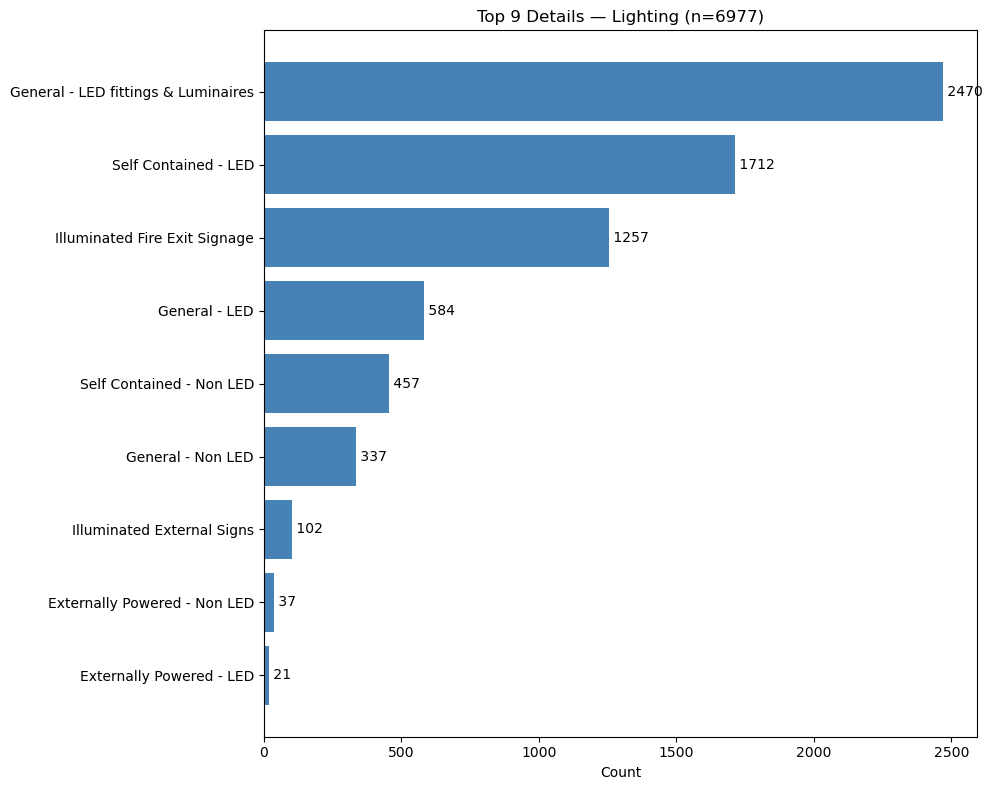

Now plotting group: LV Distribution


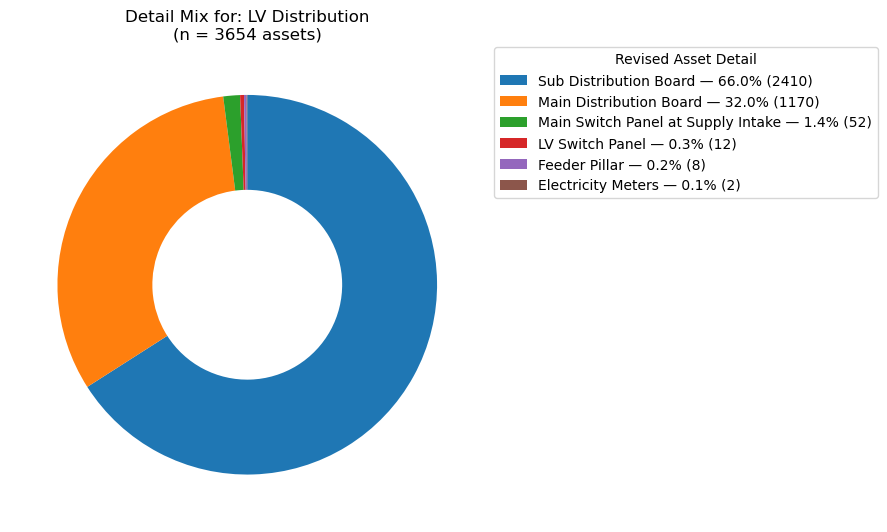

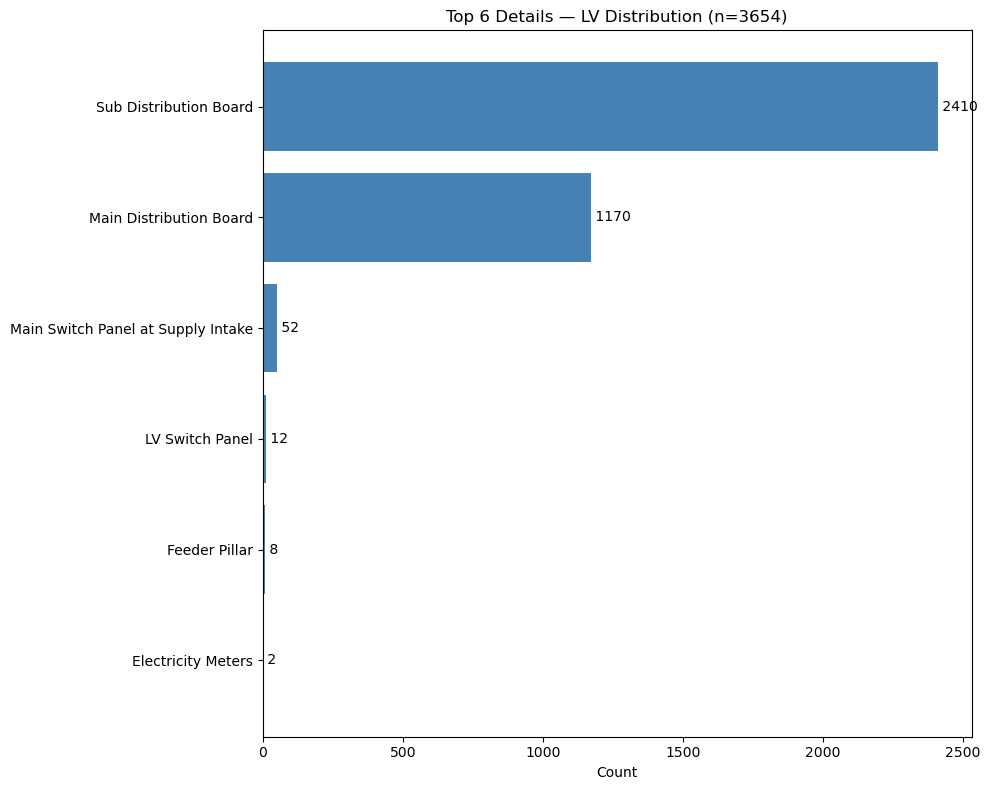

Now plotting group: Heat Emitters


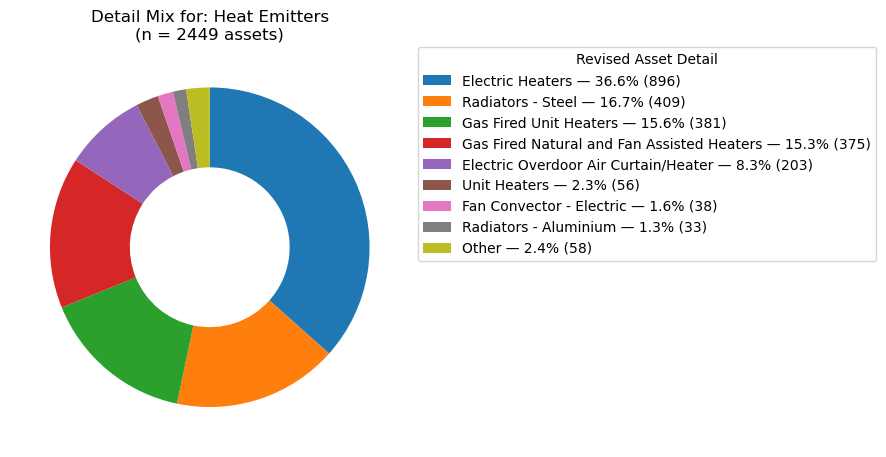

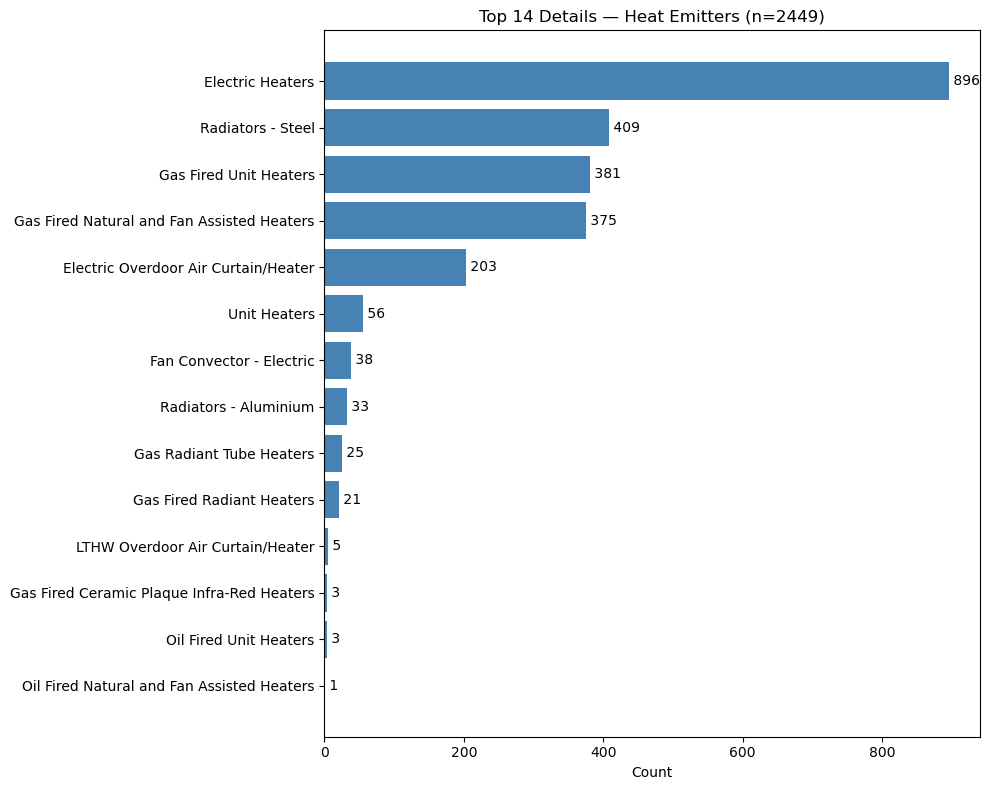

Now plotting group: Water Distribution


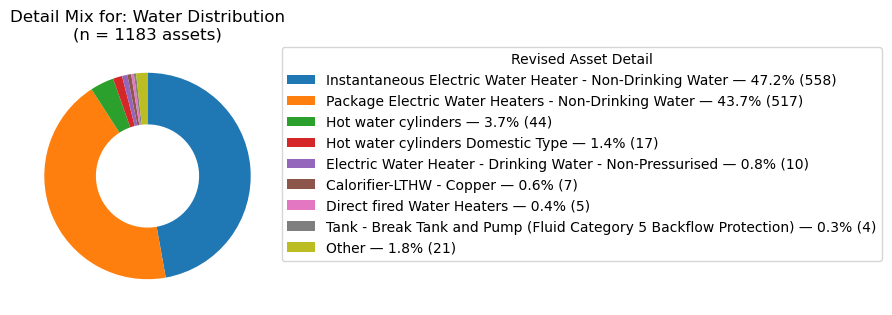

C:\Users\RoryO'Brien\AppData\Local\Temp\ipykernel_11116\4153136984.py:109: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


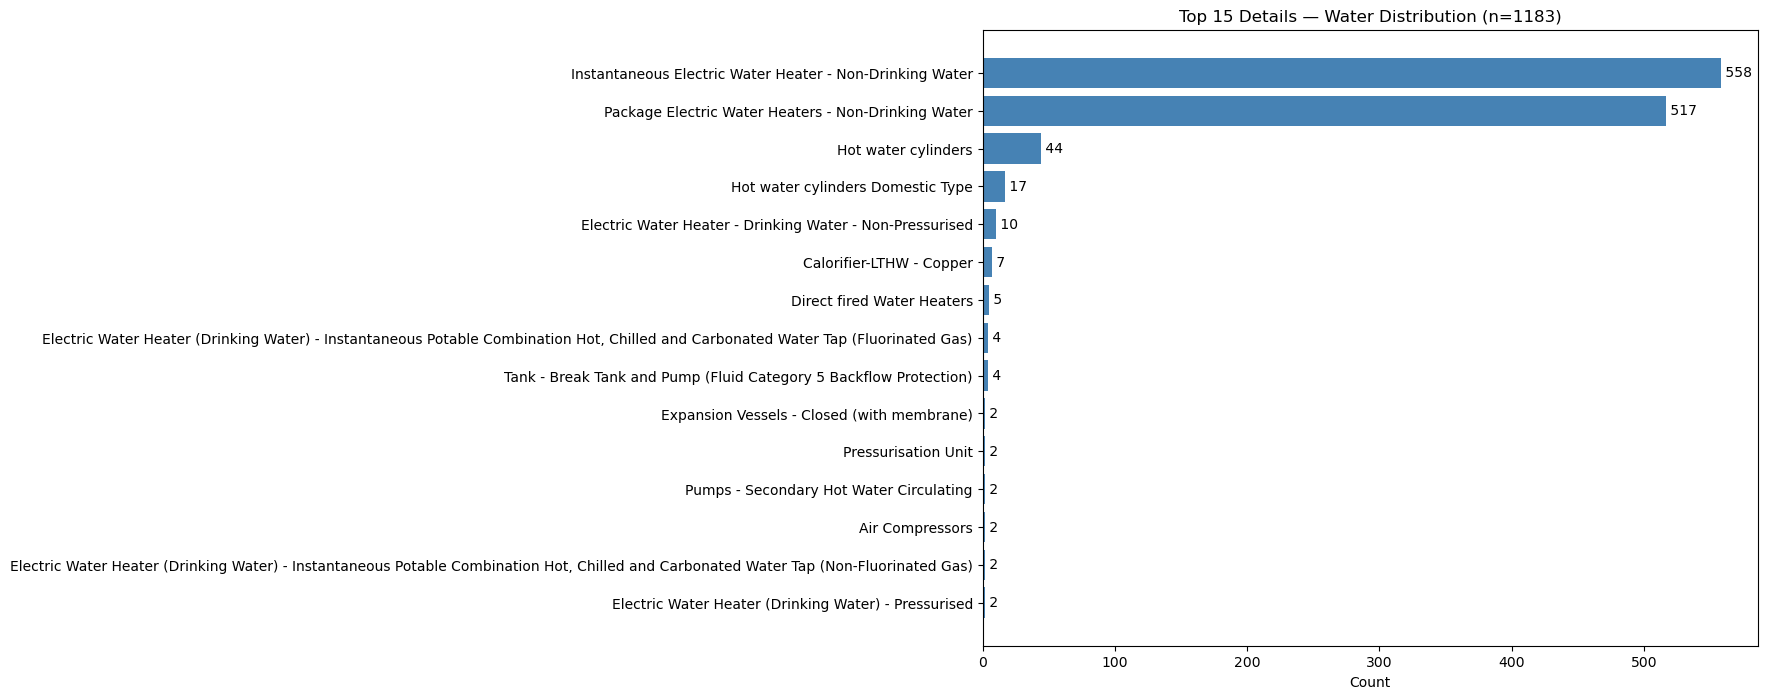

Now plotting group: Ventilation


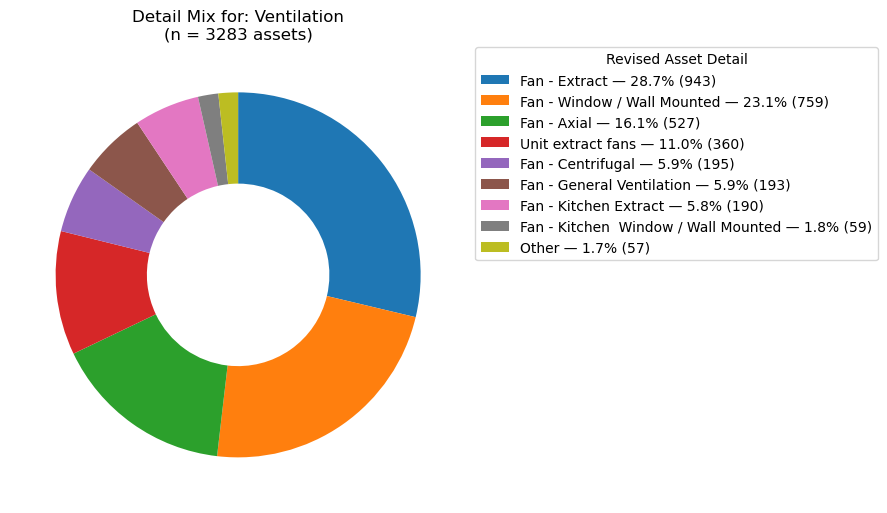

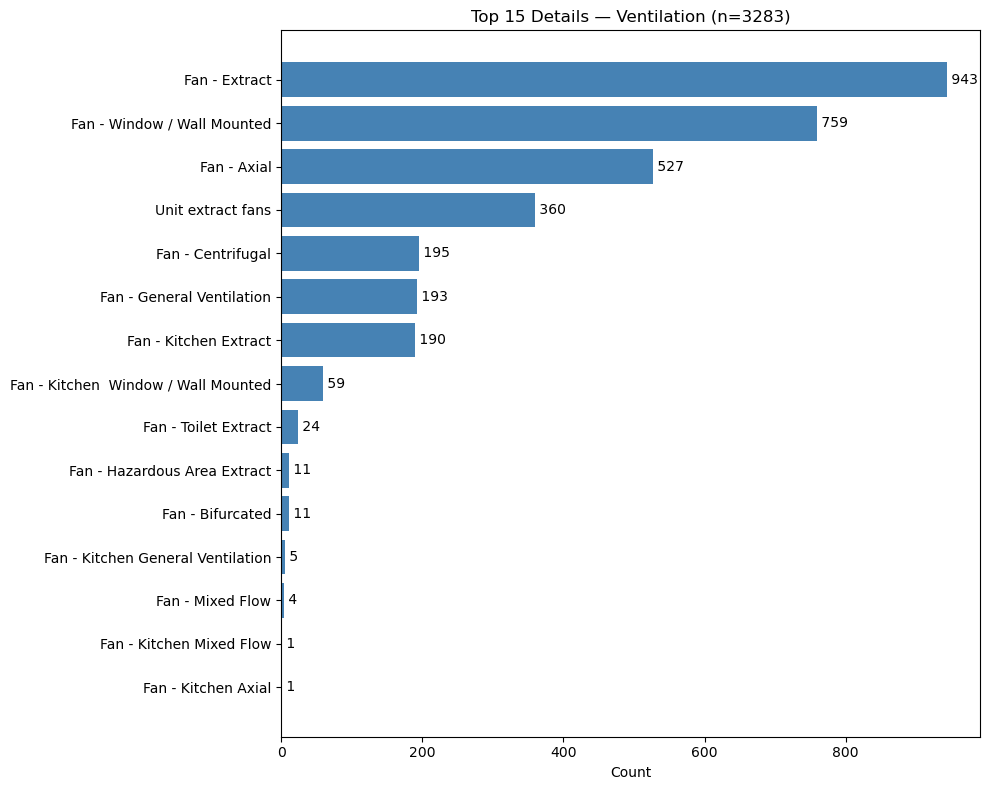

Now plotting group: Points of Access


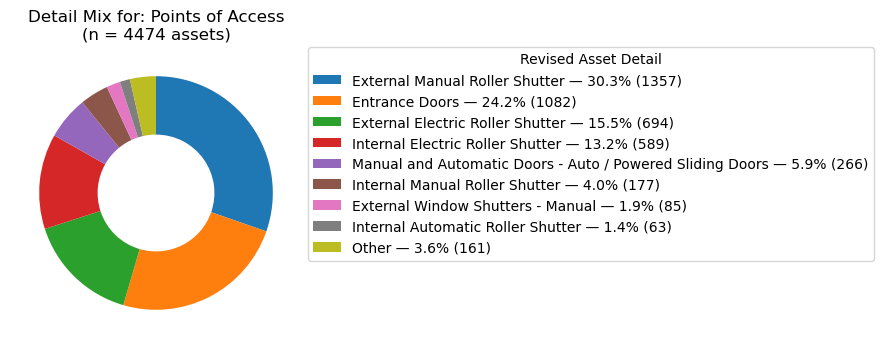

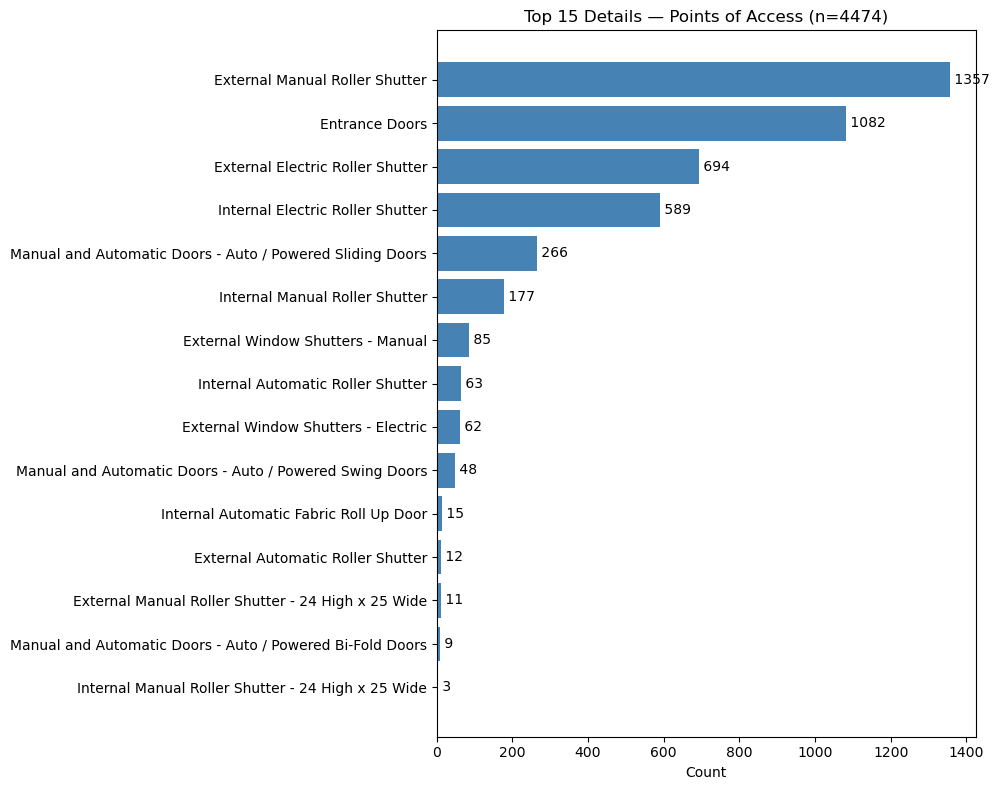

Now plotting group: Fabric & Infrastructure


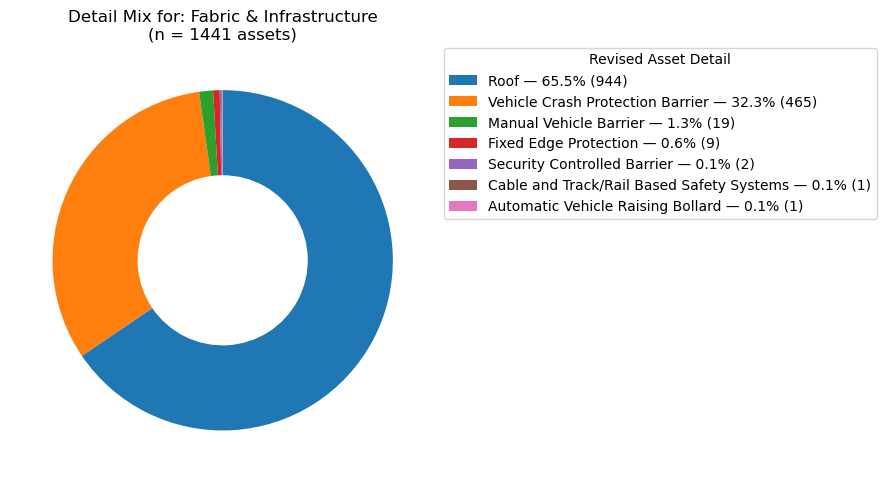

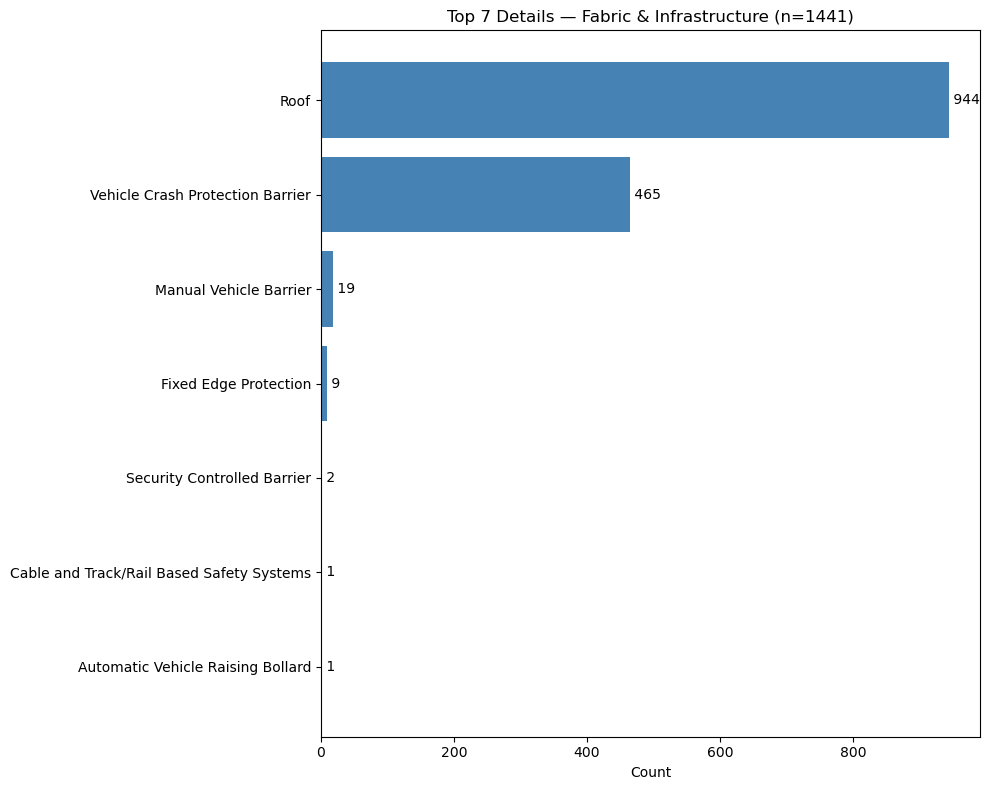

Now plotting group: Heating & Cooling


C:\Users\RoryO'Brien\AppData\Local\Temp\ipykernel_11116\4153136984.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


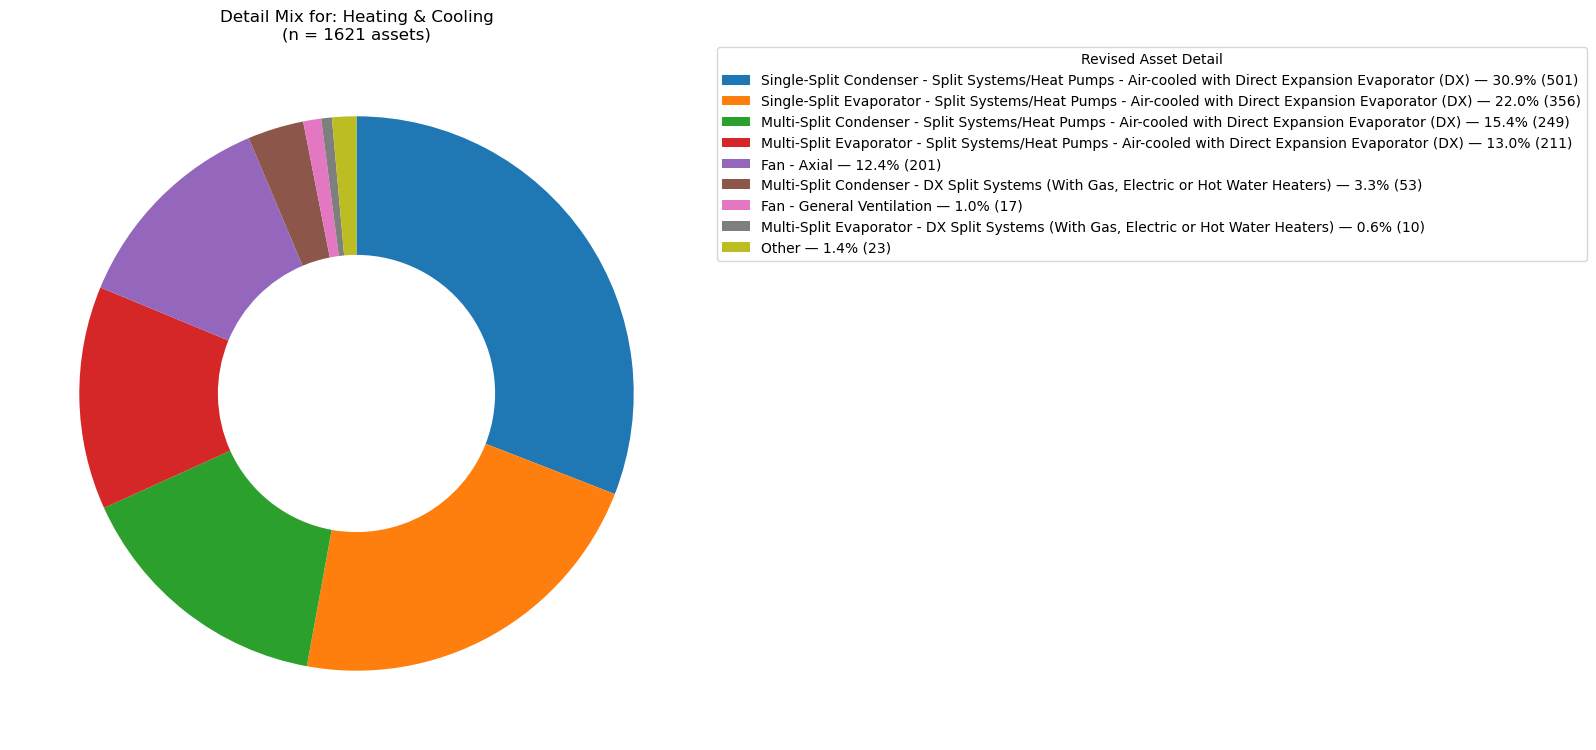

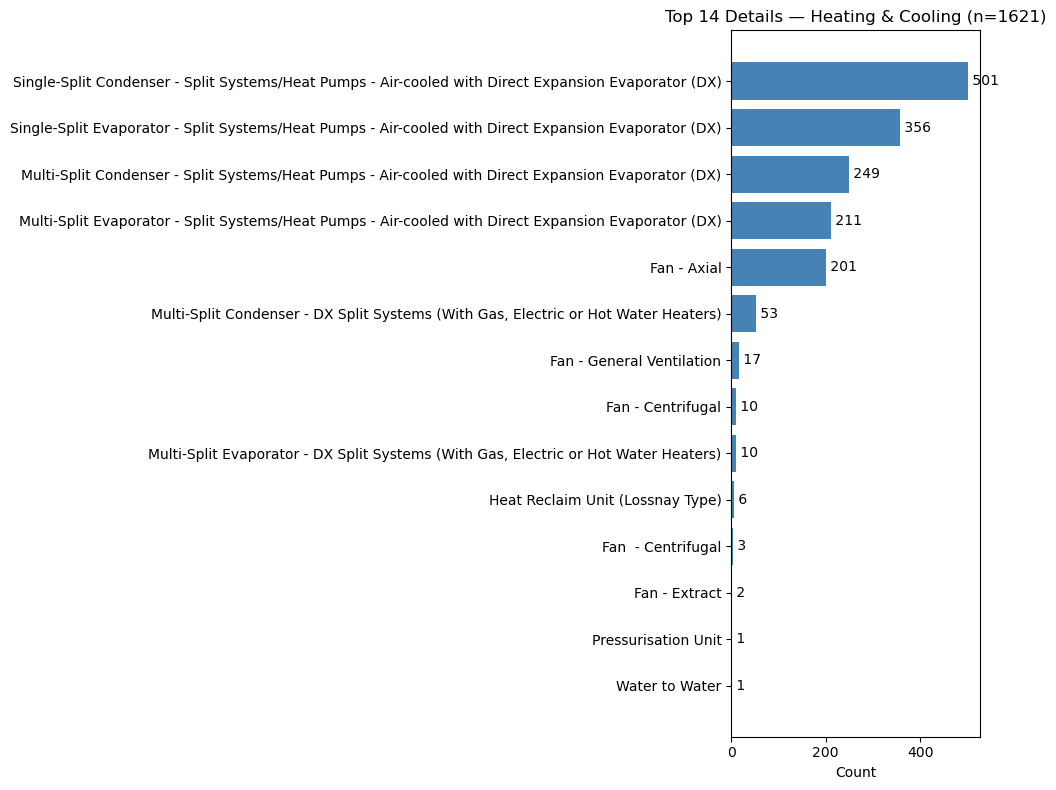

Now plotting group: Boiler


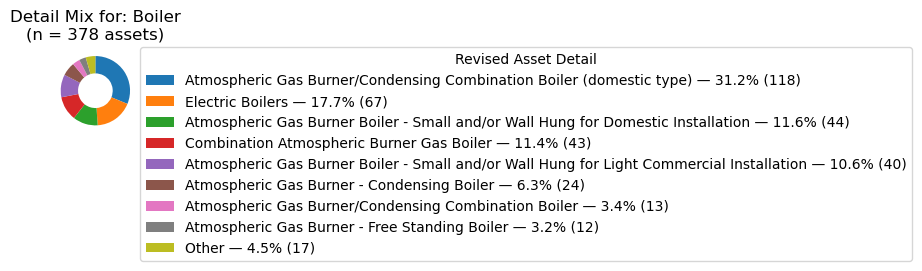

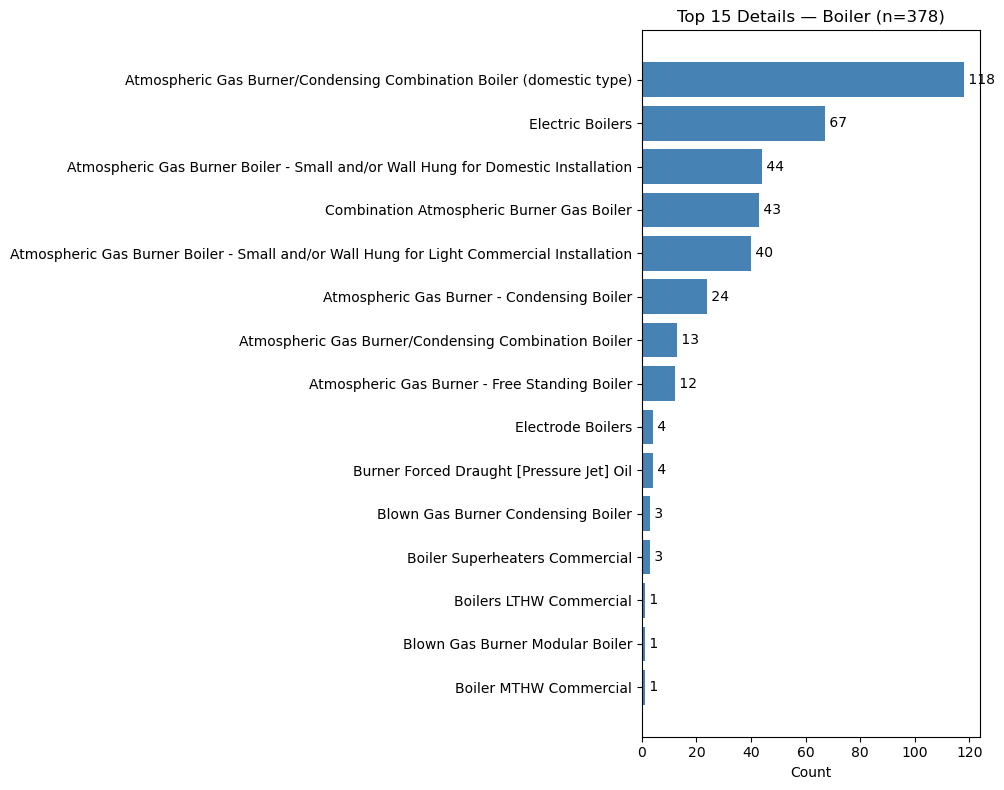

Now plotting group: Controls Systems


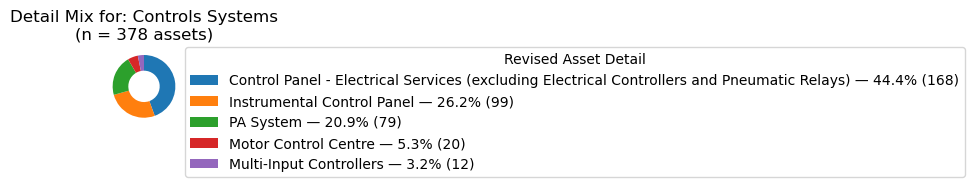

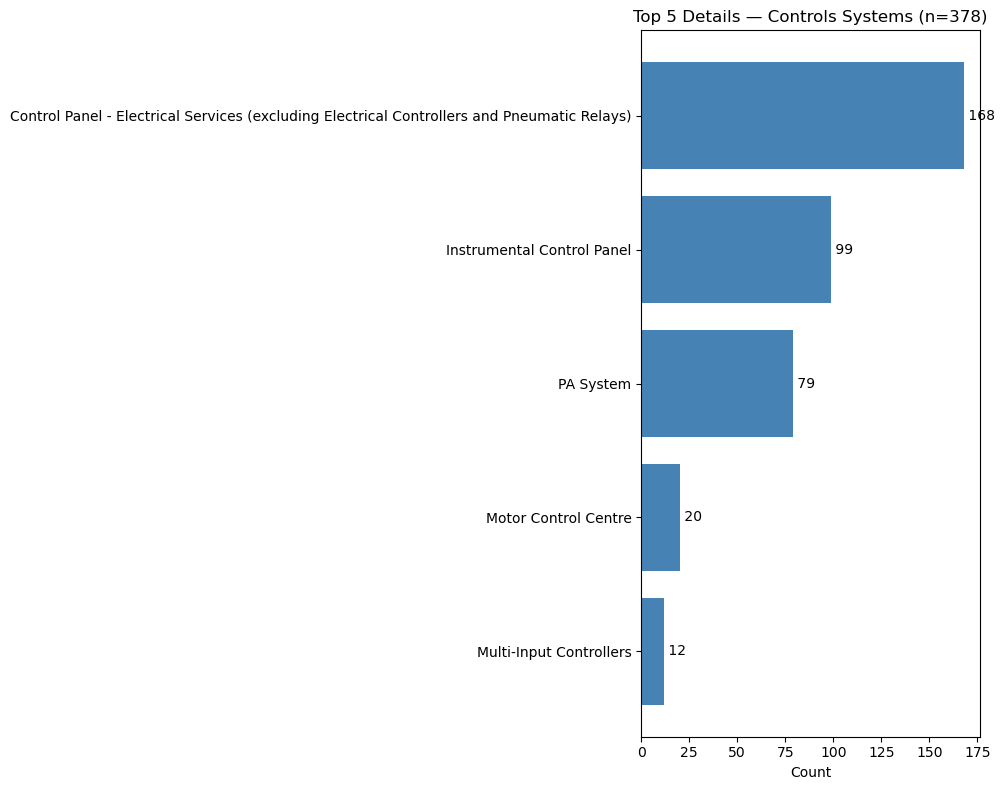

Now plotting group: Burner


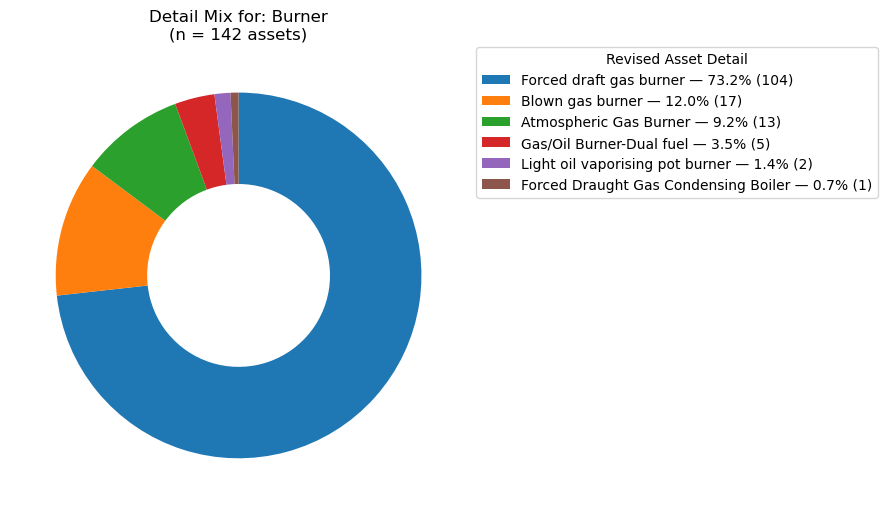

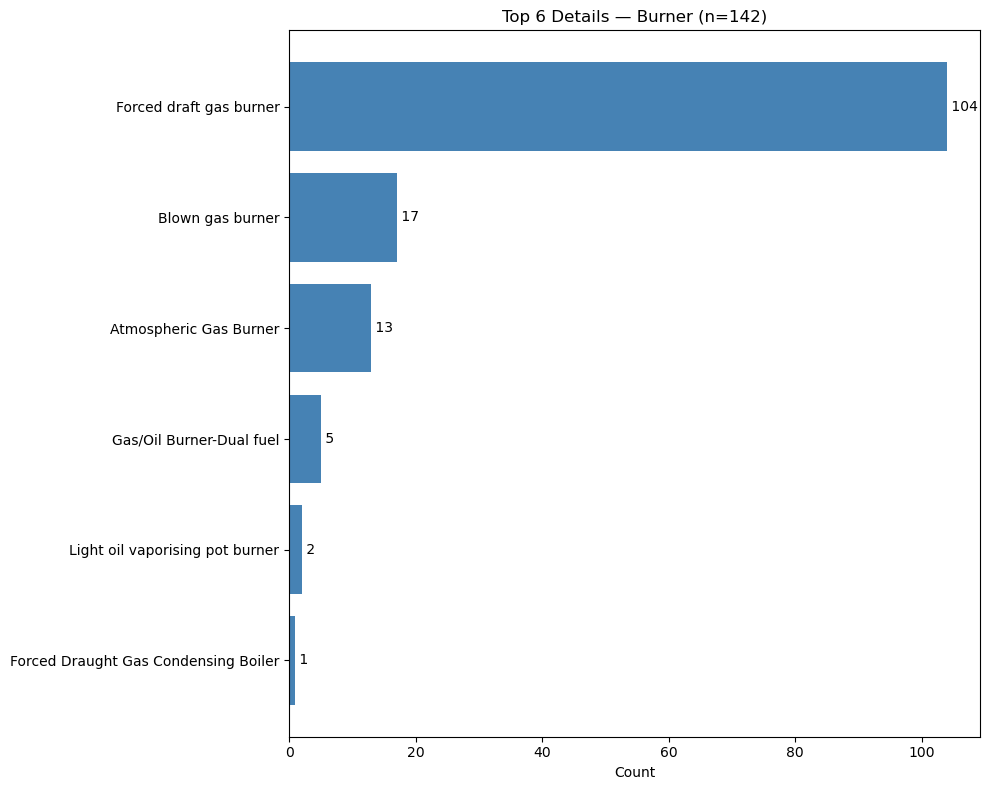

Now plotting group: Control Systems


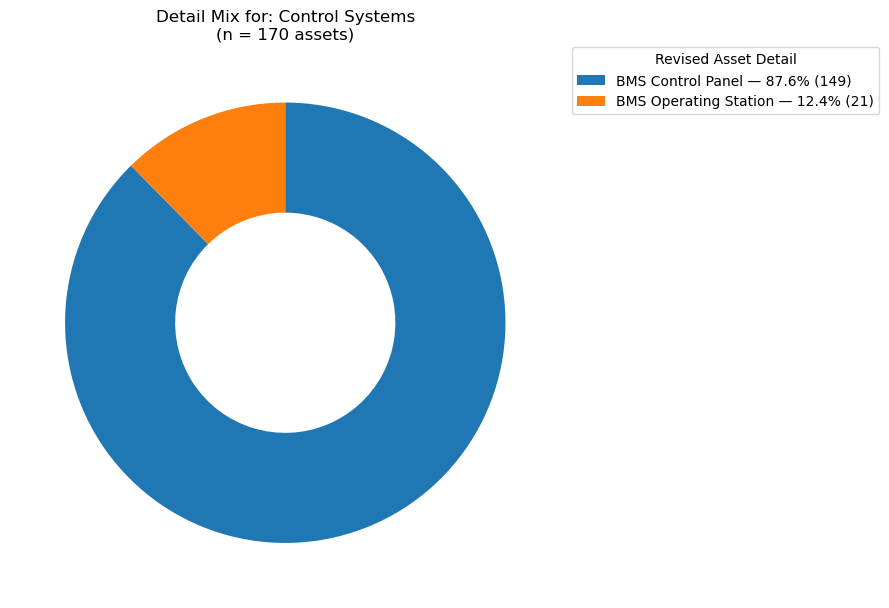

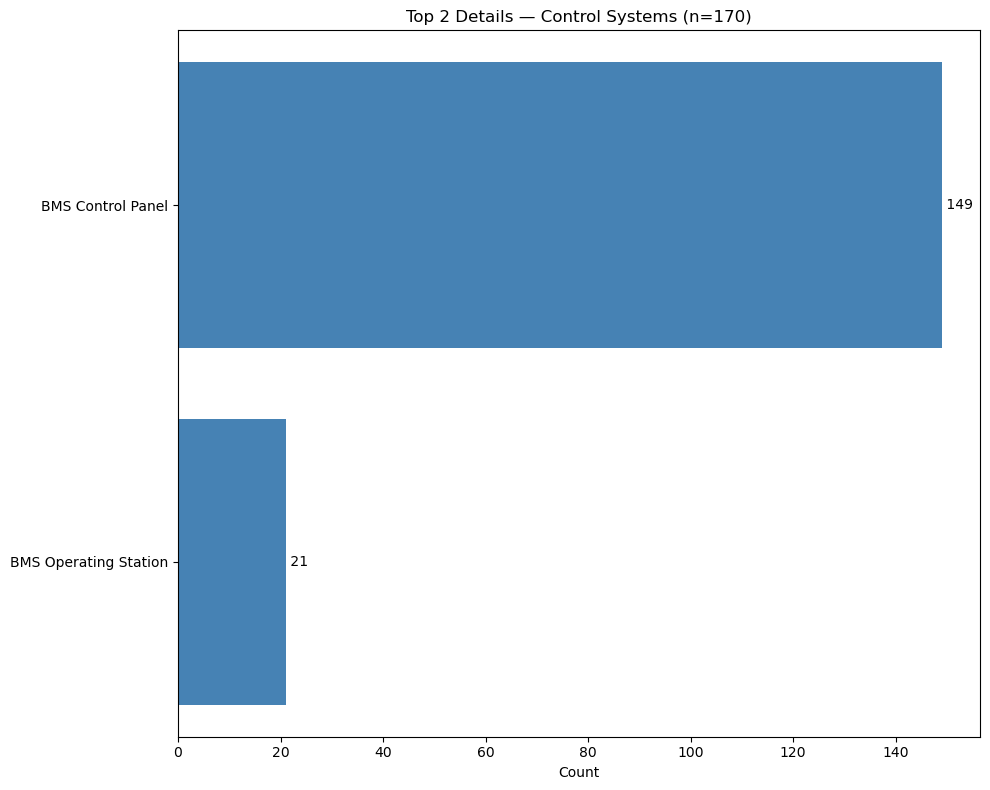

Now plotting group: Central Ventilation Systems


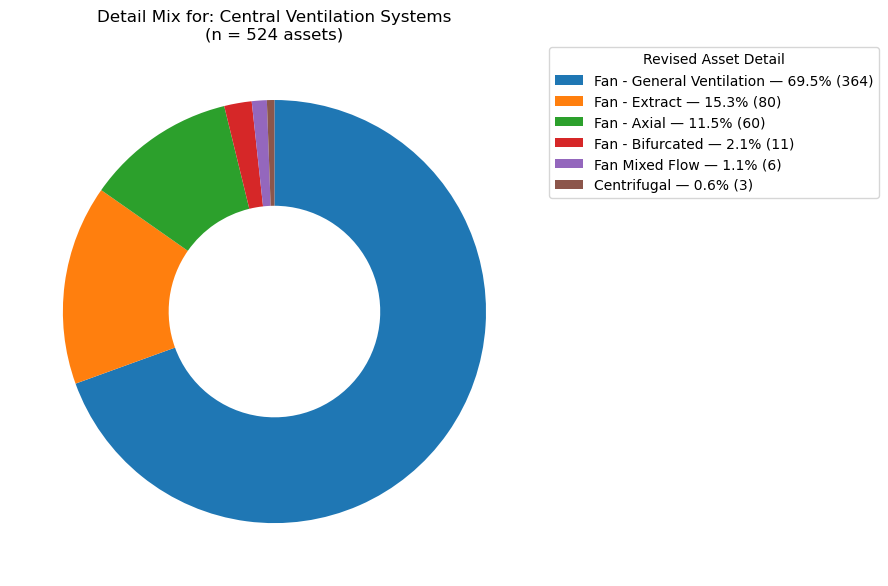

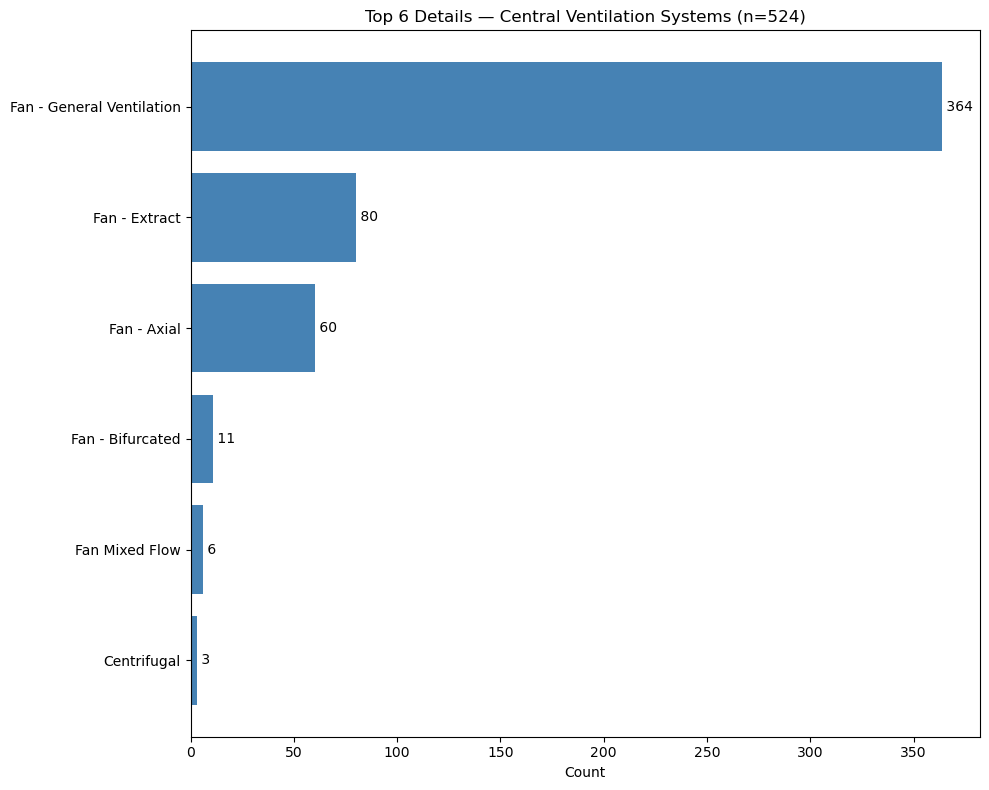

Now plotting group: AHU -  Internal


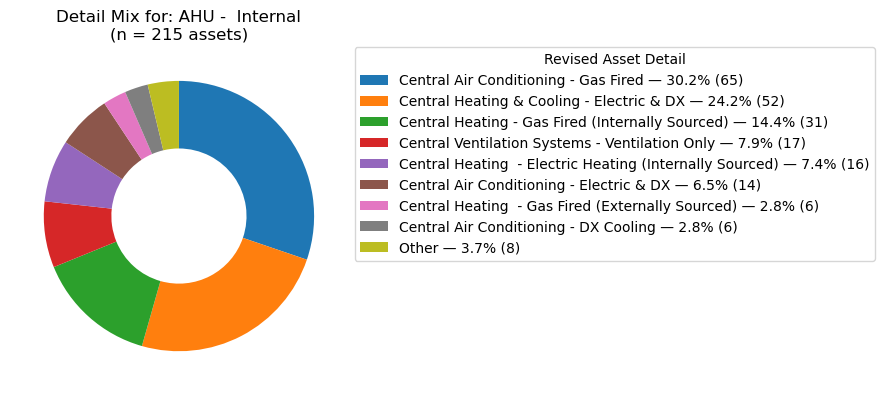

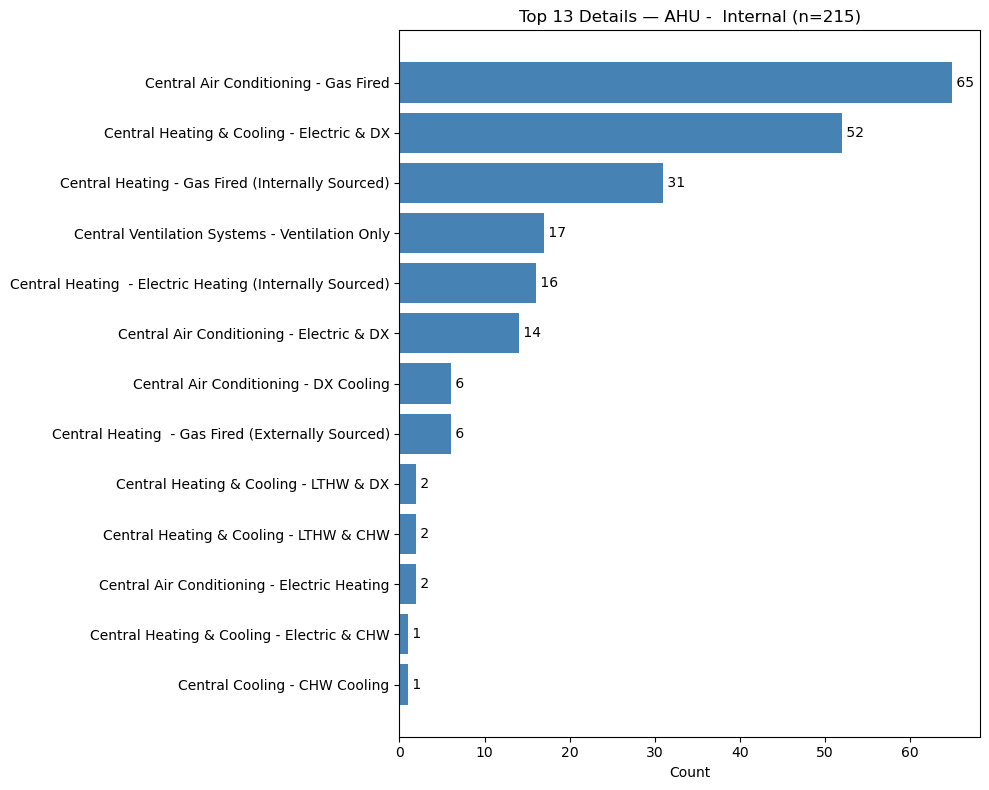

Now plotting group: Central Heating & Cooling


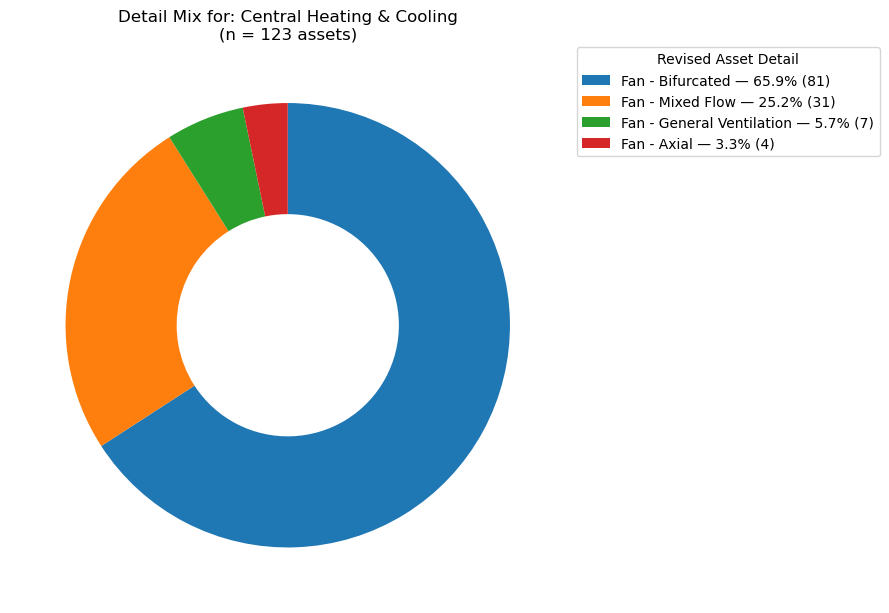

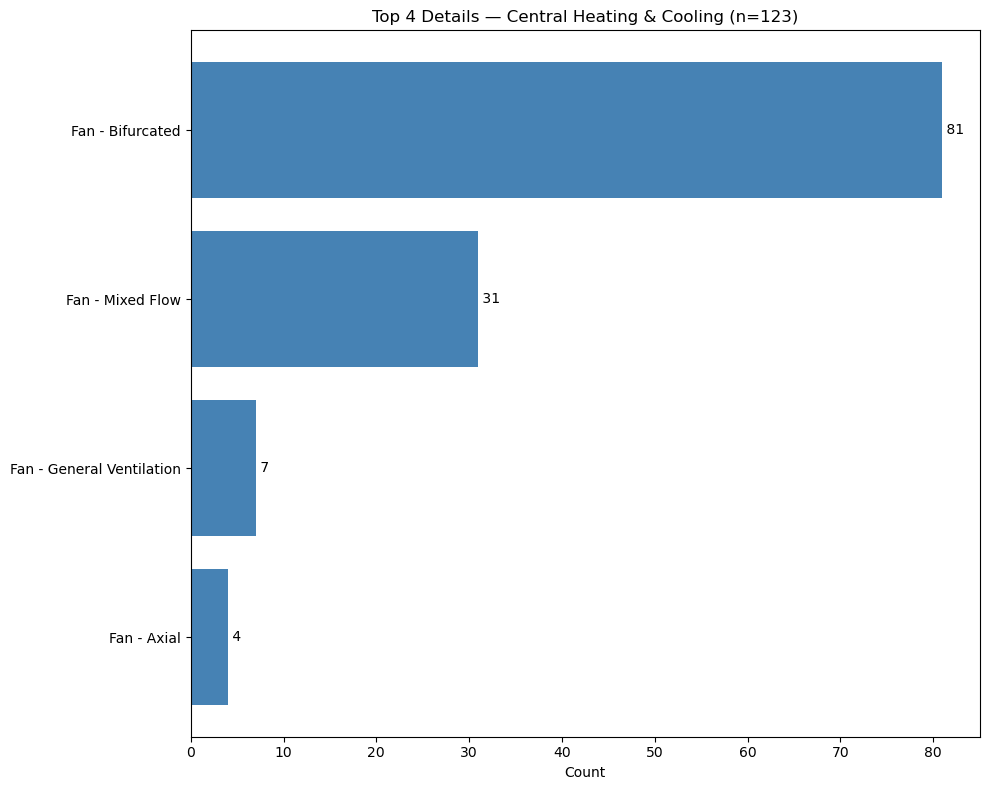

Now plotting group: Heating and Cooling


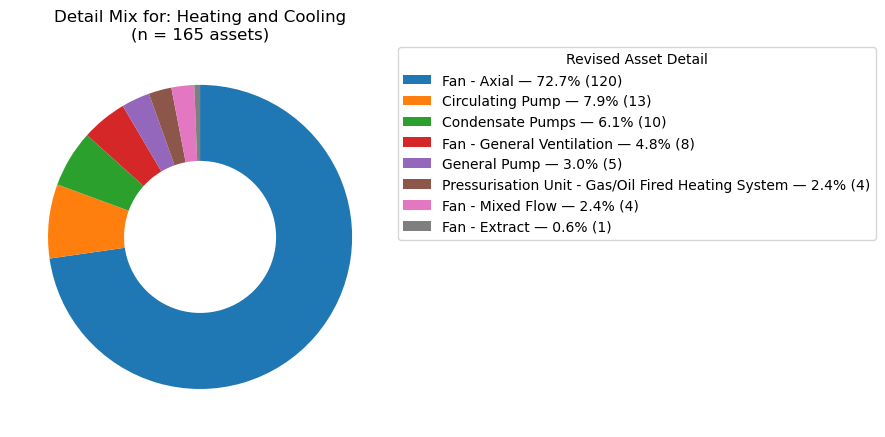

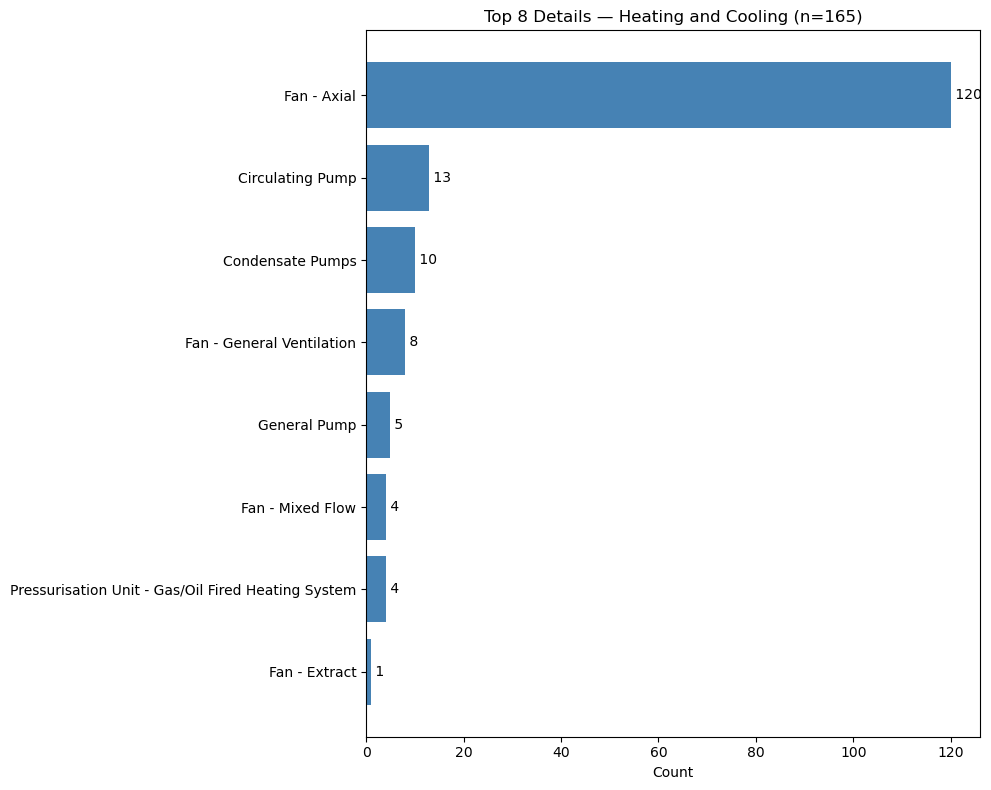

Now plotting group: Drainage


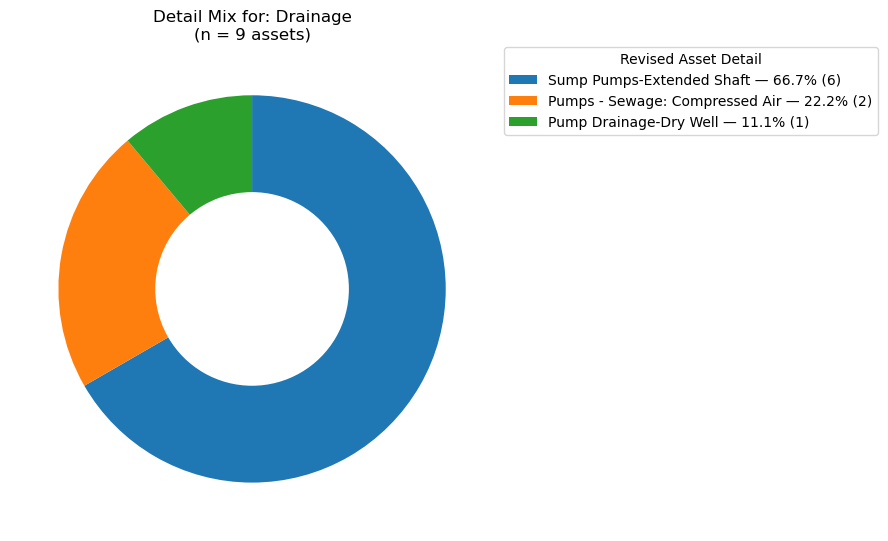

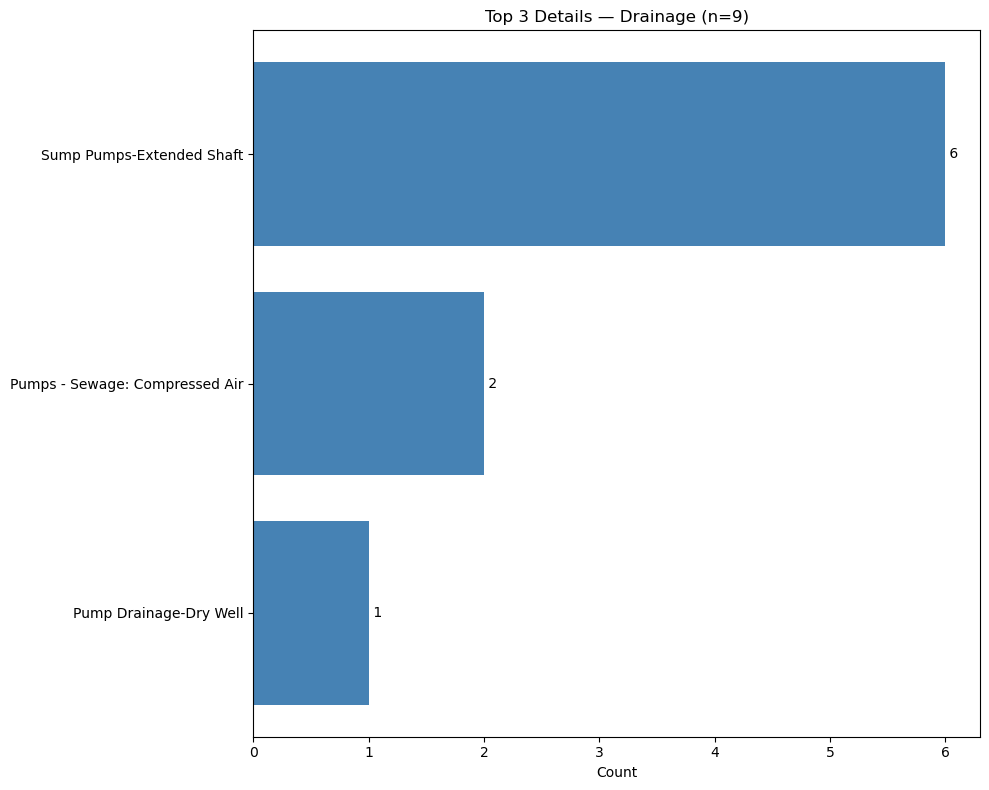

Now plotting group: AHU -  External


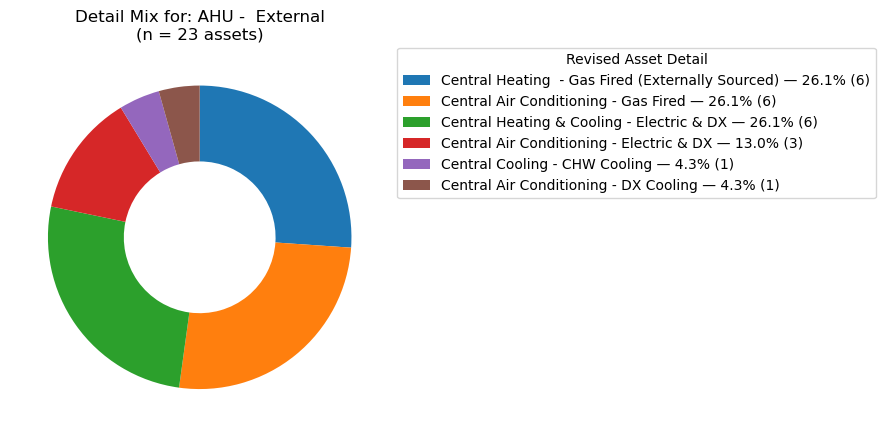

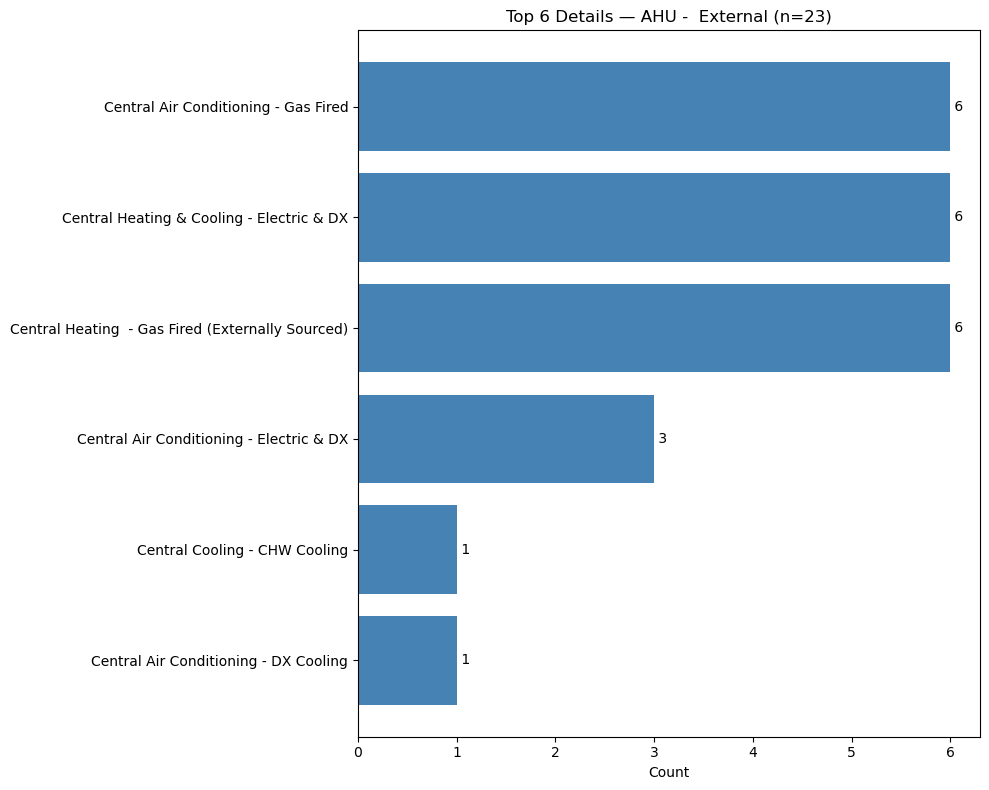

Now plotting group: Solar Power Generation 


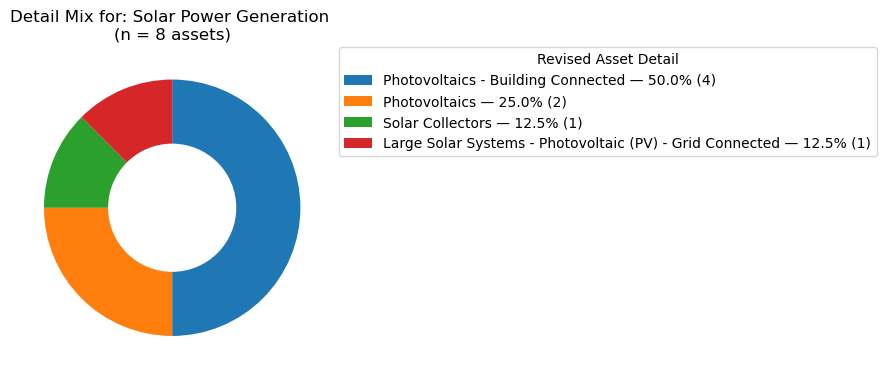

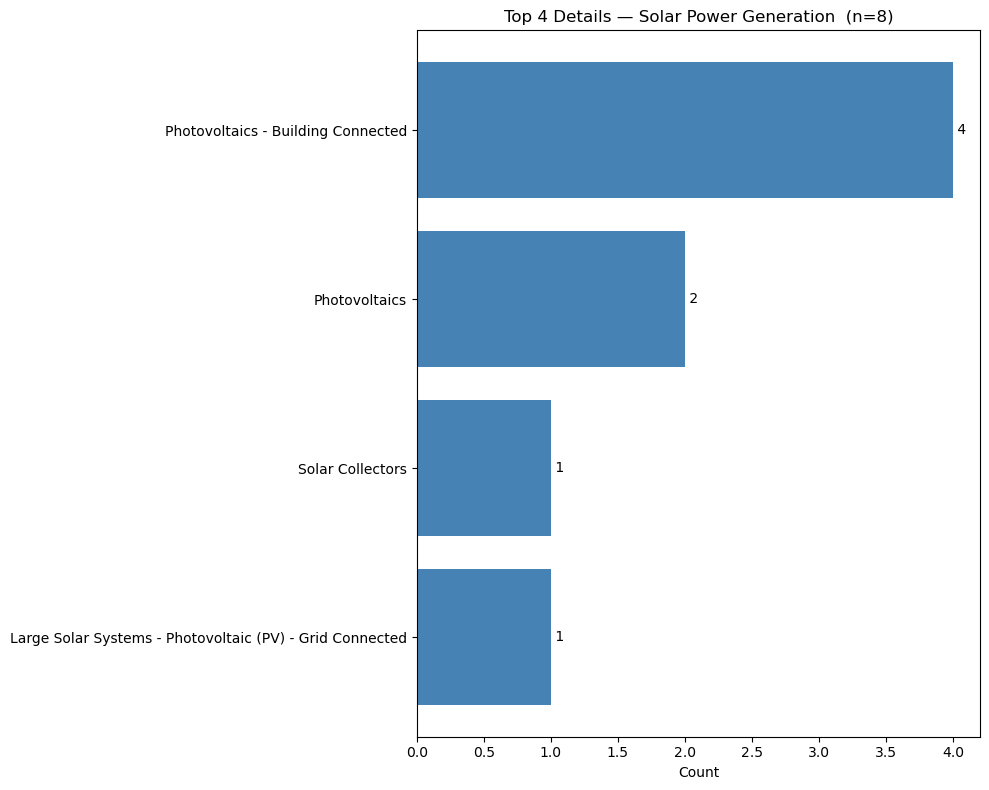

Now plotting group: Fuel Systems


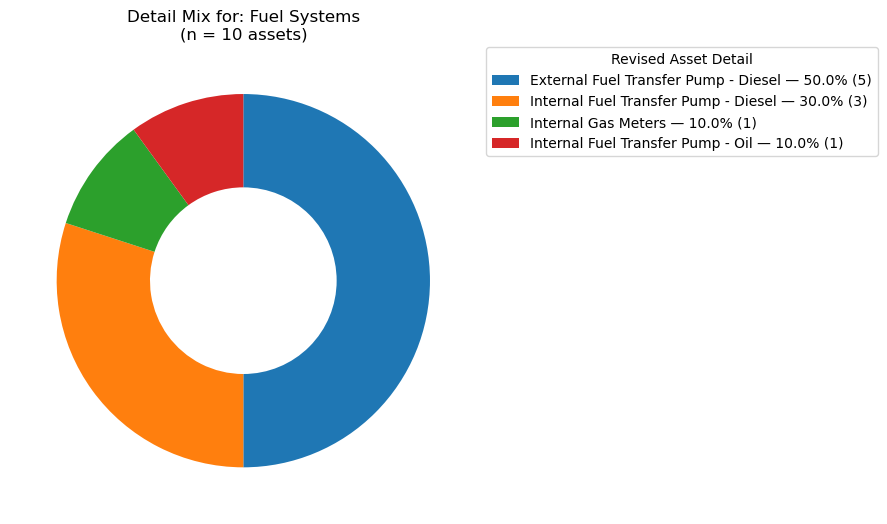

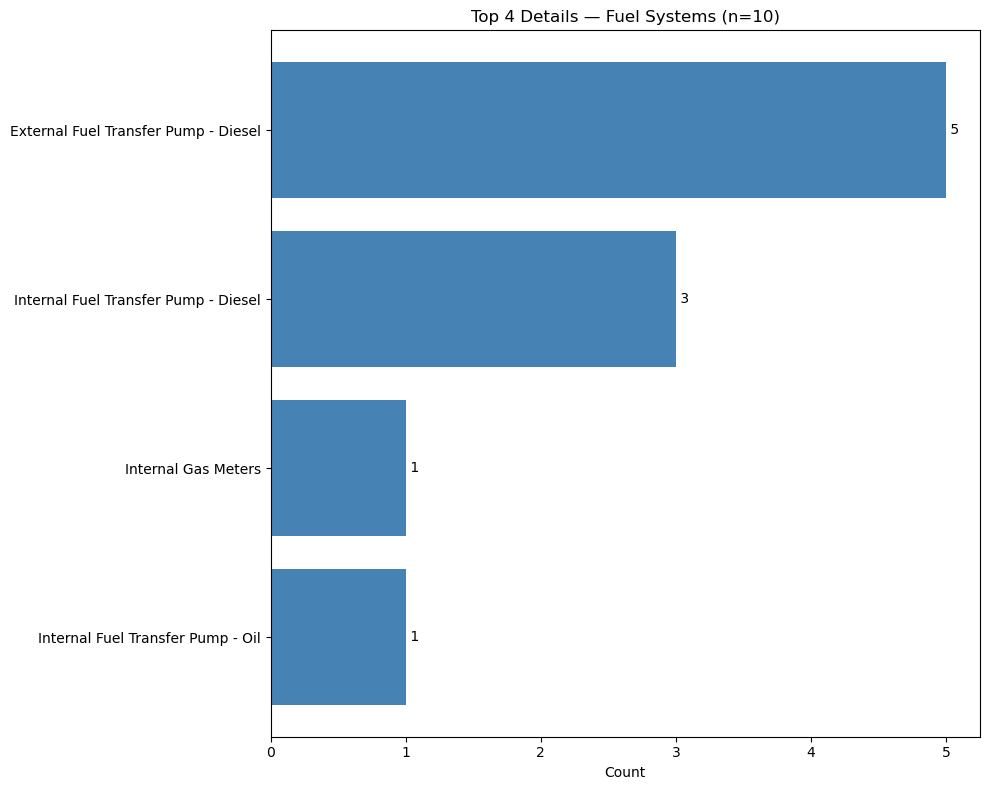

Now plotting group: Roads, Paths and Paving's


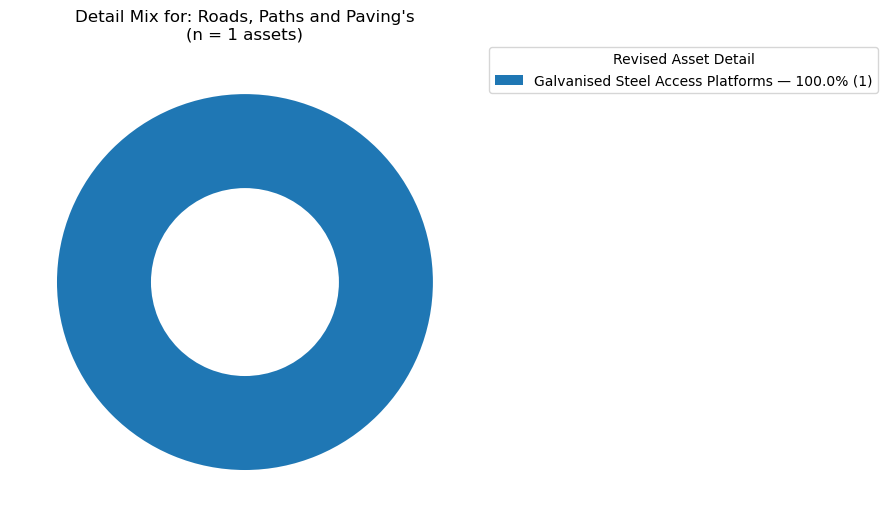

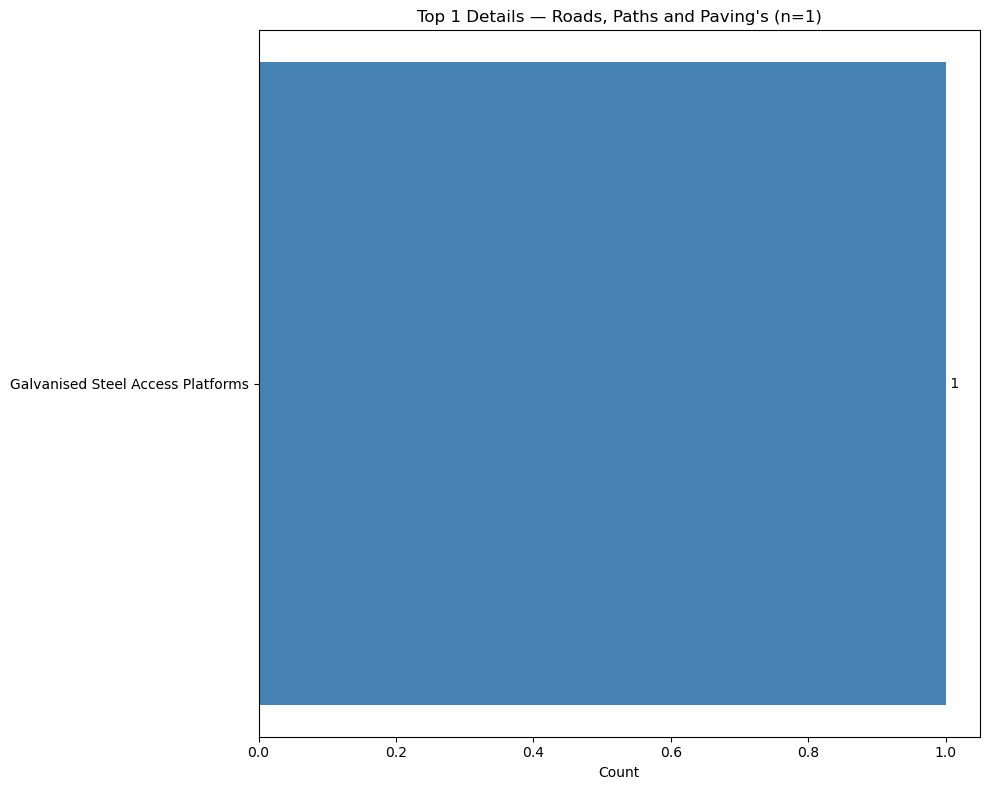

In [88]:
# Graph statistics for asset description and asset detail
# 0) ---- Define your roll-up groups here ----
# Map ORIGINAL "Revised Asset Description" 
group_map = {
     "Emergency Lighting": "Lighting",
     "External Lighting": "Lighting",
     "Roller Shutters": "Points of Access",
     "External Doors": "Points of Access",
     "Fire Safety Systems": "Life Safety Systems",
     "Emergency Communication Systems": "Life Safety Systems",
     "General Lighting": "Lighting",
     "Lightning Protection": "Life Safety Systems",
     "Domestic Kitchen": "Staff Facilities",
     "Sanitary": "Staff Facilities",
     "Security Systems": "Security & Access Control",
     "Access Control": "Security & Access Control",
     "Specialist Lighting": "Lighting",
     "Central Cooling": "Heating & Cooling",
     "Air Conditioning": "Heating & Cooling",
     "BMS": "Control Systems",
     "Multi-System Controls": "Controls Systems",
     "Central Ventilation": "Ventilation",
     "Local and Special Ventilation": "Ventilation",
     "Central Heating and Cooling": "Heating and Cooling",
     "Central Heating": "Heating and Cooling",
     "Foul Drainage": "Drainage",
     "External Drainage": "Drainage",
     "AHU - Internal": "AHU",
     "AHU - External": "AHU",
     "Heat Exchangers": "Heating & Cooling",
     "Heat Emmitters": "Heating & Cooling",
     "CCTV": "Security & Access Control",
     "Specialist Piped Systems": "Water Distribution",
     "Hot Water Distribution": "Water Distribution",
     "Local Hot Water": "Water Distribution",
     "Mains Water Supply": "Water Distribution",
     "Cold Water Distribution": "Water Distribution",
     "Heat Pumps": "Heating & Cooling",
     "Roof": "Fabric & Infrastructure",
     "Roads, Paths & Paving's": "Fabric & Infrastructure",
     "Barriers & Guardrails": "Fabric & Infrastructure",
     "Communication Systems": "Controls Systems",
}

# 1) Create a grouped category column
group_col = "Revised Asset Description (Grouped)"
df_assets[group_col] = df_assets["Revised Asset Description"].map(group_map)\
    .fillna(df_assets["Revised Asset Description"])

# 2) Plot functions now accept which category column to use 
def plot_detail_pie(df, category, top_n=8, category_col=group_col):
    sub = df[df[category_col] == category]
    if sub.empty:
        print(f"No rows for '{category}'.")
        return

    counts = (sub["Revised Asset Detail"]
              .astype("string").str.strip().fillna("Unknown")
              .value_counts())

    # keep top N, group the rest as "Other"
    if len(counts) > top_n:
        top = counts.head(top_n)
        other = pd.Series({"Other": counts.iloc[top_n:].sum()})
        counts = pd.concat([top, other])

    total_n = int(counts.sum())

    fig, ax = plt.subplots(figsize=(9,9))
    wedges, _ = ax.pie(
        counts.values,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.5)  # donut
    )

    ax.set_title(f"Detail Mix for: {category}\n(n = {total_n} assets)")

    pct = (counts / counts.sum() * 100).round(1)
    legend_labels = [f"{lab} — {p:.1f}% ({c})"
                     for lab, p, c in zip(counts.index, pct, counts.values)]

    ax.legend(wedges, legend_labels,
              title="Revised Asset Detail",
              bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    plt.show()


def detail_bar(df, category, top_n=15, category_col=group_col):
    sub = df[df[category_col] == category]
    if sub.empty:
        print(f"No rows for '{category}'.")
        return

    counts = (sub["Revised Asset Detail"]
              .astype("string").str.strip().fillna("Unknown")
              .value_counts().head(top_n)).sort_values()

    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(counts.index, counts.values, color="steelblue")
    ax.set_title(f"Top {len(counts)} Details — {category} (n={len(sub)})")
    ax.set_xlabel("Count")

    for y, v in enumerate(counts.values):
        ax.text(v, y, f" {v}", va='center')

    plt.tight_layout()
    plt.show()

# 3) Loop through your grouped categories
for category in df_assets[group_col].dropna().unique():
    print(f"Now plotting group: {category}")
    plot_detail_pie(df_assets, category=category, top_n=8, category_col=group_col)
    detail_bar(df_assets, category=category, top_n=15, category_col=group_col)


In [89]:
PROJECT_ROOT = Path("..").resolve()                     # one level up from notebooks/
DATA_PROCESSED = PROJECT_ROOT / "data-processed"        # output folder

# Output filename
output_path = DATA_PROCESSED / "df_assets_row_check.xlsx"

# Write file
df_assets.to_excel(output_path, index=False)

print(f"File written to: {output_path.resolve()}")


File written to: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-processed\df_assets_row_check.xlsx


In [90]:
# Quick check
df_assets.head()

Facility ID   Facility Facility General Location                     System  \
0    FAC_0001  SITE_0001                    Town A  Communication and Control   
1    FAC_0001  SITE_0001                    Town A                   Security   
2    FAC_0001  SITE_0001                    Town A                       Fire   
3    FAC_0001  SITE_0001                    Town A                   Sanitary   
4    FAC_0002  SITE_0002                    Town A                   Sanitary   

                              Type  \
0  Emergency Communication Systems   
1                 Security Systems   
2                   Fire Detection   
3                   Cleaners Sinks   
4   WC Toilet Standard / All Types   

                                    System full path  \
0  Communication and Control | Emergency Communic...   
1  Security | Security Systems | Personal Protect...   
2  Fire | Fire Detection | Fire Call Point / Brea...   
3  Sanitary | Cleaners Sinks | Vitreous china/fir...   
4  Sanitary | WC Toilet Standard / All Types | Vi...   

                          Asset type                    Category  \
0             Pull Cord/Alarm Switch  Communications and Control   
1       Personal Attack Alarm System                    Security   
2  Fire Call Point / Break Glass BGU                        Fire   
3       Vitreous china/fireclay/uPVC                    Sanitary   
4       Vitreous china/fireclay/uPVC                    Sanitary   

  Asset ID/Barcode Criticality description Condition  Quantity  \
0    ASSET_0000001                  Urgent         B         1   
1    ASSET_0000002                  Urgent         B         2   
2    ASSET_0000003                  Urgent         B         2   
3    ASSET_0000004                     Low         B         1   
4    ASSET_0000005                  Medium         B         2   

   Replacement Cost  Life Cycle  Revised Life  Expected remaining life  \
0                75          10             3                        3   
1              3000          15             8                        8   
2               392          15             8                        8   
3               350          20            13                       13   
4               600          20             6                        6   

   CIBSE Life Expectancy  Revised Exp Year  Match  10 Year Total  \
0                     10              2027   True           75.0   
1                     15              2032   True         3000.0   
2                     15              2032   True          392.0   
3                     20              2037   True            0.0   
4                     20              2030   True          600.0   

               Our Category 1  Our Category 2  25+ Years  15+ Years  \
0  Communications and Control   Comms Systems      False      False   
1                    Security         Systems      False      False   
2                        Fire  Fire Detection      False      False   
3                    Sanitary        Sanitary      False      False   
4                    Sanitary        Sanitary      False       True   

   Condition Score  Criticality Description Score  Combined Score (Equal)  \
0                5                              1                     2.2   
1                5                              1                     2.2   
2                5                              1                     2.2   
3                5                              4                     3.7   
4                5                              3                     3.2   

   Replacement Rank  Exp Year Ranking        Revised Asset Description  \
0              1373             13268  Emergency Communication Systems   
1              1374             20254                 Security Systems   
2              1375             20255              Fire Safety Systems   
3             32634             27310                         Sanitary   
4             19658          

In [91]:
# Determine project root (one level up from notebooks/)
PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data-processed"

# Ensure output directory exists
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Save to Excel
export_cols = [
    "Revised Asset Description",
    "Revised Asset Detail",
    "Facility General Location",
    "Quantity",
    "Criticality description",
    "Condition",
    "Revised Life",
    "Revised Exp Year",
    "Condition Score",
    "Criticality Description Score",
    "Combined Score (Equal)",
    "Replacement Rank",
    "Exp Year Ranking",
]

present = [c for c in export_cols if c in df_assets.columns]
missing = [c for c in export_cols if c not in df_assets.columns]

if missing:
    print("Skipping missing columns:", missing)

output_path = DATA_PROCESSED / "df_assets_ranking.xlsx"

df_assets.to_excel(output_path, index=False, columns=present)

print(f"File written to: {output_path.resolve()}")


File written to: C:\Users\RoryO'Brien\anaconda_projects\asset-lifecycle-portfolio\data-processed\df_assets_ranking.xlsx
